# Prediction of marketing success
### Zora Schärer

## Problem Definition
The starbucks data contains information about customers, about different types of offers made to these customers and about the purchase behaviour of the customers after they received these offers. From a marketing perspective it is interesting to know if is worth sending offers to certain customers, i.e. with certain demographics, as well as what kind of offers are best sent to which kind of customers through which channels.

In order to answer these questions this project takes two steps:
1. A classification algorithm is trained to predict the outcome of an offer depending on features regarding user demographics as well as offer type and channel of distribution.
2. By means of this algorithm, different types of offers and distribution channels are combined with any (new or old) user to see which combination will lead to a successfull outcome. 

The result of the project can be seen as a marketing tool to decide what kind of offers to send to users.

## Libraries & Data

In [47]:
# read libraries
import pandas as pd
import numpy as np
import json
import math
import time
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
# read data
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data exploration and cleaning

### Portfolio dataframe

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Before further exploration of this dataframe, the `channels` column needs to be separated into 4 columns with 0 or 1 entries.

In [4]:
# create a dataframe with 0 and 1 entries for each channel type
channel_df = pd.DataFrame(index = portfolio.index, columns = ['email', 'mobile', 'social', 'web'])
for index, row in portfolio.iterrows():
    for i in range(len(row.channels)):
        channel_df[row.channels[i]].loc[index] = 1
channel_df.fillna(0, inplace = True)

In [5]:
# concatenate the channel_df with the portfolio dataframe
portfolio = pd.concat([portfolio, channel_df], axis = 1).drop(columns=['channels'])

In [6]:
# rename id to offer_id
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

In [7]:
portfolio.dtypes

reward         int64
difficulty     int64
duration       int64
offer_type    object
offer_id      object
email          int64
mobile         int64
social         int64
web            int64
dtype: object

In [8]:
portfolio.shape

(10, 9)

In [9]:
portfolio.isna().sum()

reward        0
difficulty    0
duration      0
offer_type    0
offer_id      0
email         0
mobile        0
social        0
web           0
dtype: int64

In [10]:
portfolio.describe()

,reward,difficulty,duration,email,mobile,social,web
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,1.0,0.900000,0.600000,0.800000
std,3.583915,5.831905,2.321398,0.0,0.316228,0.516398,0.421637
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000
50%,4.000000,8.500000,7.000000,1.0,1.000000,1.000000,1.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000


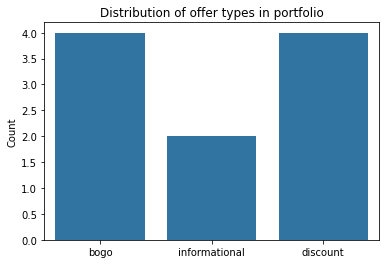

In [11]:
col = sb.color_palette()[0]
sb.countplot(data = portfolio, x  = 'offer_type', color = col)
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of offer types in portfolio');

### Profile dataframe

In [12]:
profile.sample(10)

,gender,age,id,became_member_on,income
9488,M,39,9ca1196e54194ca9bf1a4b1327715e9e,20161007,59000.0
2847,F,89,d724ee8209cb45019d5ca5374d00eb80,20171002,104000.0
15175,M,85,0f628df0d3fb4e1192f156de98ec4a0b,20180318,59000.0
14765,F,76,d23c69f5c4e94d3facd36be424f32d41,20151116,65000.0
12069,M,58,12adf13711144814b9dabf37838edb47,20170720,104000.0
168,F,51,3ecb372184104ff7bad0f0f60cb56e29,20170316,85000.0
11083,O,60,7651ccd65fa7484d972f75f2f2307010,20140701,48000.0
3216,F,55,d1c675320dcc4666a9300edc39965235,20160825,93000.0
155,M,72,1827da57bb924833a6f73c79b5f2bbc5,20180601,33000.0
1404,M,31,4d7d5a156adf4aa4b4a1f5b8851d1e7a,20180118,44000.0


In [13]:
profile.rename(columns = {'id': 'user_id'}, inplace = True)

In [14]:
profile.dtypes

gender               object
age                   int64
user_id              object
became_member_on      int64
income              float64
dtype: object

In [15]:
# change datatype of became_member_on column
profile['became_member_on'] = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [16]:
profile.shape

(17000, 5)

In [17]:
profile.isna().sum()

gender              2175
age                    0
user_id                0
became_member_on       0
income              2175
dtype: int64

In [18]:
# check occurence of NaN values
profile[profile.gender.isna()]

,gender,age,user_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN


In [19]:
# replace ages of 118 with NaN
profile['age'] = profile.age.replace(118, np.nan)

In [20]:
profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


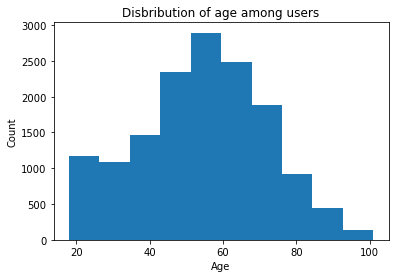

In [21]:
plt.hist(profile.age)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Disbribution of age among users');

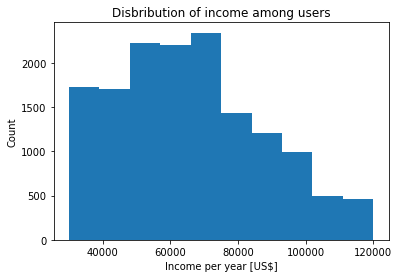

In [22]:
plt.hist(profile.income)
plt.xlabel('Income per year [US$]')
plt.ylabel('Count')
plt.title('Disbribution of income among users');

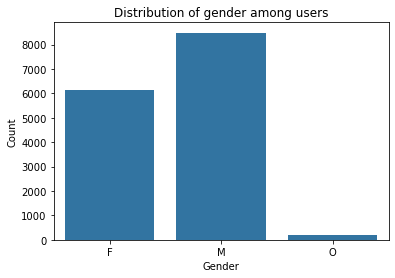

In [23]:
sb.countplot(data = profile, x  = 'gender', color = col)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of gender among users');

### Transcript dataframe

In [24]:
transcript.sample(10)

,person,event,value,time
119783,c4cdf0fdcf6a4350a84e8cc15027cf9f,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},336
54053,427b6f492f62468cb53ad6c040002b88,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},168
118041,7612d9106ce94b26970c2ae2adf13773,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},336
74635,f91e32724bc548cfa96306fa256adb6c,transaction,{'amount': 0.96},180
232156,09144b1952844d96b356b7aae28ec80d,transaction,{'amount': 1.45},534
59690,d55274b1920249d5a762b033e700536b,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168
265335,a31bed7e7b87445a99950cc805ad7cbb,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},582
135698,6c1a4e344d4b4215a07e2a3dfd655069,transaction,{'amount': 3.42},360
123340,76abf2e2aa304441987f859f20229378,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336
86924,ddb0fdd5873a446283eb889546c19655,transaction,{'amount': 2.16},216


Before further exploration of this dataframe, the `value` column needs to be separated into 2 columns for amount and offer id. 

In [25]:
extended_value = pd.json_normalize(transcript.value)

In [26]:
transcript['offer_received'] = extended_value['offer id']
transcript['offer_viewed'] = extended_value['offer id']
transcript['offer_completed'] = extended_value['offer_id']
transcript['transaction'] = extended_value['amount']
transcript['reward'] = extended_value['reward']

In [27]:
transcript.loc[transcript.event == 'offer received', 'offer_viewed'] = np.nan
transcript.loc[transcript.event == 'offer viewed', 'offer_received'] = np.nan
transcript.drop(columns = ['value'], inplace = True)

In [28]:
transcript.rename(columns = {'person': 'user_id'}, inplace = True)

In [29]:
transcript.dtypes

user_id             object
event               object
time                 int64
offer_received      object
offer_viewed        object
offer_completed     object
transaction        float64
reward             float64
dtype: object

In [30]:
transcript.shape

(306534, 8)

In [31]:
transcript.isna().sum()

user_id                 0
event                   0
time                    0
offer_received     230257
offer_viewed       248809
offer_completed    272955
transaction        167581
reward             272955
dtype: int64

In [32]:
transcript.describe()

,time,transaction,reward
count,306534.000000,138953.000000,33579.000000
mean,366.382940,12.777356,4.904137
std,200.326314,30.250529,2.886647
min,0.000000,0.050000,2.000000
25%,186.000000,2.780000,2.000000
50%,408.000000,8.890000,5.000000
75%,528.000000,18.070000,5.000000
max,714.000000,1062.280000,10.000000


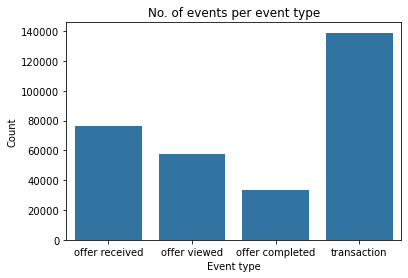

In [33]:
event_order = ['offer received', 'offer viewed', 'offer completed', 'transaction']
sb.countplot(data = transcript, x  = 'event', color = col, order = event_order)
plt.xlabel('Event type')
plt.ylabel('Count')
plt.title('No. of events per event type');

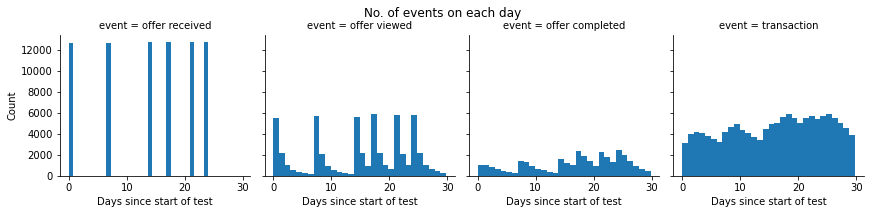

In [34]:
transcript['time_days'] = transcript.time/24
g = sb.FacetGrid(data = transcript, col = 'event', sharey = True, col_order = event_order)
g.map(plt.hist, 'time_days', bins = 30);
for i in range(len(event_order)):
    g.axes[0,i].set_xlabel('Days since start of test')
g.axes[0,0].set_ylabel('Count')
g.fig.subplots_adjust(top = 0.85)
g.fig.suptitle('No. of events on each day');

## Data preprocessing
Before starting with the prediction, the labels and features for the prediction have to be defined. The intention is to predict different offer outcomes (labels) with different characteristics of the offers and users (features).

### Labels: Offer outcomes
Depending on the combinations of receiving, viewing and completing offers, the outcomes are defined as follows:

|offer received|offer viewed|offer completed|offer outcome|
|:---:|:---:|:---:|:---:|
|1|1|1|success|
|1|0|1|waste|
|1|1|0|failure|
|1|0|0|potential|

The outcome labels are to be understood as follows:
- success: the offer had its intended effect
- waste: the offer was unnecessary because the effect was reached even though the user did not view the offer or viewed it after completing the offer
- failure: the offer did not have its intended effect despite being viewed
- potential: the offer was not viewed for unknown reasons, but there could still be a potential effect in the future

In [35]:
# get statistics for received offers
transcript.groupby('user_id').nunique().describe().offer_received

count    17000.000000
mean         3.722824
std          0.991758
min          0.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          6.000000
Name: offer_received, dtype: float64

In [36]:
# get dataframe with events connected to offers
offer_df = transcript[transcript.event != 'transaction']
# check how many people got offers
offer_df.user_id.nunique()

16994

The above cell shows that the total number of users is 17000, so all but 6 users got at least one offer. I will thus continue working with only the users that got at least one offer.

Next, a dataframe with the offer outcomes has to be created. This is achieved by iterating through each user and each offer sent to each offer. The ligic 

In [37]:
# get dataframe with events connected to offers
offer_df = transcript[transcript.event != 'transaction']
# initiate data frame
total_offers = len(offer_df.offer_received.dropna()) # total number of offers sent to users
outcome_df = pd.DataFrame(np.nan, index = np.arange(total_offers), 
                          columns = ['user_id', 'offer_id', 'offer_outcome', 'offered_before'])
print('Total iterations:', total_offers) # for monitoring progress

start = time.time()
i = 0
for u_id in offer_df.user_id.unique(): # iterate through unique users 
    user_df = offer_df[offer_df.user_id == u_id] # get data frame for only one user
    for index, row in user_df.iterrows(): # iterate through received offers of this user
        if type(row.offer_received) is str: # if an offer was received
            outcome_df.loc[i,'user_id'] = u_id # write user id into data frame
            outcome_df.loc[i, 'offer_id'] = row.offer_received # write offer id into data frame
            
            rec_index = index # index of receiving
            # record if an offer was sent more than once to the same user
            if len(user_df[user_df['offer_received'].str.match(row.offer_received) == True]) > 1:
                outcome_df.loc[i, 'offered_before'] = 1 
            else:
                outcome_df.loc[i, 'offered_before'] = 0
            
            # get views occuring after current offer
            views = user_df.loc[index+1:, 'offer_viewed'].str.match(row.offer_received).dropna()
            views = views.index[views]
            if views.empty: # in case offer was not viewed
                view_index = np.nan
            else: 
                view_index = views[0]
             
            # get completions occuring after current offer
            comps = user_df.loc[index+1:, 'offer_completed'].str.match(row.offer_received).dropna() 
            comps = comps.index[comps]
            if comps.empty: # in case offer was not completed
                comp_index = np.nan 
            else: 
                comp_index = comps[0]
            
            if (rec_index < view_index) & (view_index < comp_index): # offer received, viewed, completed
                outcome_df.loc[i, 'offer_outcome'] = 'success'
            if (rec_index < view_index) & np.isnan(comp_index): # offer received, viewed, not completed
                outcome_df.loc[i, 'offer_outcome'] = 'failure'
            if (rec_index < view_index) & (view_index > comp_index): # offer received, completed, viewed
                outcome_df.loc[i, 'offer_outcome'] = 'waste' 
            if np.isnan(view_index) & (rec_index < comp_index): # offer received, not viewed, completed
                outcome_df.loc[i, 'offer_outcome'] = 'waste'
            if np.isnan(view_index) & np.isnan(comp_index): # offer received, not viewed, not completed 
                outcome_df.loc[i, 'offer_outcome'] = 'potential'
                
            if i in np.arange(0, total_offers, 5000):
                print('Current iteration:', i) # monitor progress
            i += 1
            
            del [views, comps, rec_index, view_index, comp_index] # free memory
    del user_df # free memory
end = time.time()
print('Elapsed time:', (end-start)/60, 'minutes')

Total iterations: 76277
0 15561 47583
success
Current iteration: 0
53176 85291 nan
failure
150598 163375 218394
success
201572 262138 218395
1 15562 nan
failure
110829 123539 nan
failure
150599 nan nan
201573 281785 nan
failure
245125 281785 nan
failure
2 20283 nan
failure
110830 nan nan
150600 171209 225061
success
201574 225059 225062
success
3 18067 nan
failure
53177 85292 nan
failure
120424 137418 nan
failure
160235 189198 nan
failure
201575 225063 nan
failure
4 38221 nan
failure
53178 nan nan
118294 130149 nan
failure
158119 177263 nan
failure
201576 289715 nan
failure
5 12650 32626
success
53179 77212 200086
success
110831 132803 200085
success
150601 179953 200086
success
201577 214275 271781
success
245126 265621 271782
success
6 22297 nan
failure
110833 130151 nan
failure
245127 299271 299273
success
7 nan nan
53182 65844 nan
failure
110835 130152 187137
success
8 20284 nan
failure
53183 65845 83401
success
110836 123541 nan
failure
150604 177264 174356
245129 277105 283961
su

201646 nan nan
74 26125 22309
110908 130171 nan
failure
150678 nan nan
201647 214290 218422
success
245193 294721 265635
75 12665 24231
success
53250 nan 65872
110909 141576 145390
success
150679 171234 182564
success
201648 218423 235183
success
245194 265636 274536
success
76 79438 nan
failure
53251 79438 nan
failure
110910 135241 nan
failure
150680 171235 nan
failure
201649 nan nan
77 15571 22311
success
53252 65873 nan
failure
110911 127154 135244
success
150681 174378 163399
245195 257906 268866
success
78 24232 31115
success
53253 nan 85308
110912 191234 195059
success
150682 191234 195059
success
201650 241317 279484
success
79 36920 nan
failure
110913 nan 147232
150683 198476 nan
failure
245197 nan nan
80 12666 22313
success
110914 123564 nan
failure
150684 163400 227860
success
245198 257908 257910
success
81 nan 262159
53254 65875 69341
success
110915 262157 147234
150685 nan 193203
201651 nan 262159
245199 262157 265638
success
82 22314 22316
success
53255 79440 87147
succes

success
114994 124790 131017
success
150757 168836 180769
success
148 195069 nan
failure
53323 nan nan
110981 130181 nan
failure
150758 195069 nan
failure
201722 225088 nan
failure
245274 nan nan
149 27861 22337
53324 182583 nan
failure
110982 139576 141591
success
150759 182583 nan
failure
201723 243252 265660
success
245275 265658 nan
failure
150 nan nan
53325 102651 nan
failure
110983 nan nan
150760 nan nan
201724 nan nan
245276 277127 nan
failure
151 15742 nan
failure
53327 77385 nan
failure
111796 123831 177461
success
150762 163718 nan
failure
201726 218667 nan
failure
245277 303306 nan
failure
152 nan 51357
53328 nan nan
110985 127171 nan
failure
201727 221931 nan
failure
153 nan nan
53329 79448 nan
failure
150763 167662 nan
failure
201728 218447 nan
failure
245278 nan nan
154 18094 nan
failure
53330 74827 83422
success
150764 163424 nan
failure
155 nan nan
110986 148943 nan
failure
201729 nan nan
245279 271814 nan
failure
156 nan nan
53331 83423 83425
success
110987 nan 177288


53393 98977 nan
failure
111049 130192 nan
failure
201792 225107 274567
success
245342 257957 274568
success
221 18101 nan
failure
53395 nan nan
150832 293140 nan
failure
222 24250 35563
success
53396 nan nan
111050 127191 nan
failure
150833 nan nan
201793 nan nan
223 27874 nan
failure
53398 69382 83442
success
111054 123616 nan
failure
150836 163447 nan
failure
201797 218463 230459
success
245346 279507 nan
failure
224 12693 nan
failure
53399 72191 nan
failure
111055 127192 nan
failure
201798 221950 nan
failure
245347 257958 nan
failure
225 nan nan
53400 nan nan
111056 123617 143611
success
201799 nan 214344
226 12694 18103
success
111057 127193 198493
success
201800 214345 nan
failure
227 12695 12697
success
111058 147257 nan
failure
150837 179993 nan
failure
228 22341 34077
success
111059 127194 127196
success
150838 163448 182595
success
201801 221951 232923
success
245348 257959 287893
success
229 12852 29631
success
53404 66079 nan
failure
150841 167863 nan
failure
201802 nan nan


failure
111117 nan nan
150910 nan nan
201621 221964 nan
failure
245414 265693 nan
failure
294 12710 nan
failure
53471 72217 nan
failure
111118 nan 145415
150911 187169 189255
success
245415 262213 294748
success
295 24265 nan
failure
53472 nan nan
111119 nan nan
150912 163470 nan
failure
245416 257983 287900
success
296 18632 nan
failure
54995 87560 nan
failure
152419 183120 177929
204579 219229 nan
failure
246893 262890 nan
failure
297 20326 24268
success
111122 127210 nan
failure
150915 167707 nan
failure
201870 nan nan
245419 262214 nan
failure
298 15624 nan
failure
53475 85332 nan
failure
111123 130208 nan
failure
150916 174432 182605
success
201871 227921 218480
245420 285953 271841
299 18119 nan
failure
53476 nan 88930
111124 127211 145417
success
201872 nan 257987
245421 274584 274586
success
300 45462 nan
failure
53478 97729 nan
failure
111126 127212 nan
failure
201874 nan nan
245423 281848 nan
failure
301 12712 nan
failure
53479 65925 nan
failure
111127 123631 nan
failure
1509

success
53542 83468 93711
success
111199 132873 nan
failure
201934 227935 232945
success
245491 nan nan
372 12732 nan
failure
53543 74866 nan
failure
111200 145431 nan
failure
150981 nan nan
201935 221981 232947
success
245492 nan nan
373 18132 nan
failure
53544 69414 74868
success
111201 127228 139609
success
150982 nan 279533
201936 230488 279534
success
245493 258011 279535
success
374 nan nan
53545 77271 nan
failure
111202 135299 nan
failure
150983 177329 196882
success
201937 221982 214395
245494 268933 265708
375 15632 18134
success
111203 123655 143634
success
376 34095 nan
failure
111204 123656 nan
failure
150984 163497 nan
failure
201938 227937 nan
failure
245495 258012 279538
success
377 12733 nan
failure
53546 214396 69416
111205 123657 nan
failure
150985 177330 nan
failure
201939 214396 nan
failure
245496 285966 305435
success
378 24523 32858
success
150986 nan nan
201940 nan 282186
245497 269329 282187
success
379 18136 77273
success
53548 87201 nan
failure
111208 130223 n

245569 262261 285981
success
445 12745 nan
failure
53621 81460 nan
failure
111281 123682 nan
failure
151061 163539 nan
failure
202014 222001 nan
failure
245571 258036 nan
failure
446 23063 37432
success
59053 98192 nan
failure
116703 nan 131176
156509 169040 nan
failure
207416 nan nan
250972 270024 nan
failure
447 24287 27908
success
53625 nan nan
111285 123684 nan
failure
151066 nan nan
202017 nan 284027
245574 258038 284028
success
448 nan nan
53626 72258 nan
failure
111286 123685 nan
failure
151067 nan nan
202018 218508 301962
success
449 265727 218511
53627 88948 77282
111287 nan nan
151068 189276 227956
success
202019 265727 218511
245576 265727 nan
failure
450 nan 21505
60716 108527 93028
245577 nan nan
451 95146 277183
success
111290 137510 177358
success
151071 180030 177359
245580 265728 277183
success
452 12746 27911
success
53630 81461 nan
failure
111291 135308 147293
success
202022 214426 230501
success
245581 265729 nan
failure
453 20347 65966
success
53631 81462 65967
111

520 12762 12764
success
53691 65984 nan
failure
111351 182646 nan
failure
202085 218529 nan
failure
245638 258054 nan
failure
521 27922 48577
success
111352 123706 nan
failure
151137 163565 196901
success
202086 nan 235254
245639 271894 299332
success
522 34118 nan
failure
53693 69444 83492
success
151139 163568 nan
failure
201660 214446 nan
failure
523 12765 12767
success
53694 72272 74896
success
111356 130263 147301
success
202089 nan 222009
524 31467 nan
failure
245643 272439 291924
success
525 22381 nan
failure
53696 95155 nan
failure
151143 163569 nan
failure
202092 nan nan
526 26191 31165
success
111359 132899 174471
success
151144 nan 174472
202093 241383 nan
failure
245646 258056 299334
success
527 12769 35590
success
111360 127258 nan
failure
151145 nan 193278
202094 241384 nan
failure
245647 258057 nan
failure
528 nan nan
53698 81474 102690
success
111361 123710 nan
failure
151146 nan 239437
202095 239435 239438
success
245648 268965 nan
failure
529 nan 28272
56327 nan nan
1

111418 123723 123725
success
202163 237442 286006
success
245711 nan 286007
593 18171 nan
failure
151210 nan 185005
202165 222031 nan
failure
245713 265762 271907
success
594 34126 36974
success
53760 nan nan
151211 193294 177378
202166 227993 nan
failure
245714 258077 nan
failure
595 22399 26204
success
53761 79523 nan
failure
111421 139656 171340
success
151212 167777 nan
failure
245715 258078 277204
success
596 nan 79525
111422 198547 185007
202167 265764 284052
success
597 24303 nan
failure
53762 69467 nan
failure
111423 130278 nan
failure
151213 163594 nan
failure
598 12782 24305
success
56676 79526 123731
success
111424 123729 nan
failure
154080 185008 nan
failure
202168 230536 274646
success
248556 279571 274646
599 18172 15671
53765 nan 72280
111425 137530 nan
failure
202170 214467 271909
success
600 109946 12784
111426 nan 139658
151215 nan 233008
202171 233006 241392
success
601 35058 nan
failure
202173 nan 283198
245719 300186 283199
602 22400 38280
success
53767 77317 92174

669 100304 31180
53833 100304 108017
success
111495 nan nan
151285 171353 nan
failure
245789 286018 297988
success
670 24318 nan
failure
245790 nan nan
671 29593 nan
failure
61622 92186 nan
failure
111496 nan nan
151286 nan nan
202236 nan nan
245791 nan nan
672 26213 nan
failure
53834 nan 99027
111497 nan 214487
151287 163619 214488
success
202237 230552 214489
245792 nan nan
673 12807 27941
success
53835 74916 nan
failure
111498 137550 147319
success
151288 180074 nan
failure
674 18183 nan
failure
53836 69485 nan
failure
111499 nan nan
151289 177392 nan
failure
202239 nan nan
245794 nan nan
675 34543 30006
111500 nan nan
151290 164696 nan
failure
202240 nan nan
245795 259302 nan
failure
676 nan 29596
53837 69487 nan
failure
151291 167796 167798
success
202242 225197 218572
245797 269000 284070
success
677 135350 174506
success
53838 nan nan
111501 135350 174506
success
151292 182672 174507
678 18185 22411
success
53839 69488 72298
success
111502 132930 nan
failure
151293 171355 nan
fa

53902 81509 nan
failure
151361 187243 nan
failure
748 22425 nan
failure
111568 nan 143701
202308 222073 239478
success
245858 258130 nan
failure
749 24330 34139
success
111569 123767 130313
success
151362 167816 200177
success
202309 214510 296434
success
245859 258131 296435
success
750 nan nan
53903 66037 96447
success
111570 137568 145475
success
202310 nan nan
245245 nan nan
751 20385 29604
success
53904 nan nan
111571 nan 147327
151364 nan 225215
202311 nan nan
245861 297995 297997
success
752 nan nan
151365 164848 175347
success
202312 231259 235982
success
245862 nan 286620
753 40860 29606
53906 nan 90626
111572 nan 189317
151366 171368 189318
success
202313 218593 218595
success
754 20387 nan
failure
53907 69498 nan
failure
245863 258133 nan
failure
755 22426 36993
success
53908 104908 81511
111573 135364 nan
failure
151367 167817 182693
success
202314 239479 241418
success
245864 269017 269019
success
756 22427 nan
failure
151368 174522 271941
success
202315 218596 271942
succ

151440 163676 nan
failure
202387 243342 nan
failure
245932 271956 nan
failure
825 20404 nan
failure
53980 66053 85409
success
245933 nan nan
826 20406 nan
failure
53982 nan nan
111651 123792 nan
failure
151443 174538 nan
failure
202390 237482 nan
failure
827 nan 40870
53983 69509 77353
success
151444 171376 185040
success
202391 nan 265809
828 20407 15711
53984 69510 nan
failure
202392 218619 nan
failure
245935 265810 nan
failure
829 15712 27962
success
53985 nan 66057
111652 nan nan
202393 nan nan
245936 nan nan
830 nan nan
53986 72327 77355
success
151445 198578 230581
success
202394 nan 230582
245937 284086 nan
failure
831 nan nan
57436 132952 nan
failure
115102 132952 nan
failure
205778 nan nan
832 43289 nan
failure
53988 218620 nan
failure
111654 130331 nan
failure
151446 167842 nan
failure
202395 218620 nan
failure
245938 287979 nan
failure
833 22437 45513
success
53990 nan nan
111656 nan nan
151448 nan nan
202396 218621 228036
success
245939 258155 269034
success
834 26229 42097

903 32707 72345
success
54065 66072 72345
success
151524 193333 nan
failure
202471 233061 284106
success
246019 289844 284107
904 19558 nan
failure
61526 73915 97224
success
119165 nan 217050
158977 170003 229560
success
905 23145 23147
success
58567 82226 82228
success
116238 128437 nan
failure
151526 nan nan
206924 223254 223256
success
250486 266958 275664
success
906 nan 67879
60396 67877 67880
success
118041 131694 144632
success
156028 176039 176041
success
202474 226648 nan
failure
252188 nan nan
907 nan 49579
111737 132976 nan
failure
151528 163701 222103
success
202475 258185 222104
908 15729 24349
success
54069 74950 74952
success
111738 180110 nan
failure
202476 218652 222106
success
246023 284108 nan
failure
909 40880 15731
54070 nan 139692
111739 nan 139692
246024 nan 284110
910 nan nan
54072 74953 103900
success
111741 149047 180112
success
151530 nan nan
202478 nan nan
246026 nan nan
911 30191 nan
failure
54073 67384 80305
success
111742 131296 nan
failure
151531 165178 

59001 nan nan
116651 136251 nan
failure
156453 169266 nan
failure
207366 nan nan
250921 259915 299931
success
982 16878 nan
failure
54152 80494 nan
failure
207946 220187 nan
failure
983 20438 26256
success
54153 89017 90651
success
111813 132992 143727
success
151603 298013 182733
202555 218673 225263
success
246093 298013 271999
984 13045 35734
success
54155 69696 79712
success
111814 187378 189502
success
202557 214830 nan
failure
246095 269231 286165
success
985 12863 12865
success
111815 141724 127363
151605 177462 174573
202558 230610 262378
success
986 32720 nan
failure
54159 66097 nan
failure
111817 123841 nan
failure
202559 nan nan
246098 nan nan
987 22460 nan
failure
54160 77386 108040
success
111818 123843 nan
failure
151609 167891 182737
success
202560 nan 225265
246099 265844 265846
success
988 31212 52328
success
54162 72361 nan
failure
111820 123845 nan
failure
246101 284121 nan
failure
989 45526 40891
54163 72362 101544
success
111821 139711 196960
success
151611 198606 

1056 31218 nan
failure
54222 nan nan
111886 nan nan
202621 258227 nan
failure
246161 258227 nan
failure
1057 nan nan
54223 nan nan
111888 139720 182748
success
151683 167915 nan
failure
202623 nan 230627
246163 269101 294848
success
1058 15762 15764
success
111889 nan nan
151684 nan nan
246164 nan nan
1059 26261 262395
success
151685 187283 nan
failure
202624 228079 262394
success
246165 258228 262395
success
1060 189394 90659
54225 74982 77401
success
111890 nan 141738
151686 189394 222140
success
202625 214623 222141
success
246166 nan 272017
1061 17046 43883
success
60409 70940 nan
failure
118050 134132 nan
failure
163148 186161 nan
failure
1062 12878 49590
success
54227 69560 nan
failure
202627 214625 nan
failure
1063 nan nan
59448 86205 nan
failure
117110 131508 nan
failure
246169 267171 nan
failure
1064 12879 43313
success
54229 87299 nan
failure
111894 nan nan
151690 177480 265860
success
202629 222143 265860
success
246170 nan 265861
1065 18263 nan
failure
54230 74983 nan
failu

1129 12904 66133
success
54293 185103 nan
failure
111954 nan nan
151753 185103 nan
failure
202697 225299 nan
failure
246233 nan nan
1130 12905 nan
failure
54294 nan nan
111955 nan nan
151754 nan nan
202698 nan nan
246234 265876 nan
failure
1131 18278 nan
failure
54295 66134 nan
failure
111956 135430 nan
failure
151755 177490 nan
failure
202699 228099 nan
failure
246235 262425 nan
failure
1132 16879 44895
success
63661 nan 138501
117244 125409 138502
success
207947 229155 nan
failure
1133 123876 nan
failure
54297 nan 72393
111958 123876 nan
failure
202701 214643 218714
success
246237 258254 277314
success
1134 nan nan
54298 nan nan
111959 123877 127398
success
151756 180157 230636
success
202702 218715 230637
success
246238 262426 nan
failure
1135 20457 37034
success
54299 90665 79613
202703 nan 239541
246239 258255 265879
success
1136 20982 24870
success
54300 85954 nan
failure
111960 219669 180862
151758 185703 nan
failure
202704 219669 282542
success
246240 269924 282543
success
1137

112027 123902 nan
failure
151829 nan nan
202774 nan nan
246306 274764 nan
failure
1204 15794 34198
success
112028 130432 230654
success
151830 180172 nan
failure
246307 262435 294869
success
1205 26279 35673
success
54376 72416 nan
failure
112030 133046 141758
success
1206 26280 77424
success
54377 79632 77424
151832 163804 nan
failure
202775 218738 nan
failure
246309 294870 nan
failure
1207 20468 39648
success
54378 69592 nan
failure
112031 135443 nan
failure
151833 171459 182780
success
202776 218739 218741
success
1208 18292 nan
failure
54379 77425 nan
failure
112032 123903 145553
success
151834 171460 185119
success
202777 214663 218743
success
246311 269133 265899
1209 22499 nan
failure
112033 145554 nan
failure
151835 193389 258291
success
1210 22500 nan
failure
112034 123904 171462
success
151836 182781 277333
success
202779 239554 nan
failure
246313 258292 nan
failure
1211 15795 43331
success
112036 127420 127422
success
151838 171465 nan
failure
246314 265901 nan
failure
1212 

failure
1277 299403 nan
failure
54444 89076 nan
failure
112099 139760 nan
failure
151910 174644 nan
failure
202848 nan nan
246378 299403 nan
failure
1278 22520 45561
success
54446 nan 107042
112101 nan nan
151912 171488 163830
202851 214686 nan
failure
246381 nan nan
1279 15808 20476
success
54447 101570 72438
112102 nan 198650
151913 167978 198651
success
202852 233121 228129
246382 265918 265920
success
1280 145568 241505
success
112103 145568 241505
success
202853 228130 241505
success
246383 262454 291678
success
1281 12939 31257
success
54448 79645 81584
success
112104 198652 nan
failure
246384 291679 274783
1282 28017 34215
success
54449 69603 87321
success
112105 127433 nan
failure
202855 218765 230667
success
246385 272066 289904
success
1283 24241 nan
failure
54450 69354 104856
success
151916 189233 nan
failure
246386 257925 nan
failure
1284 38358 39656
success
54452 89079 nan
failure
112106 123936 135456
success
151918 174646 187314
success
246388 258328 293282
success
1285 2

1350 31266 nan
failure
151985 180202 nan
failure
246451 298055 nan
failure
1351 nan 22533
54525 100365 nan
failure
151986 168006 237575
success
202916 nan 237576
246452 nan nan
1352 12955 24403
success
112172 123954 163849
success
151987 163847 168008
success
202917 218778 nan
failure
246453 258345 274795
success
1353 18316 291693
success
54527 101576 108067
success
151988 171511 177558
success
202919 228150 nan
failure
246455 296520 291693
1354 34223 34225
success
112173 143781 145585
success
151989 168009 174663
success
1355 17515 27448
success
54528 102360 90171
118803 134625 150218
success
209555 217495 242765
success
1356 18318 20494
success
202921 258346 269164
success
246457 258346 269164
success
1357 12956 32756
success
54530 72459 90689
success
151990 174664 185147
success
202922 225363 228152
success
1358 28030 31269
success
54532 nan 102785
151992 174665 195250
success
246459 262465 288035
success
1359 32757 nan
failure
54533 nan nan
112177 nan 168011
202923 nan nan
246460 n

202991 222234 nan
failure
246524 258374 300792
success
1423 18337 24414
success
54605 66232 107056
success
152063 189447 177571
246525 nan nan
1424 15841 20502
success
54606 96522 81598
112245 141781 141783
success
152064 nan 171528
202993 225376 265956
success
246526 265954 265957
success
1425 15842 nan
failure
54607 75058 nan
failure
112246 139783 nan
failure
152066 185167 nan
failure
202994 241531 nan
failure
246527 288044 302080
success
1426 30783 46348
success
61858 nan 86735
119503 nan 146810
160819 181959 199753
success
210249 221121 217555
254961 nan 268130
1427 262480 nan
failure
54608 83629 77480
112248 127468 nan
failure
152067 189448 200261
success
246528 262480 nan
failure
1428 nan 45586
54609 nan 109992
112249 nan nan
202995 214728 222236
success
246529 nan nan
1429 38368 nan
failure
54611 nan 66235
202997 nan nan
246530 279740 nan
failure
1430 31276 nan
failure
54612 nan nan
152068 163871 nan
failure
1431 24417 nan
failure
54613 101583 nan
failure
112251 nan nan
152069 1

203074 215950 284757
success
257450 292155 284758
1500 12984 235435
success
54691 66267 90711
success
112321 123987 139802
success
152134 nan nan
203075 218819 235435
success
246599 274827 269190
1501 12985 nan
failure
54692 69640 79687
success
112322 130490 143801
success
203076 214744 225389
success
246600 277384 258392
1502 15853 nan
failure
152135 185179 nan
failure
203077 214745 nan
failure
246601 296534 nan
failure
1503 35716 87351
success
152136 198682 214747
success
203078 235436 243445
success
246602 265977 262498
1504 20327 nan
failure
112324 135281 nan
failure
152137 nan nan
203079 232933 nan
failure
1505 22564 nan
failure
54695 66268 123991
success
112325 nan nan
152138 168059 180232
success
1506 15854 nan
failure
54696 72492 79689
success
112326 135501 141804
success
152139 163899 nan
failure
203080 214750 258396
success
246604 258394 nan
failure
1507 18351 nan
failure
54697 69642 127492
success
112327 123992 127492
success
152140 168061 nan
failure
203081 243446 nan
failu

203147 237608 nan
failure
246670 277396 262525
1572 22573 nan
failure
54770 72512 nan
failure
112398 137701 180254
success
152213 171568 180255
success
203148 214769 nan
failure
246671 262526 nan
failure
1573 23347 23349
success
54771 80546 nan
failure
112399 125504 128779
success
152214 216525 169546
1574 43372 nan
failure
54772 nan nan
112400 nan nan
152215 nan nan
203150 286144 nan
failure
1575 13011 45599
success
54773 69664 nan
failure
112401 124016 168087
success
203151 214770 nan
failure
246672 269207 293327
success
1576 15866 299436
success
54774 89120 nan
failure
152216 171569 299436
success
203152 nan nan
246673 286145 299436
success
1577 15092 nan
failure
121856 134844 nan
failure
161679 182145 221384
success
256181 261504 274102
success
1578 nan 241559
54779 nan nan
112404 nan 241559
152219 163935 nan
failure
203155 235455 241560
success
246677 nan 284212
1579 37086 90721
success
152220 163936 197044
success
246678 286147 nan
failure
1580 28067 nan
failure
54780 69665 75095

249494 258451 nan
failure
1646 13028 nan
failure
54848 69685 nan
failure
112471 127528 nan
failure
152283 182867 nan
failure
203221 222311 nan
failure
246743 258453 nan
failure
1647 26339 nan
failure
150885 171582 180272
success
246744 nan nan
1648 13029 28083
success
152287 168107 182869
success
203227 218866 nan
failure
1649 46725 32798
54853 72534 85529
success
112475 nan nan
152288 171586 180275
success
203228 218867 284225
success
246749 266015 nan
failure
1650 nan nan
54854 nan nan
112476 nan nan
152289 nan nan
246750 282077 303377
success
1651 32942 46842
success
112477 142043 124458
203230 215283 230997
success
246751 262888 nan
failure
1652 30795 nan
failure
63122 78955 nan
failure
120774 126397 nan
failure
160584 173712 nan
failure
211490 227274 nan
failure
1653 18380 26342
success
112479 135523 nan
failure
152292 171588 174723
success
203232 288088 235471
1654 nan nan
112480 nan nan
152293 197051 nan
failure
246753 262544 nan
failure
1655 17710 nan
failure
54857 81107 86881


246816 258477 293356
success
1721 15907 nan
failure
54921 77528 nan
failure
112540 147468 nan
failure
152350 nan nan
1722 35737 nan
failure
54923 nan 107085
1723 49322 nan
failure
63532 103631 88600
112541 146893 nan
failure
152351 nan nan
255513 299072 nan
failure
1724 43390 nan
failure
112542 294934 233199
152352 294934 233199
203303 228231 233200
success
246822 294934 266033
1725 20978 nan
failure
206022 nan nan
246823 259489 269914
success
1726 18393 47707
success
54925 81639 nan
failure
152353 163976 191508
success
246824 269234 nan
failure
1727 51473 49652
54926 nan nan
246825 274878 nan
failure
1728 nan 31303
54927 66342 66344
success
112544 nan 258484
152354 nan 258485
246826 258482 258486
success
1729 24460 282099
success
54928 69703 nan
failure
112545 137721 nan
failure
203306 222326 282099
success
246827 nan nan
1730 18395 48675
success
54929 69704 93868
success
112546 149137 305550
success
152356 nan nan
203307 222327 305550
success
246828 258487 305550
success
1731 nan nan

1801 nan nan
54999 101615 nan
failure
246896 274891 272168
1802 18409 22609
success
55000 108102 nan
failure
112618 298110 163991
152424 nan 198712
203371 298110 nan
failure
1803 18410 nan
failure
55001 66362 69719
success
112619 141854 149143
success
152425 163992 163994
success
203372 nan 230776
246897 293364 nan
failure
1804 37104 18412
55003 66364 66366
success
112620 124068 130554
success
152427 163995 187397
success
1805 18413 31311
success
55572 79731 79733
success
112621 124069 187399
success
152984 180302 187400
success
203945 243484 237646
1806 15113 25856
success
55004 81124 nan
failure
112623 nan 176855
161492 170696 176856
success
255990 283628 294489
success
1807 nan 167019
64124 90344 94875
success
121802 143279 nan
failure
161623 nan 167019
212512 217833 221411
success
255997 261523 271414
success
1808 26360 nan
failure
112625 124071 nan
failure
203376 230777 nan
failure
246901 262579 286184
success
1809 15117 nan
failure
55006 nan nan
121702 nan nan
203377 230037 nan
f

1875 18429 69737
success
55071 139848 69738
152492 164019 nan
failure
203436 235495 262596
success
246967 266069 nan
failure
1876 22619 35749
success
55072 nan nan
203437 nan nan
246968 286205 nan
failure
1877 35750 nan
failure
55073 89170 187409
success
152494 177669 187409
success
203438 230788 nan
failure
246969 269260 nan
failure
1878 13085 nan
failure
55074 107099 95301
112685 291781 130569
203439 nan 269262
246970 291781 269263
1879 20080 35401
success
55075 79198 nan
failure
112686 nan nan
152495 176964 nan
failure
203440 230140 nan
failure
246971 265249 292943
success
1880 26375 39725
success
112688 133147 124090
203442 233227 239660
success
246973 262597 274906
success
1881 40627 nan
failure
112689 137184 129809
152497 nan nan
203443 224738 nan
failure
246974 265252 300512
success
1882 31324 32824
success
55079 79743 nan
failure
152499 177670 174772
203445 nan nan
1883 26423 43433
success
55447 92368 nan
failure
113075 274993 nan
failure
203446 219053 272258
success
247349 274

152558 164036 nan
failure
247041 258561 nan
failure
1954 18443 42217
success
55150 72585 222383
success
112762 139865 nan
failure
152560 189535 222382
success
203512 214907 222383
success
247043 nan nan
1955 24488 26387
success
55151 nan nan
112763 nan 141876
152561 nan nan
203513 237663 nan
failure
1956 22642 18445
112765 nan nan
152562 174788 nan
failure
203514 218955 nan
failure
1957 13109 nan
failure
55153 83700 89178
success
112766 124108 143844
success
152563 164037 168170
success
203515 214909 214911
success
1958 31341 nan
failure
55154 92332 nan
failure
112767 124109 nan
failure
152564 168171 nan
failure
203516 218956 nan
failure
1959 15949 nan
failure
55155 66417 nan
failure
112768 nan nan
152565 185230 nan
failure
203517 nan nan
247047 288131 nan
failure
1960 nan 37119
55158 77565 77567
success
112770 145692 nan
failure
152568 198735 189539
1961 44247 nan
failure
55159 77076 nan
failure
112771 126906 nan
failure
152569 nan nan
203520 237226 nan
failure
247049 261874 nan
failu

2025 20583 85594
success
55220 77580 85595
success
112835 139877 187437
success
152629 164066 nan
failure
203583 nan 284287
247110 258587 284288
success
2026 27001 21334
62330 70783 nan
failure
119987 148116 nan
failure
157209 169488 nan
failure
203584 216441 286975
success
247111 260149 nan
failure
2027 43412 18457
55222 99163 106081
success
112837 137761 168185
success
152631 164067 168186
success
203585 218966 235529
success
247112 262639 282150
success
2028 29767 nan
failure
55225 92342 99165
success
112839 nan nan
2029 nan nan
55226 79773 nan
failure
112840 130600 nan
failure
203587 218967 nan
failure
247113 262640 nan
failure
2030 35763 nan
failure
55227 90772 nan
failure
112841 124125 nan
failure
247114 258591 nan
failure
2031 13131 29769
success
55228 92344 89189
112842 124126 130602
success
152634 189547 nan
failure
203588 218968 225502
success
247115 258592 266097
success
2032 nan nan
55229 66434 nan
failure
112843 nan nan
203589 nan nan
247116 266098 nan
failure
2033 13132 n

2099 nan nan
55302 79779 nan
failure
112917 nan 127624
247191 nan nan
2100 26406 40986
success
55304 66455 96602
success
112919 133192 nan
failure
152700 nan 191561
247193 nan 290025
2101 18479 nan
failure
152701 214957 nan
failure
256011 266119 nan
failure
2102 18480 20602
success
55305 nan 135614
112920 124142 135615
success
159315 182944 171690
203661 nan 243531
247194 nan 298141
2103 18557 35809
success
113382 124296 135710
success
152703 nan 174940
249550 286319 nan
failure
2104 47742 nan
failure
55306 193494 nan
failure
112922 124145 nan
failure
152704 193494 nan
failure
203664 222427 nan
failure
2105 nan nan
55307 nan 135617
112923 124146 135618
success
152705 168208 164083
247198 258622 258624
success
2106 28136 46763
success
112925 nan nan
203666 nan nan
2107 nan nan
55310 87426 93894
success
112926 187446 nan
failure
247201 nan 274956
2108 20604 46765
success
112927 127626 127628
success
152709 164084 168210
success
203667 nan nan
247202 nan nan
2109 13149 15982
success
11292

failure
55368 87433 272244
success
152777 219016 nan
failure
203733 219016 nan
failure
247266 284319 272244
2177 20614 40997
success
112992 nan nan
206005 nan 258653
249578 288176 258654
2178 15998 31363
success
55369 75228 nan
failure
152778 164109 nan
failure
203735 225533 233277
success
247268 258655 279886
success
2179 29787 90794
success
55370 72631 90794
success
112993 nan nan
152779 168219 222444
success
203736 219017 222445
success
247269 266148 282174
success
2180 18494 nan
failure
59776 75229 nan
failure
152780 nan nan
2181 13164 nan
failure
55371 92360 nan
failure
112995 nan nan
152782 nan nan
203737 214989 nan
failure
247270 258656 nan
failure
2182 13165 nan
failure
55373 66475 100431
success
112996 nan nan
152784 168220 nan
failure
247272 284320 nan
failure
2183 35779 26414
55374 77605 nan
failure
112997 124171 nan
failure
203739 nan 274977
247273 272245 nan
failure
2184 18495 nan
failure
55375 nan nan
112998 135644 nan
failure
152785 198761 nan
failure
203740 nan nan
2472

failure
55450 nan nan
113077 124212 171731
success
203817 222470 nan
failure
2249 13185 nan
failure
113078 124213 nan
failure
203818 215020 nan
failure
247351 258685 nan
failure
2250 20627 24529
success
55452 75248 75250
success
203819 230850 279894
success
2251 13186 22685
success
119532 130633 nan
failure
159337 171732 197135
success
247353 nan nan
2252 nan nan
55453 75251 nan
failure
113080 nan nan
203820 219055 nan
failure
2253 46779 nan
failure
55454 79807 93912
success
113081 137797 180393
success
152864 180391 180394
success
203821 219057 258687
success
247354 269340 258688
2254 141921 149209
success
55455 nan 87446
113082 141921 149209
success
152865 nan nan
203822 222472 228332
success
247355 286270 nan
failure
2255 nan nan
152908 166075 276203
success
203823 nan nan
2256 17924 26002
success
111941 132656 nan
failure
152866 174185 227682
success
202681 218129 261888
success
247357 268650 261889
2257 nan nan
55457 83748 77621
119533 135663 177763
success
152867 168258 177764
su

2321 38459 nan
failure
113143 124235 nan
failure
203895 215055 279915
success
247421 258722 nan
failure
2322 18516 nan
failure
55526 69841 nan
failure
113144 nan 171756
152936 189599 nan
failure
203896 215056 nan
failure
247422 nan nan
2323 18517 nan
failure
55527 nan nan
113145 124236 137808
success
152937 171757 222499
success
203897 nan nan
247423 258723 nan
failure
2324 127672 nan
failure
55528 93920 nan
failure
113146 127672 nan
failure
152938 180410 nan
failure
203898 230864 nan
failure
247424 nan nan
2325 40038 nan
failure
55529 82181 nan
failure
122199 nan nan
152940 nan nan
212937 226189 288604
success
2326 16603 nan
failure
55530 75792 nan
failure
113148 nan nan
152941 175535 nan
failure
203900 242098 nan
failure
2327 nan nan
59800 73010 nan
failure
113149 185602 nan
failure
203901 nan 301044
247426 263156 293649
success
2328 34343 51519
success
113150 127678 149215
success
152943 nan nan
203902 237724 279918
success
247427 298169 279918
2329 nan nan
55531 77635 nan
failure
1

success
2397 28174 nan
failure
55601 83773 nan
failure
113219 124251 nan
failure
153012 164191 nan
failure
247503 296635 nan
failure
2398 22088 22090
success
55602 68988 96238
success
153013 170870 176986
success
212976 239175 224777
256580 nan nan
2399 nan 43447
55603 66548 79824
success
113220 133259 145745
success
153014 171776 189616
success
247504 277544 279932
success
2400 34352 20656
113222 124252 139931
success
151020 nan 164193
201971 215084 215086
success
245530 279933 258754
2401 22702 nan
failure
55605 75286 nan
failure
153017 nan nan
203977 nan nan
247506 nan nan
2402 nan nan
55606 nan nan
113223 135687 300891
success
153018 171777 200368
success
203978 nan nan
247507 262743 300891
success
2403 16035 20658
success
55607 66549 69856
success
113224 130658 180425
success
153019 189617 180425
203979 222519 215088
2404 31386 34355
success
113225 124253 145749
success
153020 nan nan
203980 237734 nan
failure
247508 262744 nan
failure
2405 26442 31388
success
55608 90828 90830
su

2472 45671 77661
success
55668 69866 77662
success
113289 127713 171793
success
153092 164226 nan
failure
204040 222544 228363
success
247573 262761 279950
success
2473 22709 nan
failure
55669 66566 nan
failure
113290 133268 nan
failure
153093 191624 nan
failure
204041 243591 nan
failure
247574 nan nan
2474 28179 29822
success
55670 nan 89258
113291 nan nan
153094 nan 228366
204042 237743 228367
2475 nan nan
113292 124273 183030
success
153097 171794 nan
failure
204045 nan nan
2476 34370 nan
failure
55674 81765 nan
failure
204046 235623 nan
failure
247577 nan nan
2477 nan nan
113294 nan nan
153099 193550 nan
failure
247578 282221 nan
failure
2478 32893 nan
failure
55675 69867 nan
failure
204047 228368 293448
success
247579 275042 293449
success
2479 31064 nan
failure
65471 nan nan
151035 182484 nan
failure
2480 18541 295039
success
153100 164228 nan
failure
204048 222545 295039
success
2481 13245 nan
failure
55678 66567 nan
failure
113296 149234 nan
failure
153101 164229 nan
failure
20

247030 288126 nan
failure
2552 22726 nan
failure
113372 nan nan
153175 nan nan
204129 243606 nan
failure
2553 18554 nan
failure
55753 89268 110060
success
153176 195421 235644
success
204130 228387 nan
failure
247653 nan nan
2554 20679 31410
success
57739 127738 nan
failure
155169 164244 nan
failure
204131 228388 286316
success
2555 nan nan
55754 77674 nan
failure
113373 127739 nan
failure
153178 233348 233350
success
247654 272314 299558
success
2556 43462 nan
failure
55755 72694 nan
failure
113374 139959 nan
failure
153179 nan nan
2557 22728 284364
success
55756 77675 nan
failure
113375 193567 nan
failure
204132 219135 nan
failure
247655 275066 284364
success
2558 nan nan
113376 164245 nan
failure
204133 nan nan
247656 nan nan
2559 nan nan
55757 139960 nan
failure
153180 nan nan
204134 nan nan
2560 18628 22790
success
55758 nan nan
113377 127848 145836
success
153181 175034 nan
failure
204135 235726 235728
success
2561 24562 69887
success
204136 nan nan
247658 nan nan
2562 20681 nan


153258 164268 168368
success
204196 215158 258831
success
247737 262802 258832
2632 34390 nan
failure
55832 77685 105068
success
153259 180471 nan
failure
247738 277583 nan
failure
2633 197182 284376
success
55833 81786 93977
success
153260 197182 284376
success
204197 222573 nan
failure
247739 258833 nan
failure
2634 26457 34385
success
55761 102908 139965
success
113456 139963 139966
success
153261 nan nan
204137 222557 266228
success
249669 nan 266229
2635 24574 75342
success
55835 183060 nan
failure
204200 228400 233375
success
247742 272337 284378
success
2636 nan nan
55836 66601 100471
success
113457 135720 143938
success
204201 225640 228402
success
2637 nan nan
55837 nan nan
113458 135721 nan
failure
247744 nan nan
2638 18567 32914
success
55838 92419 nan
failure
113459 133294 nan
failure
204202 235664 nan
failure
247745 258838 nan
failure
2639 43470 nan
failure
153263 164269 189652
success
204203 219151 230915
success
2640 nan nan
113460 nan 171841
153264 nan nan
2641 47780 16

failure
247813 262823 299580
success
2704 22751 28212
success
55916 66616 69920
success
113534 124343 124345
success
204276 230937 nan
failure
247814 295070 nan
failure
2705 22752 nan
failure
55918 93991 108175
success
204278 nan nan
247816 266272 nan
failure
2706 31427 nan
failure
65535 66617 nan
failure
113538 127778 nan
failure
152756 168389 nan
failure
213963 215175 nan
failure
257558 279986 nan
failure
2707 nan nan
55920 nan nan
113539 127779 nan
failure
2708 16668 nan
failure
114903 nan nan
205586 nan nan
249144 270169 nan
failure
2709 34402 nan
failure
55923 95383 nan
failure
113541 139985 133310
153338 168390 nan
failure
204280 nan nan
2710 18588 nan
failure
113543 135736 nan
failure
153339 193596 nan
failure
204281 219164 nan
failure
247820 290102 nan
failure
2711 16103 48745
success
113544 124346 143947
success
153340 168391 282262
success
204282 nan 282262
247821 305644 nan
failure
2712 16104 16106
success
55924 87517 87519
success
113546 124347 137868
success
153342 164293 

2779 24871 nan
failure
55990 84109 nan
failure
113622 nan nan
153417 172357 nan
failure
2780 35830 nan
failure
113623 127796 nan
failure
153418 200418 219175
success
204359 269478 219176
247899 269478 nan
failure
2781 nan 49860
55991 75689 nan
failure
113624 133643 146043
success
153419 168946 nan
failure
204360 215789 nan
failure
247900 272780 nan
failure
2782 20705 31442
success
55992 72729 77710
success
113625 nan 149283
153420 195461 177873
204361 nan 266290
247901 258888 266291
success
2783 16116 29862
success
55994 85711 nan
failure
204362 235693 282277
success
2784 66635 nan
failure
153422 185399 225677
success
204363 305652 225677
2785 16117 nan
failure
55995 nan nan
113627 130741 nan
failure
204364 nan nan
247902 272371 nan
failure
2786 nan nan
55996 69934 nan
failure
113628 nan 141999
204365 286355 286357
success
2787 22765 nan
failure
61986 nan nan
113629 nan nan
153423 nan nan
253923 nan nan
2788 16473 nan
failure
55998 84117 98151
success
113631 nan 124911
153425 193857 na

2852 43497 45702
success
56064 72745 nan
failure
113695 124391 124393
success
204436 222627 nan
failure
247962 nan nan
2853 16124 26493
success
56065 87534 83843
113696 171894 nan
failure
153489 171894 nan
failure
204437 225689 272390
success
247963 269498 272390
success
2854 nan nan
113697 124394 nan
failure
153490 180511 nan
failure
204438 nan nan
247964 nan nan
2855 nan nan
56066 nan 89301
113698 124395 135751
success
153491 nan nan
204439 230966 nan
failure
2856 13314 16126
success
56067 72747 75376
success
113699 135752 143971
success
153492 185413 nan
failure
204440 215223 215225
success
247966 280017 nan
failure
2857 38725 31685
56068 70434 86035
success
113700 128353 138285
success
153493 187944 195788
success
204441 215976 242073
success
247967 259648 nan
failure
2858 29870 18610
56069 75377 77725
success
113701 149295 nan
failure
153494 nan nan
247968 303492 nan
failure
2859 nan 44517
113702 141870 nan
failure
153495 nan nan
247969 258542 nan
failure
2860 16127 nan
failure
11

153567 183107 185424
success
248046 262869 269510
success
2927 13326 127840
success
56150 92459 nan
failure
113784 143982 127840
204521 225700 239822
success
248047 298251 nan
failure
2928 13327 16150
success
56151 75392 85732
success
113786 130767 130769
success
204523 215261 222650
success
2929 28250 nan
failure
56152 nan nan
204524 nan nan
248048 272414 nan
failure
2930 23154 44820
success
56153 106400 nan
failure
153569 165198 nan
failure
204525 219940 nan
failure
248049 286788 nan
failure
2931 42563 nan
failure
56154 75860 nan
failure
113788 nan 188027
156091 175611 nan
failure
204526 216133 233881
success
248050 259790 282709
success
2932 13328 nan
failure
56155 77736 nan
failure
113789 215262 nan
failure
153571 177914 nan
failure
204527 215262 nan
failure
248051 296708 nan
failure
2933 16151 51563
success
113790 nan nan
204528 230989 nan
failure
2934 34431 nan
failure
56156 66685 nan
failure
113791 137911 nan
failure
204529 215263 nan
failure
248052 295099 nan
failure
2935 13329

failure
56232 75409 nan
failure
113861 143986 nan
failure
204589 219234 239836
success
248124 290145 nan
failure
3003 16166 24628
success
56234 69990 81852
success
113863 124461 164386
success
153640 164384 164387
success
204590 215288 nan
failure
3004 nan nan
56235 108200 nan
failure
248125 nan nan
3005 31459 nan
failure
56236 69991 143988
success
113864 130789 143988
success
153641 164388 nan
failure
204591 243675 nan
failure
248126 258957 nan
failure
3006 13341 nan
failure
56237 83864 nan
failure
113865 nan nan
153642 180541 nan
failure
204592 219235 nan
failure
248127 272434 nan
failure
3007 22795 nan
failure
56238 79908 87565
success
113866 nan nan
153643 183121 nan
failure
204593 225714 nan
failure
248128 293531 286395
3008 13342 31462
success
113867 124462 127861
success
204594 222664 225716
success
3009 18633 48768
success
59091 nan nan
113868 nan nan
156550 164389 nan
failure
207458 nan nan
251014 nan nan
3010 26519 26521
success
56240 66703 81854
success
113869 nan 187600
153

success
248190 nan 258987
3076 37234 nan
failure
113928 nan nan
153706 nan nan
204650 215309 nan
failure
3077 nan 48777
113929 nan 143991
153707 171946 180559
success
204651 215310 nan
failure
248191 277669 286406
success
3078 28270 266363
success
56307 66721 72803
success
113930 nan 189718
204652 231018 266363
success
248192 nan 266364
3079 26532 47807
success
56308 77761 nan
failure
113931 142053 124479
153708 nan nan
248193 275164 nan
failure
3080 nan 31473
56309 79915 81863
success
113932 143992 168503
success
153709 175064 168503
204653 nan nan
248194 nan 266366
3081 nan nan
56311 66723 nan
failure
113934 nan 189720
153711 175065 nan
failure
204655 215312 235755
success
248196 nan nan
3082 32949 nan
failure
56312 70008 75432
success
113935 137938 133372
204656 222682 228486
success
3083 22805 32951
success
56313 79917 104071
success
113936 137939 nan
failure
204657 nan nan
248197 299624 nan
failure
3084 18646 29892
success
56314 79918 81865
success
153712 187609 193659
success
248

204726 215331 222702
success
248271 269570 269572
success
3154 13383 nan
failure
56388 75451 nan
failure
114015 124504 nan
failure
204730 nan nan
3155 13384 nan
failure
56389 66748 nan
failure
114016 124505 197246
success
153783 191734 nan
failure
248275 259009 nan
failure
3156 16949 nan
failure
56391 67745 80541
success
153785 188228 216502
success
204732 240393 216503
248277 275927 nan
failure
3157 41093 nan
failure
56392 72824 nan
failure
114019 nan nan
153786 nan nan
3158 26548 41095
success
56393 81877 87587
success
114020 133389 187622
success
153787 164425 187623
success
204733 275186 231031
3159 13387 nan
failure
56394 94045 nan
failure
3160 nan nan
56395 nan nan
111370 133390 nan
failure
153788 168534 nan
failure
202106 225744 269575
success
248278 262935 269575
success
3161 20762 32962
success
56396 83890 272476
success
153789 nan 243699
204734 241805 243700
success
248279 262936 272476
success
3162 14190 nan
failure
56398 nan 104360
114022 nan nan
153791 nan nan
204736 nan n

3229 16208 nan
failure
56465 83903 nan
failure
114089 130836 nan
failure
153857 168560 nan
failure
204802 219300 nan
failure
248348 277716 nan
failure
3230 nan nan
60367 78484 nan
failure
114090 173010 nan
failure
252284 267420 nan
failure
3231 20770 290178
success
56467 85768 nan
failure
114091 133410 nan
failure
153858 168561 nan
failure
248350 272493 290178
success
3232 nan nan
114092 127914 185468
success
153860 171977 185469
success
204803 231048 nan
failure
248351 nan nan
3233 24667 nan
failure
56469 98002 109181
success
114093 142079 183156
success
153861 193678 nan
failure
204804 231049 nan
failure
248352 266394 nan
failure
3234 31490 70046
success
56470 100539 70047
153862 nan 233489
204805 235774 233490
248353 266395 nan
failure
3235 13402 nan
failure
59955 75475 70049
153863 187631 175105
204806 219301 225762
success
248354 259038 272495
success
3236 31491 48793
success
114095 nan 142081
248355 290180 nan
failure
3237 14306 17048
success
61469 73702 67886
204810 229320 23420

success
153930 175125 215386
success
204871 222736 215387
248421 262985 262987
success
3305 13419 18675
success
56542 66801 77790
success
153931 164477 164479
success
204872 215388 272513
success
248422 269629 272514
success
3306 44637 nan
failure
114168 140086 nan
failure
153932 171995 nan
failure
204873 225780 nan
failure
3307 23032 36042
success
57862 75711 nan
failure
114169 136050 146062
success
3308 17139 nan
failure
60851 71051 nan
failure
118495 144712 nan
failure
158315 169836 nan
failure
252775 267556 264222
3309 13420 20781
success
114171 137980 nan
failure
153935 168583 185488
success
204876 215389 259058
success
248425 269630 259058
3310 nan 42353
114172 nan 215391
153936 168584 175127
success
248426 266413 nan
failure
3311 13421 nan
failure
56544 66804 nan
failure
153937 164481 269633
success
204877 219319 nan
failure
248427 262988 nan
failure
3312 177556 nan
failure
56545 72458 nan
failure
114173 294901 nan
failure
153938 177556 nan
failure
204878 237577 nan
failure
2484

3380 nan 51527
53753 66553 nan
failure
111413 nan nan
151203 nan nan
245704 nan nan
3381 13446 79952
success
56614 66830 nan
failure
114248 124570 nan
failure
204948 219341 nan
failure
3382 282374 299660
success
56615 72874 107236
success
114249 147675 nan
failure
154016 172012 nan
failure
204949 241836 nan
failure
248503 282374 299660
success
3383 17224 nan
failure
61367 71137 nan
failure
204950 226873 nan
failure
248504 264387 nan
failure
3384 14528 297372
success
154018 194381 240635
success
248505 267714 297372
success
3385 nan nan
56618 75499 nan
failure
114252 135848 nan
failure
154019 172013 198935
success
248506 nan nan
3386 22834 50685
success
56619 nan nan
113443 nan nan
204953 219342 219344
success
247726 nan nan
3387 nan nan
114253 137991 nan
failure
3388 37266 nan
failure
154022 172014 nan
failure
204955 225802 nan
failure
248507 277744 nan
failure
3389 16242 28311
success
53755 96739 nan
failure
154023 177992 189773
success
202158 219346 nan
failure
245706 259086 nan
fail

3453 nan nan
56684 70090 98029
success
114320 168643 nan
failure
205014 237905 nan
failure
248564 nan nan
3454 13467 22849
success
56685 nan 102982
114321 nan nan
154089 nan 266457
205015 215430 266458
success
248565 275251 266458
3455 28316 nan
failure
56686 nan nan
114323 130888 135864
success
154090 172035 178004
success
205017 219369 284508
success
248567 277755 284509
success
3456 18703 45771
success
56687 66850 nan
failure
114324 130889 142131
success
154091 172036 nan
failure
205018 nan 222774
248568 275252 275254
success
3457 32990 nan
failure
56691 75508 nan
failure
114327 130890 189792
success
154094 nan 189793
205022 237906 nan
failure
3458 13468 nan
failure
114328 127969 nan
failure
205023 215431 nan
failure
3459 20810 nan
failure
56693 70093 108229
success
114330 144057 nan
failure
154096 164534 241850
success
205025 215432 nan
failure
248574 263029 nan
failure
3460 13469 16258
success
60001 77824 79966
success
114331 127970 135866
success
205026 215433 nan
failure
3461 24

3526 34497 nan
failure
154164 168666 nan
failure
248647 266475 nan
failure
3527 37282 nan
failure
56758 87644 nan
failure
114395 197288 nan
failure
205099 222792 nan
failure
248648 282402 nan
failure
3528 29951 16271
56759 nan 98038
114396 164561 149399
3529 50697 nan
failure
55839 70111 225833
success
114398 140118 225833
success
154166 nan nan
204204 215461 225834
success
247746 275262 nan
failure
3530 13488 nan
failure
56761 66879 79970
success
114399 nan nan
154167 187682 nan
failure
248651 259132 263056
success
3531 13489 nan
failure
56762 66881 nan
failure
114400 172063 nan
failure
205102 219392 275264
success
248652 259133 275265
success
3532 13490 nan
failure
56763 66883 nan
failure
154168 168669 nan
failure
205103 222793 nan
failure
248653 284519 nan
failure
3533 nan nan
56764 87646 nan
failure
114402 130903 nan
failure
205104 nan nan
248654 280138 nan
failure
3534 26592 nan
failure
56766 72912 nan
failure
154170 nan nan
204206 222794 241862
success
3535 18713 42374
success
11

failure
3597 92545 nan
failure
56834 92545 nan
failure
114472 144076 138041
154241 172082 175185
success
205173 215494 243766
success
248730 266504 nan
failure
3598 nan nan
56838 66899 124635
success
154245 nan nan
205178 290248 296799
success
3599 16289 nan
failure
56839 70131 nan
failure
154247 175186 nan
failure
205180 nan nan
248734 282412 nan
failure
3600 22869 38583
success
56840 90994 124637
success
114476 142147 135891
154248 nan 222815
205181 219420 nan
failure
248735 nan nan
3601 13500 nan
failure
154249 178041 nan
failure
205183 nan 275290
248739 275288 nan
failure
3602 18720 nan
failure
56846 66903 79983
success
154255 164605 187700
success
205187 225857 215499
3603 24731 nan
failure
56847 66904 nan
failure
114486 124638 nan
failure
154256 175187 nan
failure
3604 29536 nan
failure
56848 93715 nan
failure
114487 141623 nan
failure
154258 nan nan
248743 268936 nan
failure
3605 83954 28333
56851 83954 nan
failure
114490 128003 nan
failure
154259 nan nan
3606 13502 41157
succes

3670 26616 38588
success
56929 77873 85853
success
114568 nan 193737
205273 269714 nan
failure
248819 269714 nan
failure
3671 20854 33020
success
56930 nan 107273
114569 nan nan
154337 189835 193739
success
205274 225870 275310
success
3672 13514 nan
failure
56932 72945 nan
failure
114571 138059 nan
failure
154339 178057 nan
failure
205275 nan nan
3673 26617 50712
success
56933 140140 nan
failure
205276 nan nan
248821 269715 nan
failure
3674 101020 nan
failure
116322 146570 nan
failure
205278 nan nan
248823 nan nan
3675 16307 28343
success
114572 124668 133500
success
154340 198968 178059
205279 219452 219454
success
3676 28344 31535
success
114573 124669 168719
success
157486 164628 168720
success
205280 228613 239940
success
248824 nan nan
3677 15196 nan
failure
64291 79170 79172
success
121963 nan 139273
161799 167120 179667
success
212691 nan 283675
248825 261621 276798
success
3678 18729 nan
failure
56935 70150 105172
success
114574 147713 183251
success
154341 175201 183252
succe

255773 nan 284222
3744 22884 nan
failure
114651 145945 nan
failure
154410 164651 nan
failure
248902 259237 nan
failure
3745 26621 nan
failure
56998 72966 nan
failure
154411 197309 198985
success
3746 22885 nan
failure
56999 nan nan
114652 128044 nan
failure
154412 183264 nan
failure
248903 nan nan
3747 13527 18739
success
57000 81972 66941
114653 nan nan
154413 180692 189850
success
248904 259239 290278
success
3748 nan nan
114654 nan 191845
154414 168732 191846
success
205348 235865 nan
failure
248905 280199 305757
success
3749 45800 nan
failure
57002 77885 nan
failure
114655 135913 140152
success
154415 nan nan
205349 nan 288410
248906 286509 288411
success
3750 16319 nan
failure
57004 66942 70163
success
114657 145946 nan
failure
154416 175214 nan
failure
205351 215549 241913
success
248908 nan nan
3751 16320 nan
failure
57005 72967 96787
success
154417 168733 172128
success
248909 259240 269735
success
3752 13754 24915
success
114659 124963 128303
success
154418 164972 nan
failure


257858 nan nan
3820 39923 nan
failure
114730 nan nan
154486 180711 193774
success
205422 222887 nan
failure
248976 nan nan
3821 nan nan
57072 72982 nan
failure
114731 140169 nan
failure
154487 222888 nan
failure
205423 222888 nan
failure
3822 nan nan
57073 83992 nan
failure
248977 266570 nan
failure
3823 18750 39925
success
154488 164667 175230
success
205425 219494 225910
success
248979 272642 nan
failure
3824 29985 nan
failure
64310 83993 nan
failure
161819 nan 175232
205426 nan nan
256326 nan nan
3825 20882 18752
57075 80011 70182
114733 144113 128064
248980 275346 286521
success
3826 38036 48409
success
57077 143296 nan
failure
161602 188922 176883
3827 37311 48838
success
57078 269755 nan
failure
114737 128065 180713
success
154492 172141 180714
success
205428 nan nan
248984 269755 nan
failure
3828 nan nan
57079 98818 nan
failure
114738 176925 186842
success
154493 176925 186842
success
205429 224696 nan
failure
248985 268479 304225
success
3829 35934 nan
failure
57080 94130 nan
f

3893 22905 13562
57138 84000 95497
success
114798 215586 144127
154554 nan nan
205483 215586 239964
success
249045 282455 269766
3894 16341 41188
success
57140 72992 nan
failure
154556 164685 175240
success
205485 228659 nan
failure
249047 275357 nan
failure
3895 nan nan
57141 69893 nan
failure
205486 233358 nan
failure
249048 269413 nan
failure
3896 18762 nan
failure
57142 85877 nan
failure
114802 133528 nan
failure
154558 200544 nan
failure
205487 nan nan
3897 24777 nan
failure
57143 77911 109244
success
114803 147747 nan
failure
154560 nan nan
205489 nan nan
249049 263138 nan
failure
3898 66977 84004
success
53828 66977 84004
success
111488 138089 215591
success
154561 219506 215592
205490 219506 215592
245783 259284 nan
failure
3899 34532 nan
failure
114804 149447 nan
failure
154562 175242 nan
failure
205491 225918 nan
failure
249050 275359 nan
failure
3900 185592 nan
failure
57145 70196 81998
success
114805 140181 nan
failure
154563 185592 nan
failure
205492 225919 nan
failure
249

249116 276974 276977
success
3967 23049 28503
success
115641 136067 146076
success
205561 233771 219746
249117 nan 259588
3968 18768 nan
failure
57207 82007 nan
failure
114877 140189 142206
success
154625 175264 nan
failure
205562 219526 266606
success
249119 259309 266607
success
3969 37321 nan
failure
57208 73013 nan
failure
154626 200548 nan
failure
205563 235901 219528
249120 275373 280240
success
3970 nan nan
57209 nan nan
114878 130991 nan
failure
154627 187761 183306
205564 222921 277855
success
249121 259310 277856
success
3971 180741 164709
57210 73014 nan
failure
114879 147757 nan
failure
154628 180741 164709
205565 222922 286550
success
249122 nan nan
3972 17013 nan
failure
57212 80585 nan
failure
3973 13576 nan
failure
57213 75595 84018
success
154630 nan 189887
205566 225939 nan
failure
249124 259311 301046
success
3974 42420 nan
failure
154631 nan nan
249125 nan nan
3975 16353 nan
failure
114882 nan nan
249127 302347 nan
failure
3976 13577 13579
success
57215 73021 nan
fa

154692 200564 263184
success
205636 222948 263185
success
4040 20919 22924
success
65752 67016 nan
failure
123430 131010 nan
failure
163268 263187 nan
failure
4041 16374 228687
success
154695 nan 241959
205638 222949 228687
success
249202 275388 282472
success
4042 13597 nan
failure
57287 67017 nan
failure
114960 124777 nan
failure
154696 183327 nan
failure
205639 219548 nan
failure
249203 263189 nan
failure
4043 13599 47907
success
249204 nan 275390
4044 nan nan
114962 nan 180762
154697 164737 180763
success
249205 nan nan
4045 16377 26669
success
57290 70233 nan
failure
114963 172207 263191
success
205642 239997 263191
success
249206 nan 263192
4046 31581 nan
failure
57292 nan nan
154699 nan nan
249208 266627 nan
failure
4047 15543 nan
failure
57293 87122 97692
success
114965 nan 241288
154700 nan 241288
205644 227832 232860
success
249209 262116 nan
failure
4048 20270 40771
success
65782 96352 nan
failure
123473 nan nan
154701 167597 nan
failure
4049 39945 nan
failure
57295 73036 na

failure
205705 222964 266645
success
249275 259376 301059
success
4119 32119 nan
failure
57364 68179 102219
success
115030 142885 nan
failure
154773 173304 nan
failure
205707 nan nan
249276 nan nan
4120 13544 nan
failure
57365 87697 nan
failure
154774 nan nan
205708 219497 nan
failure
249277 259265 nan
failure
4121 26678 20928
57366 235939 144164
111206 131022 144165
success
154775 187785 178154
205709 235939 298377
success
4122 nan nan
57367 nan nan
115033 128147 nan
failure
154776 172233 189916
success
249279 301060 288458
4123 22939 33069
success
57368 nan 108271
115034 135974 nan
failure
154777 nan nan
205710 nan 241968
249280 nan nan
4124 13617 nan
failure
115036 172234 185625
success
205712 nan nan
249281 nan nan
4125 280267 nan
failure
57370 94174 243856
success
115037 131023 nan
failure
154779 191919 243856
success
205713 nan nan
249282 280267 nan
failure
4126 nan 30035
57371 96820 164768
success
120430 144166 nan
failure
157603 168845 164768
205714 233648 240004
success
254168

failure
57435 70266 95521
success
115101 nan 140229
154847 185639 nan
failure
205777 235954 nan
failure
4194 22955 nan
failure
53987 67066 nan
failure
154848 164793 193819
success
4195 18807 nan
failure
57437 67068 91083
success
115103 131035 133581
success
205779 219586 238033
success
249352 263235 295249
success
4196 18808 110184
success
57438 100649 110184
success
115104 133582 133584
success
154849 175318 nan
failure
205780 238034 259409
success
249353 282492 nan
failure
4197 16408 nan
failure
115105 nan nan
205781 nan nan
249354 nan nan
4198 nan 44710
57439 nan nan
115106 131037 nan
failure
154850 168864 172255
success
205782 231229 nan
failure
249355 nan 293686
4199 16409 22957
success
54019 nan 140231
115107 128172 nan
failure
202424 225989 233658
success
249356 259410 269856
success
4200 18810 52577
success
57441 219588 nan
failure
115108 nan nan
154852 200588 nan
failure
205784 219588 nan
failure
4201 95523 37348
115109 nan 180793
154853 nan 180793
249357 nan nan
4202 16410 30

57501 70286 nan
failure
115177 nan nan
154921 199068 286601
success
205845 219607 238046
success
249416 272728 286602
success
4266 13656 18823
success
57502 67089 67091
success
115178 124832 147802
success
154922 164822 199070
success
205846 231240 nan
failure
249417 269869 295261
success
4267 20948 35995
success
57503 80100 nan
failure
115179 128191 138164
success
154923 164823 195692
success
249418 259430 286604
success
4268 26702 24836
57504 84069 107330
success
115180 138165 301079
success
154924 nan nan
249419 269870 301079
success
4269 16425 292072
success
115182 147803 nan
failure
205848 235966 238048
success
247052 nan 292072
4270 22972 nan
failure
115183 128192 128194
success
154927 172281 172283
success
205849 215706 215708
success
4271 15804 nan
failure
57506 93812 nan
failure
112082 nan nan
151887 180184 nan
failure
202825 230663 nan
failure
249421 258321 nan
failure
4272 16426 nan
failure
57507 nan 240020
115185 nan 240020
154929 nan nan
205851 nan 240021
249422 269871 305

4339 16444 30062
success
57576 67111 84084
success
205919 238060 277912
success
249490 nan 284668
4340 13668 147817
success
57577 78001 nan
failure
115249 nan 147817
154998 175345 195702
success
205920 nan nan
249491 269890 nan
failure
4341 nan nan
57578 97852 241570
success
154999 168104 241569
success
205921 235468 241570
success
4342 36003 82059
success
57579 80114 82060
success
115251 124856 231256
success
155000 164845 nan
failure
205922 219636 231256
success
249493 269891 275456
success
4343 18836 26716
success
57580 67112 75659
success
115252 128204 nan
failure
155001 168899 172310
success
4344 16445 33090
success
57581 nan nan
155002 164846 185670
success
205923 nan nan
4345 13669 26719
success
205924 231258 235980
success
249495 269892 303613
success
4346 51698 nan
failure
58043 80196 nan
failure
115253 131167 138264
success
155003 183494 187915
success
249975 263400 nan
failure
4347 34610 nan
failure
122298 133613 138176
success
155004 178202 nan
failure
205925 nan 295270
249

4413 16827 73488
success
59356 nan nan
113611 131480 236283
success
153407 nan nan
205989 236281 260023
success
251278 284966 260024
4414 13684 31636
success
115320 142261 144212
success
155070 178222 nan
failure
205991 233706 259479
success
4415 nan 92653
57646 84100 78011
115321 128218 nan
failure
155071 172329 nan
failure
205992 226049 233708
success
249560 272761 nan
failure
4416 13685 22998
success
57647 67137 82068
success
155073 168925 185688
success
4417 13686 nan
failure
57648 85944 nan
failure
155074 172330 nan
failure
4418 22999 23001
success
115323 124876 nan
failure
152675 164864 172332
success
203628 215768 231275
success
247162 266729 280309
success
4419 37371 39985
success
155076 200610 183407
205994 nan 226053
4420 13687 nan
failure
115324 131086 nan
failure
155077 168926 nan
failure
205995 215769 nan
failure
249563 259485 nan
failure
4421 16457 nan
failure
115325 133628 183409
success
155078 168927 183410
success
205996 nan 288499
249564 263297 288500
success
4422 284

4488 32891 nan
failure
115392 139942 nan
failure
155147 nan nan
206058 215103 nan
failure
249634 277552 nan
failure
4489 26446 26448
success
57719 66565 69865
success
115393 nan 177812
155148 174927 177813
success
249635 258778 269393
success
4490 16115 nan
failure
155149 171874 228426
success
204358 nan 228427
247898 nan nan
4491 nan nan
57720 82079 nan
failure
115394 nan nan
155150 nan nan
249636 nan nan
4492 23011 26744
success
55672 nan 140264
115395 172358 140265
204044 275490 nan
failure
4493 28461 85958
success
57722 70333 nan
failure
155153 nan nan
249639 272776 nan
failure
4494 13707 34627
success
155154 nan 233727
206062 277939 233728
4495 20986 42473
success
57724 75688 96855
success
115398 128237 nan
failure
206063 nan 231284
249641 259501 266763
success
4496 nan 43635
57725 92663 nan
failure
115399 nan nan
249642 277942 nan
failure
4497 nan nan
57726 70336 nan
failure
155155 nan nan
206064 226067 nan
failure
249643 nan nan
4498 13708 nan
failure
150849 175389 nan
failure
2

249712 nan nan
4565 164923 nan
failure
57795 nan 133657
115463 133655 133658
success
155222 164923 nan
failure
206139 nan 282556
247977 275505 282557
success
4566 24891 nan
failure
57796 nan nan
155224 193865 193867
success
206140 215816 nan
failure
249714 266775 298426
success
4567 nan nan
57797 nan nan
155225 nan nan
203858 nan nan
249715 258700 nan
failure
4568 91172 nan
failure
249716 nan nan
4569 21003 nan
failure
57799 96862 91132
115465 nan nan
206142 219692 231312
success
249717 263343 266777
success
4570 42633 nan
failure
60209 nan nan
117854 133972 nan
failure
157664 nan nan
252128 nan 270363
4571 nan nan
248035 275507 275509
success
4572 13721 nan
failure
155230 185721 nan
failure
202343 nan nan
249721 272800 nan
failure
4573 13722 nan
failure
115469 nan nan
155231 172372 nan
failure
206147 223070 nan
failure
4574 33110 36033
success
57802 286647 103090
115470 140282 175408
success
155232 175406 175409
success
206148 228786 259522
success
249722 286647 259523
4575 21004 2302

249790 282581 282584
success
4639 13734 nan
failure
57865 193884 96873
115537 193884 133668
206221 215855 219722
success
249791 259549 263364
success
4640 nan 42488
57866 85987 75716
155306 175429 nan
failure
210706 nan nan
249792 305847 nan
failure
4641 13431 24690
success
57869 66821 87614
success
115540 127939 nan
failure
155309 222743 235786
success
206223 222743 235786
success
249795 nan nan
4642 52605 nan
failure
57872 80166 nan
failure
115544 269967 nan
failure
155312 172386 243932
success
249798 269967 nan
failure
4643 16236 51604
success
57873 70072 89375
success
115545 172006 nan
failure
206227 215407 nan
failure
249799 259079 303534
success
4644 36044 13738
57874 80168 84136
success
115546 nan 226109
155313 199119 215859
success
206228 215857 nan
failure
249800 275519 nan
failure
4645 18875 26765
success
57875 84137 80170
115547 128283 128285
success
155314 nan 219724
206229 nan 219724
249801 269968 284718
success
4646 45879 nan
failure
56607 70366 80172
success
115548 nan 1

failure
155384 178290 nan
failure
249876 272833 nan
failure
4712 nan 40018
57942 nan nan
115612 124966 144265
success
155385 197447 185747
206296 nan 242046
249877 288545 304707
success
4713 41266 nan
failure
57943 84148 nan
failure
115613 133679 136066
success
155386 185748 nan
failure
206297 215876 243951
success
249878 284732 nan
failure
4714 15241 nan
failure
64488 68966 nan
failure
122146 132541 nan
failure
159559 nan nan
210491 232619 nan
failure
4715 13756 24917
success
57944 nan nan
115615 146069 172404
success
155388 nan nan
206299 231343 223109
4716 26776 33122
success
57945 87804 84151
115616 nan nan
249881 263379 299815
success
4717 nan nan
57947 91150 nan
failure
115618 124967 nan
failure
155389 nan nan
206300 236042 nan
failure
249882 259577 nan
failure
4718 nan nan
57089 77905 nan
failure
154502 164669 178089
success
206301 nan 282452
248993 269758 282453
success
4719 31666 nan
failure
57949 nan nan
115621 nan nan
155392 nan nan
4720 40019 42495
success
57950 91151 10633

success
58012 68559 68561
success
114765 132220 136952
success
161986 166680 188752
success
205451 217557 nan
failure
254965 261214 287440
success
4787 13634 nan
failure
58013 73072 nan
failure
115686 131036 nan
failure
155455 183361 nan
failure
206365 219587 nan
failure
249948 292061 nan
failure
4788 nan nan
58014 nan nan
115687 147881 nan
failure
155456 178303 nan
failure
206366 228846 nan
failure
249949 259598 nan
failure
4789 20612 nan
failure
58015 nan nan
115688 139898 nan
failure
155457 168217 nan
failure
249950 nan nan
4790 30122 37423
success
58016 87816 75744
115689 131162 136080
success
206368 nan 215909
249951 nan nan
4791 23056 nan
failure
58018 75745 92702
success
117853 128325 133690
success
155459 200651 nan
failure
252126 259601 293757
success
4792 13645 28417
success
58019 70272 73078
success
115691 nan 199058
206370 301068 nan
failure
4793 26694 nan
failure
58020 85915 nan
failure
115692 nan nan
155460 nan nan
206371 215699 nan
failure
4794 nan nan
58021 101846 nan
f

58087 67258 95591
success
115757 125001 165012
success
155525 172451 165013
206435 223141 nan
failure
250014 284752 nan
failure
4861 31675 nan
failure
58088 67259 82142
success
206437 215940 nan
failure
4862 nan 42483
115759 nan nan
155527 185720 215818
success
250016 263342 272799
success
4863 33141 36068
success
57800 125004 87828
206144 nan nan
249719 nan 284754
4864 nan 50793
58090 103091 164927
success
115761 133659 nan
failure
155234 175410 164927
206439 215823 nan
failure
250018 nan 304692
4865 13799 84178
success
58091 67260 84178
success
115762 128338 147889
success
155530 183508 nan
failure
206440 228854 236068
success
250019 275569 nan
failure
4866 31676 16545
58092 70416 108326
success
115763 147890 nan
failure
155531 180946 nan
failure
250020 275570 263425
4867 37434 nan
failure
58093 73216 nan
failure
115764 nan nan
155532 165017 nan
failure
206441 219782 nan
failure
4868 42512 80208
success
58094 nan 80209
115765 136092 215944
success
155534 185762 215945
success
206443 

success
155601 168440 193623
success
206512 243649 nan
failure
250086 275129 nan
failure
4933 21060 nan
failure
58169 67274 100718
success
115841 nan 192029
155602 nan nan
206513 226164 226166
success
250087 263455 288584
success
4934 16558 nan
failure
115842 125028 138287
success
206514 219800 219802
success
250088 270045 nan
failure
4935 31686 nan
failure
58171 70435 92725
success
115843 140335 nan
failure
155604 183522 199159
success
206515 nan 263458
250089 nan nan
4936 13816 nan
failure
58172 nan nan
155605 172472 nan
failure
250090 263459 nan
failure
4937 nan 263480
58174 82179 nan
failure
155607 nan 263480
250093 270071 263481
4938 13818 24942
success
58175 67276 70437
success
115845 nan 228872
155608 183524 172474
206518 270046 nan
failure
4939 16559 16561
success
58177 70438 92729
success
115846 nan 200671
155610 192030 200672
success
206520 215977 nan
failure
250095 275579 259651
4940 16585 24964
success
115944 138301 nan
failure
155719 172500 190065
success
206521 216024 219

failure
206590 217408 nan
failure
5010 nan nan
117125 144297 nan
failure
153714 169077 242086
success
204660 216005 242087
success
248200 259668 288599
success
5011 24958 nan
failure
58242 84194 91188
success
206591 nan nan
250158 293783 301158
success
5012 nan 183541
58243 67290 142356
success
115910 125045 142357
success
155686 nan 183541
5013 30149 nan
failure
58245 73252 91190
success
115912 226184 nan
failure
155687 175515 185792
success
206592 226184 nan
failure
250160 nan nan
5014 nan nan
155688 180987 nan
failure
208595 231401 nan
failure
5015 nan nan
58246 nan nan
115913 140342 172490
success
206593 219840 nan
failure
250161 275597 nan
failure
5016 24959 37453
success
115914 128365 142359
success
155690 200683 nan
failure
206594 278046 243987
5017 nan nan
115916 nan 181024
153509 nan nan
204456 nan nan
247983 nan nan
5018 37454 31701
58250 104223 70456
115918 146122 165062
success
155694 223174 165063
250165 nan 286712
5019 21166 23167
success
58251 nan nan
115919 125167 nan
f

5087 16600 nan
failure
115982 133737 165088
success
155761 165086 165089
success
206666 296975 219856
250228 296975 302484
success
5088 16601 31708
success
58319 67317 94273
success
115983 140361 nan
failure
155762 169092 165091
206667 216036 266903
success
5089 23100 47991
success
58320 84198 104227
success
115984 147922 169094
success
155618 172507 169095
206668 286720 226198
5090 38742 nan
failure
58321 70474 95616
success
115985 136128 175529
success
155764 169096 175530
success
206669 228905 nan
failure
250230 304737 282661
5091 13850 nan
failure
58322 80244 nan
failure
115986 nan 136130
155765 nan 236103
206670 288609 236104
5092 28545 nan
failure
155766 172509 286723
success
206671 228906 nan
failure
250232 266904 nan
failure
5093 nan 236106
58323 nan nan
115987 142369 144311
success
155767 nan 236106
206672 223186 236107
success
5094 49220 nan
failure
62448 97317 nan
failure
120506 129346 nan
failure
210839 238861 nan
failure
254386 261033 nan
failure
5095 37460 49900
success
5

failure
5161 13865 nan
failure
58391 91215 nan
failure
116066 133751 nan
failure
155843 169108 nan
failure
206748 216065 nan
failure
250314 nan nan
5162 36105 16623
58392 92743 84218
155844 nan 244010
206749 233841 nan
failure
250315 259704 nan
failure
5163 24989 50836
success
206751 nan nan
250318 nan nan
5164 nan nan
116068 140481 nan
failure
155847 175721 165341
208053 nan nan
250319 nan nan
5165 18969 nan
failure
58394 70488 nan
failure
116069 nan nan
155848 172532 nan
failure
206754 nan nan
250320 nan nan
5166 24990 16625
58395 109358 73296
155849 169110 172534
success
250321 263532 270117
success
5167 15995 nan
failure
58396 89214 nan
failure
116070 147518 nan
failure
202447 228308 nan
failure
250322 nan nan
5168 13869 nan
failure
58397 84219 nan
failure
115868 138317 nan
failure
155850 175550 nan
failure
206756 226218 nan
failure
250115 266923 nan
failure
5169 20720 nan
failure
58398 79892 124417
success
116071 124415 145828
success
155851 164360 198864
success
206757 215242 219

206821 nan nan
250128 280427 nan
failure
5240 nan nan
155919 165132 nan
failure
206822 nan nan
250386 272941 nan
failure
5241 28575 nan
failure
58464 67358 nan
failure
155920 169131 223219
success
206823 244020 226235
250387 288636 nan
failure
5242 18986 nan
failure
58465 73307 101940
success
116137 133769 226237
success
155921 nan nan
206824 238220 226237
250388 263555 nan
failure
5243 21116 30181
success
58466 67359 nan
failure
116138 125095 128410
success
206825 nan 259731
250389 266939 nan
failure
5244 16180 nan
failure
62424 nan nan
113920 nan nan
159894 nan nan
204644 219252 280048
success
248185 280046 nan
failure
5245 18988 nan
failure
58468 80277 nan
failure
116140 128411 nan
failure
155923 nan nan
206827 nan nan
250391 nan nan
5246 nan nan
58469 98232 75828
116141 133770 133772
success
155924 165133 169135
success
206828 228931 219900
250392 nan 284812
5247 12975 34238
success
116142 130478 189452
success
155925 nan 189453
206829 222245 nan
failure
250393 nan nan
5248 13892 1

success
250455 270161 nan
failure
5312 28462 87767
success
58532 73146 78026
success
116203 140267 200619
success
155984 nan nan
206889 215793 263323
success
250456 284693 nan
failure
5313 22649 nan
failure
116204 nan nan
155985 168187 nan
failure
206890 258588 nan
failure
250457 258588 nan
failure
5314 37481 nan
failure
58534 82222 nan
failure
116205 136171 128426
155986 165155 199205
success
206891 231464 nan
failure
250458 292221 nan
failure
5315 18999 16652
58536 nan nan
116206 133780 147948
success
155988 185844 185846
success
250460 270162 297012
success
5316 23138 nan
failure
58537 82223 nan
failure
155989 190123 172594
206894 216104 nan
failure
250461 284821 nan
failure
5317 16653 45948
success
58538 84243 94304
success
116208 125128 138346
success
206895 216105 223244
success
250462 270163 259752
5318 42555 26856
116209 128427 165159
success
155990 165157 165160
success
206896 238235 223246
250463 259753 263577
success
5319 34706 21133
58540 78168 80291
success
155991 nan 2440

206965 nan 226275
250526 270174 282702
success
5386 16678 19013
success
58608 80308 99506
success
156060 nan 231479
250527 nan nan
5387 19014 38782
success
156061 nan nan
206966 223263 nan
failure
250528 286781 nan
failure
5388 nan nan
58610 nan nan
116276 nan nan
250529 278108 nan
failure
5389 24771 272644
success
58611 66960 nan
failure
116278 nan nan
156063 nan nan
202081 215567 272644
success
5390 16679 21143
success
58612 78178 73340
156064 172609 nan
failure
250531 266970 nan
failure
5391 26860 34715
success
58613 75850 75852
success
156065 nan 231484
206968 231482 231485
success
250532 263592 278112
success
5392 19016 nan
failure
58614 86098 nan
failure
116280 nan nan
206969 226276 275676
success
250533 278113 275676
5393 28598 nan
failure
58617 70554 nan
failure
116282 147965 169165
success
156069 199216 nan
failure
250536 266971 nan
failure
5394 25023 nan
failure
58619 100767 nan
failure
116283 138360 142417
success
156071 nan nan
206971 nan 292229
250538 299883 292230
5395 13

5461 nan 73356
58679 84257 73357
116339 nan 128461
156131 nan nan
207031 nan nan
250597 nan nan
5462 17222 nan
failure
118976 129099 nan
failure
207032 nan nan
5463 17765 nan
failure
121933 134903 nan
failure
161628 174001 nan
failure
212659 239135 nan
failure
256126 261610 nan
failure
5464 19027 nan
failure
58682 82252 nan
failure
156134 nan nan
207034 233886 nan
failure
250600 nan nan
5465 30198 nan
failure
61339 78185 82254
success
116342 125152 144386
success
207035 216142 240225
success
253280 259806 272994
success
5466 37490 nan
failure
58684 nan nan
116343 nan 138372
156136 nan 183615
207036 223277 223279
success
250602 nan nan
5467 16697 30200
success
58685 70564 67406
116344 133820 128463
156137 172620 nan
failure
250603 278123 286796
success
5468 nan 36137
116345 144387 169187
success
156138 181073 169187
207037 nan 259808
5469 31759 nan
failure
58687 nan nan
116346 nan nan
156139 165213 172622
success
207038 nan nan
250605 nan nan
5470 45963 nan
failure
116347 nan nan
5471 2

250672 nan 275698
5536 21170 31765
success
156204 178453 178455
success
207101 228981 nan
failure
250673 282719 nan
failure
5537 28610 30213
success
58754 91266 75890
116413 149642 142445
156205 175630 169209
5538 25513 35083
success
58756 101072 nan
failure
116415 148367 nan
failure
156207 170065 nan
failure
207103 283229 nan
failure
5539 13957 nan
failure
58757 78203 95673
success
116417 nan nan
156208 nan nan
207104 nan 282722
250675 263628 nan
failure
5540 13958 nan
failure
156209 165231 nan
failure
5541 nan 36147
58758 78204 nan
failure
116418 131338 nan
failure
156210 178457 165233
207105 216159 nan
failure
250676 301202 305917
success
5542 21172 nan
failure
156212 192125 nan
failure
207106 226308 nan
failure
5543 16714 nan
failure
58760 73370 nan
failure
116419 146196 nan
failure
250677 nan nan
5544 23172 nan
failure
58761 nan nan
116420 nan nan
156213 169212 nan
failure
207107 240242 nan
failure
5545 36149 nan
failure
250678 nan nan
5546 nan nan
58763 nan nan
156214 169213 1784

failure
5616 19050 80367
success
58834 73391 80367
success
116495 131362 nan
failure
156293 nan nan
207191 231538 nan
failure
5617 31773 nan
failure
58835 95680 nan
failure
156294 165250 nan
failure
207192 nan nan
250748 nan nan
5618 19051 41348
success
58836 73392 86118
success
116496 128500 nan
failure
156295 188062 nan
failure
250749 304792 nan
failure
5619 136220 70591
58837 136220 70591
118032 136220 nan
failure
155682 nan nan
207193 nan nan
250751 nan nan
5620 nan nan
120017 nan 134511
210751 nan nan
254291 nan nan
5621 25055 42581
success
58840 190177 84288
156297 190177 199246
success
207195 233915 nan
failure
5622 nan nan
65007 nan nan
159848 188063 nan
failure
207196 nan 284875
257018 nan nan
5623 26486 nan
failure
58842 262843 nan
failure
119636 127806 nan
failure
210379 nan 275117
253928 262843 nan
failure
5624 19052 nan
failure
116501 nan nan
207198 216184 nan
failure
250755 278160 nan
failure
5625 nan nan
58843 nan nan
116502 131363 nan
failure
207199 216185 nan
failure
2

failure
58914 80385 273043
success
116568 nan nan
156368 181125 273043
success
207270 nan nan
250829 259884 273043
success
5691 30233 nan
failure
58915 73416 nan
failure
116569 125223 195899
success
156369 165278 nan
failure
207271 226351 nan
failure
5692 13984 nan
failure
156370 181127 nan
failure
207273 220001 nan
failure
250832 nan nan
5693 16739 275729
success
58916 70610 70612
success
116570 nan 185928
156371 169243 nan
failure
207274 nan 275728
250833 259885 275729
success
5694 16740 nan
failure
116571 144415 nan
failure
156372 165280 229017
success
207275 223340 229018
success
5695 nan nan
58917 nan nan
250834 nan nan
5696 13985 33231
success
58918 78228 101981
success
156373 172676 178487
success
207276 220002 nan
failure
250835 267045 270243
success
5697 16741 23200
success
58919 75927 78230
success
116572 175669 nan
failure
156374 175669 nan
failure
250836 295466 301215
success
5698 19071 30237
success
58920 67460 nan
failure
116573 131384 169245
success
156375 175670 169246


250902 263707 286832
success
5762 13999 nan
failure
116629 nan nan
156435 181142 242200
success
5763 30246 nan
failure
116630 140459 136247
207346 216214 223353
success
5764 25070 nan
failure
116631 128534 nan
failure
157819 192162 nan
failure
207347 nan nan
252278 282769 nan
failure
5765 25071 48030
success
58983 78243 100799
success
116632 146230 183676
success
156436 183674 nan
failure
207348 263709 nan
failure
5766 14000 nan
failure
156437 169263 nan
failure
250903 263710 nan
failure
5767 25072 nan
failure
116633 136248 140462
success
207349 216215 220019
success
250904 259910 nan
failure
5768 28636 nan
failure
58985 67478 nan
failure
116634 138414 nan
failure
5769 21114 34692
success
58986 67353 73305
success
116635 140382 nan
failure
156439 172554 175566
success
207350 223213 233850
success
250905 270134 nan
failure
5770 nan 41365
58987 nan nan
116636 nan nan
156440 172690 nan
failure
250906 259912 nan
failure
5771 31793 nan
failure
116637 125238 148008
success
207351 231556 nan


121223 142490 172711
success
161050 nan 172712
211926 223372 267075
success
255551 267073 267076
success
5840 16777 185939
success
59054 75951 nan
failure
156510 169283 185939
success
207417 226390 nan
failure
250973 263719 299938
success
5841 30249 75953
success
59055 nan 75953
116704 128550 nan
failure
156511 175706 nan
failure
207418 216241 nan
failure
5842 nan nan
59057 73438 nan
failure
156512 nan nan
207420 216242 nan
failure
250974 nan nan
5843 32387 41810
success
121245 146904 201287
success
161072 173838 201288
success
255571 283558 261389
5844 23221 nan
failure
116706 236232 175708
156514 236232 175708
250976 267077 nan
failure
5845 44850 41374
64688 70643 70645
success
162172 165332 169285
success
213085 223373 229045
success
256691 288734 298564
success
5846 16778 181155
success
59060 70646 nan
failure
116709 128551 181155
success
156517 183689 nan
failure
207423 242209 nan
failure
250978 295487 nan
failure
5847 26916 nan
failure
59061 75954 125257
success
116710 138426 125

207498 216253 nan
failure
251052 263734 nan
failure
5913 44856 31808
59133 73451 87963
success
116785 140491 165359
success
207499 231586 244128
success
5914 14027 nan
failure
59135 87964 100815
success
156595 178526 240283
success
207501 216255 240284
success
251054 259944 nan
failure
5915 19114 nan
failure
59136 nan nan
116787 nan nan
207502 nan nan
250229 273082 nan
failure
5916 19115 nan
failure
116788 128568 nan
failure
207503 nan nan
251056 270297 nan
failure
5917 23226 nan
failure
120195 131423 nan
failure
156596 175734 nan
failure
207504 226415 nan
failure
251057 263735 nan
failure
5918 23227 nan
failure
59137 nan nan
156597 185951 192184
success
5919 36197 nan
failure
59138 67520 nan
failure
116789 nan nan
156598 169318 185953
success
207505 236242 nan
failure
251058 290598 nan
failure
5920 nan nan
59141 67521 nan
failure
116792 185954 nan
failure
207508 nan 275760
251062 nan nan
5921 43781 nan
failure
59142 102005 102007
success
116793 nan 178529
156601 169320 178530
success


success
59204 73238 nan
failure
115836 140332 128352
156891 180961 nan
failure
207803 215971 219797
success
251356 290448 nan
failure
5989 48045 49950
success
59205 86170 95712
success
116865 140503 146256
success
156665 175752 195949
success
207577 nan nan
251129 nan nan
5990 14043 nan
failure
59206 67544 nan
failure
116866 136292 nan
failure
155777 nan nan
251130 278238 nan
failure
5991 nan nan
116867 138444 136294
156666 169334 nan
failure
251131 nan 305960
5992 16799 nan
failure
59208 75978 nan
failure
156667 169335 nan
failure
251132 278239 nan
failure
5993 16604 16606
success
59209 110246 87858
116003 138307 144313
success
156668 183552 nan
failure
207579 233820 238198
success
251133 nan 275620
5994 14044 nan
failure
116869 144460 nan
failure
156669 175754 nan
failure
207580 220078 nan
failure
5995 21249 nan
failure
59211 67545 nan
failure
116870 nan nan
156671 199283 nan
failure
207582 216279 nan
failure
5996 nan nan
116871 nan 216281
156672 nan 216281
207583 220079 216283
25113

6063 nan nan
59281 107487 nan
failure
251199 295509 nan
failure
6064 67567 nan
failure
116940 140510 nan
failure
156738 175767 nan
failure
207647 220098 nan
failure
251201 305967 nan
failure
6065 16814 nan
failure
59283 nan nan
156739 nan nan
207648 220099 nan
failure
6066 nan 31829
59284 75991 80456
success
251202 259989 275796
success
6067 36214 37535
success
59285 67568 nan
failure
116941 128604 142529
success
156740 181210 165413
207649 220101 nan
failure
251203 nan nan
6068 19140 nan
failure
59286 nan nan
116942 nan nan
207650 220102 238344
success
251204 nan nan
6069 91331 104314
success
59287 91331 104314
success
116943 138455 148045
success
156742 185974 185976
success
207651 240309 nan
failure
251205 259990 nan
failure
6070 nan nan
59288 67570 nan
failure
116944 nan nan
156743 194072 nan
failure
207652 nan nan
6071 nan nan
59289 nan nan
116945 138456 nan
failure
207653 238345 240311
success
251206 267133 nan
failure
6072 nan nan
59290 84351 nan
failure
116946 nan 178565
156744

failure
6140 25118 nan
failure
156805 165440 172773
success
207531 220120 nan
failure
256755 260017 295517
success
6141 50906 67583
success
59351 67581 nan
failure
117011 131473 131475
success
156806 175778 178577
success
207723 216319 244155
success
251272 260018 284965
success
6142 52709 nan
failure
59354 84356 nan
failure
117015 nan 131478
156810 178579 178581
success
207727 216320 231633
success
251275 nan 273125
6143 16826 nan
failure
117017 131479 165445
success
156812 nan nan
207728 nan nan
251277 260021 nan
failure
6144 44873 nan
failure
59357 nan nan
117019 138466 nan
failure
156814 178583 303767
success
207730 nan nan
251280 267155 303767
success
6145 19149 19151
success
59358 73489 78306
success
156815 165447 194082
success
207731 216321 238355
success
251281 284967 278263
6146 28683 nan
failure
117020 131481 nan
failure
156816 172776 nan
failure
207732 229104 nan
failure
251282 280612 nan
failure
6147 14067 25121
success
59359 97029 nan
failure
117021 128618 131483
success


59422 73507 80476
success
117081 nan 136331
207797 223467 229120
success
251349 275828 nan
failure
6214 25135 14083
59423 88013 nan
failure
117082 128631 nan
failure
156883 nan nan
207798 nan nan
251350 nan nan
6215 16843 nan
failure
59424 80477 nan
failure
117083 131496 165463
success
6216 12676 nan
failure
117084 127169 nan
failure
156885 163418 nan
failure
251351 279493 nan
failure
6217 46041 43800
117087 131497 125363
156888 172793 nan
failure
251353 nan nan
6218 nan nan
117088 nan nan
156889 181227 nan
failure
251354 290633 nan
failure
6219 33287 nan
failure
59427 82388 nan
failure
156890 169399 240331
success
207802 226472 nan
failure
251355 297128 nan
failure
6220 21279 30302
success
59428 70718 92888
success
117089 131499 136333
success
156892 nan 183754
207804 nan nan
251357 260054 288781
success
6221 260055 263828
success
59429 76019 nan
failure
117090 131500 131502
success
156893 181228 nan
failure
207805 nan 263827
251358 260055 263828
success
6222 nan nan
59430 nan nan
117

6288 23280 23282
success
59498 78324 nan
failure
117160 125382 172809
success
156962 172807 nan
failure
207873 220166 nan
failure
251420 260080 263840
success
6289 34811 49979
success
117161 125384 125386
success
156963 178612 nan
failure
207874 216358 nan
failure
251421 260081 260083
success
6290 16862 nan
failure
58555 67627 nan
failure
117162 125387 nan
failure
156005 183769 nan
failure
207875 220167 nan
failure
251422 273147 nan
failure
6291 14101 nan
failure
156964 165490 nan
failure
207876 216359 nan
failure
251424 260084 nan
failure
6292 nan 12786
59500 65997 79530
success
117164 123736 132921
success
156965 189296 174487
207877 243312 274655
success
251425 274653 274656
success
6293 45559 24391
112088 123930 174632
success
151896 167974 174633
success
251426 277345 274776
6294 28715 28717
success
59501 98327 110327
success
117166 172811 144499
207878 242285 236304
251428 260085 298609
success
6295 16863 nan
failure
59502 nan nan
156967 nan nan
207879 nan 263842
251429 nan nan
6

6361 37563 46060
success
157031 nan 220183
207934 238401 220184
251498 280655 288796
success
6362 28723 38869
success
60486 nan 136363
118123 nan 136364
157032 165511 nan
failure
208856 nan 242296
251499 267202 280657
success
6363 nan nan
58381 95759 nan
failure
116053 125406 192244
success
206738 nan nan
6364 14117 nan
failure
59565 67655 nan
failure
117229 128679 nan
failure
207936 229152 nan
failure
251500 270388 nan
failure
6365 nan nan
59566 103252 nan
failure
207937 223500 nan
failure
248221 286946 nan
failure
6366 14119 16877
success
59568 nan nan
117232 138498 144515
success
157034 nan nan
251503 295540 299996
success
6367 38871 nan
failure
59570 70753 nan
failure
117234 133992 nan
failure
251505 263865 nan
failure
6368 28724 19186
59572 nan 88029
157036 275862 188180
6369 19187 nan
failure
59573 nan nan
117236 nan nan
157037 186018 199337
success
251506 275863 305991
success
6370 14120 37565
success
59574 73542 nan
failure
117237 133993 140556
success
157038 165513 172822
succ

251579 270405 nan
failure
6438 25174 nan
failure
56347 73561 nan
failure
117301 138511 nan
failure
157108 194119 nan
failure
208010 226508 nan
failure
251580 270407 nan
failure
6439 nan 24962
54677 89609 nan
failure
112309 133728 nan
failure
203062 216020 nan
failure
246585 266884 302473
success
6440 23312 nan
failure
59643 73562 nan
failure
117303 nan 186037
157110 188194 nan
failure
208012 220206 nan
failure
251582 nan nan
6441 49022 108437
success
59645 88041 108437
success
117305 nan nan
157112 172838 236319
success
208014 nan 236320
251584 267222 303786
success
6442 21315 31882
success
117306 128696 169457
success
157113 nan 169458
208015 nan nan
6443 19201 nan
failure
59647 67670 108440
success
117308 138513 nan
failure
157116 nan nan
208017 216407 nan
failure
251586 263887 nan
failure
6444 25176 26993
success
64248 nan nan
212640 229180 234049
success
256810 260128 260130
success
6445 16892 nan
failure
59650 nan 88044
120286 125427 nan
failure
157119 172839 200841
success
254580

204702 222696 225736
success
251655 280058 nan
failure
6514 19210 31898
success
59716 76082 76084
success
157179 178653 216428
success
208083 220230 216429
251656 278328 263910
6515 13809 nan
failure
59718 nan nan
117376 nan nan
157181 190046 nan
failure
6516 nan nan
59719 95771 84414
157182 165562 165564
success
208085 223539 223541
success
251658 263911 273196
success
6517 31334 38416
success
55119 66405 66407
success
152533 195330 222374
success
203485 228255 222375
251659 258551 266080
success
6518 33327 nan
failure
59721 nan nan
117378 nan nan
157184 169483 186046
success
208087 223542 nan
failure
251660 267238 nan
failure
6519 13104 24484
success
59722 69751 75183
success
157185 nan 222377
208088 218947 222378
success
251661 262614 266082
success
6520 37578 nan
failure
59723 nan nan
117380 nan nan
157186 165565 270421
success
208089 nan nan
251662 nan nan
6521 nan 21329
59724 88055 76086
157187 178656 236340
success
208090 216431 236341
success
251663 nan 260145
6522 19212 nan
fa

success
59790 106503 107515
success
117441 128734 178667
success
157254 175883 178668
success
6591 19240 nan
failure
59791 88068 nan
failure
151377 nan nan
208153 nan nan
251723 267271 nan
failure
6592 46073 14163
117443 181303 136417
208154 286982 263935
6593 14164 nan
failure
59793 67717 nan
failure
157256 165589 nan
failure
214264 231725 nan
failure
251725 267256 nan
failure
6594 28761 nan
failure
59794 67718 nan
failure
117445 125457 nan
failure
157257 172878 220252
success
208156 220250 220253
success
251726 260160 nan
failure
6595 43825 229208
success
59795 106504 138528
success
117446 nan nan
157258 169499 178670
success
208157 nan 229208
251727 nan nan
6596 27010 42676
success
59796 70794 92927
success
117447 140587 nan
failure
208158 226538 226540
success
251728 260161 275908
success
6597 nan nan
59798 73592 nan
failure
117449 125459 nan
failure
157261 172879 nan
failure
208159 231727 nan
failure
251729 260162 286987
success
6598 19222 31909
success
157262 175885 172881
208160

251789 260177 280715
success
6667 23339 nan
failure
59861 nan nan
117511 128750 nan
failure
157322 175903 nan
failure
6668 14180 30363
success
59862 70810 nan
failure
208225 223566 nan
failure
251790 290691 nan
failure
6669 16938 27020
success
157323 172896 175906
success
251791 267277 260179
6670 16939 28768
success
208227 234097 273223
success
251792 nan 273224
6671 40173 33336
117514 125476 146357
success
208228 226549 278347
success
251793 267278 nan
failure
6672 40174 nan
failure
59865 84428 nan
failure
117515 146358 nan
failure
208229 220275 nan
failure
251794 278348 nan
failure
6673 14181 nan
failure
59868 67741 nan
failure
117517 128752 nan
failure
157326 165615 nan
failure
208231 216487 nan
failure
251796 260181 nan
failure
6674 16940 31918
success
59869 95780 73606
117518 134035 128754
157327 199375 192285
208232 nan nan
251797 280718 nan
failure
6675 21360 nan
failure
59870 82459 nan
failure
251798 263953 nan
failure
6676 nan 38905
59872 88073 97078
success
117521 149797 165

failure
251867 293981 270472
6744 16952 nan
failure
59947 80544 nan
failure
117595 128776 nan
failure
208303 223587 234115
success
6745 288863 nan
failure
59948 288863 nan
failure
117596 128777 142621
success
157397 192300 186074
208304 288863 nan
failure
6746 21375 41465
success
59949 67758 89812
success
117597 125500 270474
success
157398 175911 nan
failure
208305 216521 270474
success
251869 288864 270475
6747 31929 140609
success
59950 67759 nan
failure
120340 138546 140609
success
157399 178701 nan
failure
208306 234116 nan
failure
6748 19255 nan
failure
59951 94465 104364
success
117598 172910 183855
success
208307 nan 292378
251870 280725 292379
success
6749 nan nan
117599 nan nan
157400 nan nan
208308 235772 nan
failure
6750 nan nan
59953 nan nan
117600 nan 216523
157401 172911 175914
success
6751 16954 38919
success
59954 76121 nan
failure
157402 178703 194166
success
251871 280726 280728
success
6752 nan nan
117601 125501 nan
failure
157403 nan nan
208309 229237 288866
succes

6818 14215 nan
failure
64870 100906 nan
failure
122525 131619 nan
failure
208383 216546 nan
failure
256877 nan nan
6819 45791 nan
failure
60028 100583 nan
failure
117672 nan nan
208384 225862 nan
failure
6820 25228 46094
success
60029 67783 nan
failure
117673 131620 nan
failure
208385 nan nan
6821 16963 nan
failure
60030 67785 nan
failure
117674 131621 175930
success
157479 nan 260228
251943 260226 nan
failure
6822 47130 50018
success
60031 nan nan
117675 nan 188256
157480 nan 188256
208387 220313 260230
success
6823 16964 nan
failure
117676 128790 138574
success
157481 165666 223605
success
208388 216547 nan
failure
6824 42705 nan
failure
60032 86289 105456
success
117677 169578 nan
failure
202489 216548 242375
success
6825 19268 nan
failure
60033 70852 nan
failure
117678 134064 142638
success
157482 nan nan
251944 260231 267326
success
6826 231781 nan
failure
56913 nan nan
117679 136459 nan
failure
157483 nan nan
208389 231781 nan
failure
256836 nan nan
6827 16965 33355
success
25194

6897 23368 49057
success
60109 78437 nan
failure
117760 134086 nan
failure
157564 181359 nan
failure
208470 231795 nan
failure
252024 260250 nan
failure
6898 30404 67809
success
60110 nan nan
213295 216574 244262
success
256893 nan nan
6899 23370 27052
success
60111 nan 70874
117761 131637 131639
success
157565 188270 175954
208471 231796 238479
success
252025 285062 285064
success
6900 16980 25250
success
60112 91427 98378
success
117762 186114 nan
failure
208472 226596 nan
failure
252026 nan nan
6901 16981 37626
success
60113 70875 103299
success
117763 136473 181361
success
157566 nan nan
208473 nan nan
6902 nan nan
60114 67810 nan
failure
117764 148154 nan
failure
155917 nan nan
206818 223632 236424
success
6903 15643 24286
success
60115 69428 79498
success
157567 163529 163531
success
208474 243293 232963
252028 258033 265726
success
6904 21408 nan
failure
60116 76155 89839
success
117765 149840 188272
success
157568 nan nan
6905 16982 nan
failure
60117 78439 99648
success
117766 

6969 23779 32270
success
120376 126280 129409
success
161993 nan nan
208534 221056 232287
success
256507 276482 294336
success
6970 17004 28802
success
117824 125582 131657
success
157631 169632 nan
failure
6971 25271 nan
failure
60175 73662 nan
failure
117825 nan nan
208536 nan nan
6972 21426 nan
failure
63914 86319 nan
failure
161405 169633 nan
failure
204771 223653 nan
failure
248316 280762 nan
failure
6973 19311 nan
failure
60177 82506 nan
failure
117826 131658 nan
failure
157633 169634 287046
success
252095 264041 287047
success
6974 14244 25274
success
60178 103305 138597
success
117827 140651 138597
208537 220354 nan
failure
252096 273305 nan
failure
6975 288907 33373
60179 97105 80574
117828 131659 186131
success
157634 nan 186132
252097 288907 298685
success
6976 nan 236441
117829 nan 236441
157635 194200 nan
failure
208539 nan 236441
252098 275988 nan
failure
6977 24904 43651
success
60181 75709 99432
success
208541 nan nan
252101 286656 302425
success
6978 nan nan
60182 1336

117889 136492 175999
success
157701 231821 165733
7044 15464 nan
failure
117890 145326 145328
success
202778 297867 301868
success
246312 297867 301868
success
7045 nan nan
60249 98399 nan
failure
122564 125601 nan
failure
157703 176000 nan
failure
208601 220370 nan
failure
252165 nan nan
7046 23401 nan
failure
60250 70906 nan
failure
117891 125602 nan
failure
157704 169654 nan
failure
208602 238496 nan
failure
252166 260296 nan
failure
7047 17014 27086
success
60251 125603 105474
117892 125603 140663
success
157705 nan 220372
208603 240447 220373
7048 19328 nan
failure
58488 78459 107549
success
116161 nan 165736
155944 169655 165737
206846 nan nan
252168 nan nan
7049 14267 19330
success
60254 73672 nan
failure
117895 131667 178788
success
157708 178786 192348
success
208606 216624 231823
success
7050 nan nan
64910 148800 nan
failure
162394 194918 nan
failure
213494 235007 243099
success
256918 268610 274322
success
7051 28812 37645
success
117897 nan 140665
157710 165738 181407
succe

252241 nan nan
7118 36150 nan
failure
58771 70575 nan
failure
116432 125180 128481
success
156224 165234 195876
success
207120 223298 nan
failure
250688 275704 298538
success
7119 19342 25299
success
60326 76197 nan
failure
117969 128873 nan
failure
157781 165761 188304
success
252243 260322 nan
failure
7120 nan nan
60327 98256 nan
failure
156230 nan nan
207126 216165 nan
failure
252244 nan nan
7121 23404 25301
success
60328 67856 nan
failure
157783 nan nan
208682 220401 223690
success
7122 17029 19344
success
60329 73686 88143
success
157784 194226 nan
failure
208683 229309 244294
success
252245 260323 260325
success
7123 25303 nan
failure
60330 99664 89872
117971 149873 nan
failure
157785 172997 nan
failure
208684 226639 267403
success
252246 nan nan
7124 30425 14291
117972 142689 146430
success
157786 267404 165763
208685 216646 216648
success
252247 267404 285099
success
7125 nan nan
56460 86341 92982
success
117973 125623 nan
failure
157787 nan nan
208686 223691 nan
failure
252248

60395 78489 nan
failure
118040 125643 nan
failure
157856 165787 186160
success
208760 229318 nan
failure
252312 270592 nan
failure
7194 18908 30121
success
60397 87815 99453
success
115111 128324 nan
failure
206367 nan nan
252315 288557 304714
success
7195 21243 nan
failure
157859 165383 190230
success
251109 286872 nan
failure
7196 19362 nan
failure
60399 92993 nan
failure
157861 165789 173018
success
208765 223715 234202
success
252318 260354 297254
success
7197 23418 nan
failure
60400 76211 nan
failure
118043 144633 nan
failure
208766 236484 297256
success
7198 17044 nan
failure
118044 138633 131697
157863 165790 nan
failure
208767 298713 283024
7199 17045 nan
failure
60401 70938 nan
failure
118045 nan nan
208768 223716 nan
failure
7200 nan 267428
60404 86358 91461
success
208771 nan 267428
252320 267426 nan
failure
7201 nan nan
60405 67884 nan
failure
118048 146444 nan
failure
208772 226649 292441
success
252321 273346 292442
success
7202 21461 nan
failure
60406 86360 nan
failure
1

208841 223739 229335
success
252383 260372 260374
success
7266 14317 17060
success
60470 73716 nan
failure
118109 nan 146456
157926 188336 188338
success
252384 nan nan
7267 nan 33409
60472 67898 70961
success
208843 229337 234214
success
252386 267453 264127
7268 25356 nan
failure
60473 71019 nan
failure
118110 134198 nan
failure
208844 220517 nan
failure
252387 278505 nan
failure
7269 21476 nan
failure
60474 70962 nan
failure
114106 125659 nan
failure
157928 173036 nan
failure
204817 223740 nan
failure
252388 264128 nan
failure
7270 nan 89888
60475 70963 nan
failure
118111 144649 144651
success
157929 nan 199455
252389 278457 nan
failure
7271 nan nan
60476 97135 nan
failure
157930 nan nan
208845 223742 nan
failure
252390 301364 nan
failure
7272 14088 nan
failure
118112 nan nan
252391 nan nan
7273 19379 nan
failure
60478 82555 nan
failure
118114 138638 nan
failure
157932 nan nan
208847 223743 nan
failure
252392 267455 nan
failure
7274 21477 23424
success
60479 70965 82557
success
1181

257656 285892 nan
failure
7342 14333 27134
success
118177 128918 138648
success
158000 nan 165843
208911 nan nan
252458 nan nan
7343 19394 nan
failure
118179 140704 nan
failure
158001 165844 nan
failure
252459 270639 nan
failure
7344 nan nan
60545 70979 nan
failure
118180 nan nan
158002 278468 nan
failure
208913 240492 nan
failure
252460 278468 nan
failure
7345 28827 nan
failure
60546 76202 nan
failure
116210 nan 181426
158003 169685 181427
success
208914 244300 nan
failure
7346 nan nan
118182 nan nan
158087 nan nan
208915 nan nan
252461 264144 nan
failure
7347 nan 28847
60547 91479 95848
success
118183 nan nan
158004 nan 173055
7348 19395 25330
success
60075 70980 76241
success
118184 138649 nan
failure
158005 173056 234225
success
202834 216716 234226
success
251989 260405 nan
failure
7349 14334 27137
success
60549 nan nan
118185 131726 136525
success
158006 173058 196137
success
208917 220464 220466
success
7350 nan nan
118186 165847 183986
success
208918 nan nan
7351 25243 nan
fail

208988 nan nan
252535 276064 297290
success
7420 23449 nan
failure
252536 nan nan
7421 19406 32018
success
118257 125689 188365
success
158075 176095 188365
success
208989 231887 264164
success
252537 270657 264165
7422 nan nan
208990 nan 276066
7423 47179 nan
failure
60623 76254 84544
success
252538 nan nan
7424 21491 52798
success
60625 67944 99696
success
118258 142753 138659
158077 181474 181476
success
208992 283067 nan
failure
7425 19407 nan
failure
60626 82586 nan
failure
118259 128941 nan
failure
158078 165873 nan
failure
252540 nan nan
7426 23450 nan
failure
60627 67945 97152
success
158079 176096 nan
failure
7427 19409 nan
failure
60630 134177 nan
failure
208996 nan nan
252541 267484 nan
failure
7428 25005 nan
failure
60631 101942 87878
118261 125106 125108
success
155951 172568 190114
success
208997 nan 240185
252542 nan nan
7429 nan nan
60633 nan nan
158083 194265 nan
failure
208999 nan nan
252544 264167 nan
failure
7430 25339 25341
success
60634 108523 97154
118263 125690 

success
60700 76266 nan
failure
118332 131752 146486
success
158154 181487 nan
failure
209072 nan 260442
7497 14360 30482
success
60701 78537 67968
118333 125718 149920
success
158155 173093 196163
success
209073 223794 nan
failure
252613 260443 nan
failure
7498 28427 nan
failure
118334 124839 178188
success
209074 215718 231246
success
252614 282511 nan
failure
7499 28860 nan
failure
60703 nan nan
158157 nan nan
209075 nan nan
252615 nan nan
7500 14362 nan
failure
60705 93026 nan
failure
118335 142765 nan
failure
158159 176113 nan
failure
209077 216760 nan
failure
252617 260444 nan
failure
7501 37696 144680
success
118336 134192 144680
success
158160 169792 nan
failure
252618 260445 294065
success
7502 14363 17105
success
60706 78538 67971
118337 125719 128959
success
158161 165900 186212
success
252619 273397 288987
success
7503 27157 71016
success
60707 106575 71017
118338 134193 165903
success
209079 nan nan
252620 292480 288989
7504 14365 nan
failure
60708 nan nan
118339 131753 na

failure
252681 nan nan
7569 17120 nan
failure
60771 nan nan
158221 194284 181511
209141 226732 264193
success
252682 267532 264194
7570 nan 19527
118957 134308 134310
success
209142 nan 216989
253255 nan nan
7571 32039 45010
success
60773 nan nan
118403 138697 142779
success
158223 nan 178886
209144 240536 294074
success
7572 15810 nan
failure
60774 66188 nan
failure
158224 193406 nan
failure
7573 28873 302732
success
60775 nan nan
158225 165921 nan
failure
252685 276098 302732
success
7574 14561 nan
failure
118404 176282 181666
success
257001 281020 nan
failure
7575 40255 41545
success
60776 nan nan
158227 165922 190457
success
209146 nan nan
252687 nan nan
7576 17122 32042
success
118405 128976 131778
success
158228 165923 165925
success
209147 238574 234273
252688 260464 267535
success
7577 51897 nan
failure
60777 nan 125742
252689 280884 287126
success
7578 43913 19428
118406 128977 128979
success
158229 176128 nan
failure
7579 14378 nan
failure
158230 173112 nan
failure
209148 nan

60842 93041 94547
success
118482 nan nan
158301 242494 173132
252762 270702 270704
success
7648 25386 25388
success
60843 nan 107593
118483 nan 140744
209213 216814 220560
success
252763 264216 264218
success
7649 19446 37711
success
118484 131794 131796
success
158302 178914 186233
success
209214 223821 231935
success
7650 16168 24631
success
60844 nan nan
118485 137927 nan
failure
158303 171935 198884
success
209215 215290 nan
failure
252764 nan nan
7651 17137 nan
failure
118486 131797 nan
failure
158304 173133 nan
failure
209216 240543 nan
failure
7652 17138 23485
success
60845 99714 97168
118487 140745 146513
success
158305 173134 nan
failure
252765 nan nan
7653 19447 nan
failure
60847 78565 nan
failure
118490 148255 nan
failure
158307 216815 nan
failure
209218 216815 nan
failure
252768 260489 nan
failure
7654 nan nan
53604 68104 95920
success
118300 129072 166080
success
201994 264347 290891
success
255303 264347 290891
success
7655 26858 31745
success
118492 146170 nan
failure
20

60909 88215 108545
success
118551 129004 142807
success
158366 165970 nan
failure
209278 216836 nan
failure
252832 264241 nan
failure
7724 17150 39014
success
56552 73784 nan
failure
158368 nan nan
209280 nan nan
7725 14412 nan
failure
118553 125779 125781
success
158369 169850 nan
failure
209281 226756 242507
success
252834 264242 nan
failure
7726 nan nan
118554 125782 129006
success
209282 238594 220579
252835 nan nan
7727 14414 49103
success
60911 80670 73787
118555 129007 149950
success
209283 216838 264244
success
252836 267570 264245
7728 27189 nan
failure
60912 78584 nan
failure
118556 nan nan
158370 165972 nan
failure
209284 216839 nan
failure
252837 264246 nan
failure
7729 38719 nan
failure
60913 73230 263436
success
118557 nan 165032
155567 nan 165033
206475 228860 226157
252838 263434 263436
success
7730 14415 nan
failure
60914 80671 nan
failure
118558 129008 nan
failure
158372 nan nan
209286 216840 nan
failure
7731 36382 27191
60915 nan nan
158373 173145 176159
success
2092

252915 276144 292527
success
7798 14830 nan
failure
118628 129418 nan
failure
158448 194603 nan
failure
209361 232295 nan
failure
252916 294346 nan
failure
7799 nan 226777
60984 76317 80684
success
118630 nan 226777
158450 169872 nan
failure
209363 216868 nan
failure
252918 nan 285182
7800 21205 nan
failure
60986 106439 nan
failure
118631 131392 136241
success
156404 190190 226357
success
209365 216205 226358
success
252920 263695 263697
success
7801 30749 47347
success
60988 291104 78882
118632 126300 nan
failure
158452 nan nan
209367 234629 nan
failure
252922 291104 nan
failure
7802 19469 23509
success
158453 166004 nan
failure
209368 229456 231960
success
252923 nan nan
7803 nan nan
65397 69212 97641
success
118633 135142 nan
failure
155426 nan nan
206340 221794 268740
success
249922 277025 268741
7804 25408 nan
failure
60990 68034 95890
success
158455 176177 184054
success
7805 14434 35010
success
60991 76319 91527
success
158456 nan nan
209370 nan nan
252924 nan nan
7806 nan nan
6

209445 226794 216898
252992 260546 267623
success
7874 19485 30539
success
61054 76341 84612
success
118699 129034 136603
success
158523 166021 166023
success
209447 223882 226797
success
252994 267624 nan
failure
7875 42394 34511
61056 81966 99334
success
158525 nan 198974
209448 222852 237964
success
252996 272609 277814
success
7876 19486 nan
failure
7877 nan nan
61057 71081 99731
success
118703 136605 166025
success
158526 nan 166026
209449 229466 220623
252997 nan 264294
7878 33472 nan
failure
61058 89951 99733
success
118704 131825 148287
success
158528 169886 166028
252999 260548 290870
success
7879 14451 86449
success
61060 68057 86449
success
118706 nan nan
158529 181593 nan
failure
209452 234335 240575
success
253001 nan nan
7880 19487 37735
success
61061 125815 nan
failure
158530 173196 192465
success
253002 nan 267627
7881 21550 25419
success
61062 68059 76343
success
158531 166029 229468
success
209454 234336 229469
253003 267628 273478
success
7882 17181 nan
failure
61063

255641 292850 274030
7946 nan nan
58248 66664 66666
success
118773 nan 124402
158596 nan nan
209520 nan nan
253072 nan 291904
7947 30547 nan
failure
61126 nan nan
118774 nan nan
158597 173213 nan
failure
209521 nan nan
7948 23531 84618
success
118777 136616 nan
failure
158600 169909 169911
success
209523 220639 226818
success
253076 289045 nan
failure
7949 41579 nan
failure
61130 82671 82673
success
118779 129050 134273
success
158602 nan 166042
209525 229482 nan
failure
7950 14463 19496
success
61131 68088 98496
success
118780 136617 nan
failure
158603 166043 178970
success
209526 216921 223902
success
253078 267646 295754
success
7951 17187 nan
failure
61132 nan nan
118781 169912 173215
success
209527 nan 278580
253079 292549 278581
7952 41823 nan
failure
61133 74379 nan
failure
158604 166929 nan
failure
209528 224541 nan
failure
7953 14464 nan
failure
61134 82675 nan
failure
158605 nan nan
209529 nan nan
7954 14466 32084
success
209530 231988 nan
failure
253081 260570 nan
failure
79

253146 260447 nan
failure
8022 36370 42772
success
61202 nan 76290
118853 128980 146502
success
158673 169819 184021
success
209601 nan nan
253147 285160 nan
failure
8023 37746 nan
failure
61204 104470 nan
failure
158675 166066 nan
failure
209603 216945 nan
failure
253149 260584 nan
failure
8024 14484 35027
success
61205 nan 86476
8025 13937 nan
failure
118854 149630 190142
success
158676 190140 190143
success
209604 223273 242158
success
8026 23547 nan
failure
118855 142842 166068
success
158677 nan 166069
253150 298808 nan
failure
8027 14489 nan
failure
158679 194351 nan
failure
209607 238653 nan
failure
8028 19504 nan
failure
61208 nan nan
209608 216948 nan
failure
253152 267665 nan
failure
8029 30676 nan
failure
61209 82847 220895
success
209609 220893 220895
success
253153 nan 285372
8030 nan 27228
61210 78623 99748
success
118858 140800 nan
failure
209611 238654 nan
failure
253155 273498 292557
success
8031 30560 nan
failure
61211 71105 82688
success
118859 129066 nan
failure
158

success
61282 84635 84637
success
118924 125879 125881
success
253223 278597 287212
success
8098 14508 nan
failure
61283 nan nan
118925 138781 nan
failure
209690 nan 280981
253224 294152 301439
success
8099 23552 nan
failure
64053 68117 nan
failure
121741 136644 138783
success
162094 169946 nan
failure
256054 278598 278600
success
8100 nan nan
120556 125883 nan
failure
158757 184096 nan
failure
253226 nan nan
8101 17835 39420
success
122276 134971 167229
success
162106 170876 167230
213020 243056 227599
256622 305300 261740
8102 24030 nan
failure
64630 74573 91979
success
122281 141366 194873
success
158759 191038 194873
success
209694 nan 244956
256628 289543 268558
8103 27710 nan
failure
61287 nan nan
118929 nan 189031
158760 186895 189032
success
253229 nan nan
8104 nan nan
61289 nan nan
158762 186311 nan
failure
209697 nan nan
253231 260612 nan
failure
8105 14510 nan
failure
61291 78642 nan
failure
118933 125887 nan
failure
158763 197875 234373
success
253233 278602 nan
failure
810

61365 nan nan
161416 nan 229535
209761 238681 229536
247288 264386 nan
failure
8174 nan nan
65124 nan nan
119010 nan nan
158834 163780 277316
success
213532 222158 277317
success
253303 262427 277318
success
8175 19090 25077
success
61369 78252 104290
success
253305 nan nan
8176 30582 25455
61370 68145 nan
failure
119012 125918 150018
success
158836 nan 260636
209764 nan 260636
253306 260634 260637
success
8177 14525 14527
success
119014 138805 142870
success
158837 nan 186319
253307 264388 273528
success
8178 35048 36426
success
61373 76401 nan
failure
119015 136655 148322
success
158838 188485 186321
209766 226874 220691
253308 nan 260639
8179 25456 82711
success
61374 89995 nan
failure
152026 176256 196255
success
202959 226875 223959
8180 14529 91582
success
61377 73882 nan
failure
119016 nan 173288
209769 260642 nan
failure
253311 260642 nan
failure
8181 nan nan
61379 76402 nan
failure
119017 125919 nan
failure
158841 188487 236629
success
209770 223961 285243
success
253312 26771

61444 74208 150228
success
121350 126340 190785
success
152819 184378 289321
success
209833 242780 nan
failure
255667 285503 271168
8247 21616 nan
failure
61445 68171 nan
failure
119090 131901 nan
failure
213995 232037 nan
failure
8248 17236 17238
success
61446 71159 80752
success
119091 125942 169993
success
158904 169991 169994
success
209836 220713 220715
success
253377 273546 260667
8249 17123 nan
failure
60789 nan 89927
118418 134213 181520
success
209838 220538 nan
failure
253379 264199 nan
failure
8250 14549 nan
failure
61449 68173 nan
failure
119092 125943 nan
failure
158907 188499 nan
failure
209839 220717 nan
failure
253380 270850 nan
failure
8251 27254 nan
failure
61450 68174 91597
success
153455 nan nan
204397 nan 234402
8252 36434 nan
failure
119094 nan nan
158908 nan nan
209841 242574 nan
failure
8253 19551 289094
success
116364 nan nan
158909 166169 nan
failure
209842 217027 242576
success
253381 298832 289094
8254 30589 nan
failure
61452 nan nan
119095 134334 nan
failur

8318 nan nan
61525 nan nan
119164 nan nan
158976 192530 nan
failure
209907 232053 nan
failure
253454 287239 nan
failure
8319 18859 nan
failure
61527 73149 95551
success
119166 128243 nan
failure
247725 nan nan
8320 17249 33513
success
61528 nan 82742
119167 136678 144811
success
209908 238703 217052
253455 276250 nan
failure
8321 nan nan
61529 nan 84674
119168 129146 131919
success
209909 nan 270867
253456 289107 270868
8322 14562 184127
success
61530 71173 nan
failure
119169 134343 184127
success
158978 176283 184128
success
209910 220733 226910
success
253457 260690 264437
success
8323 nan nan
61532 nan 226913
158979 nan 226913
209911 226911 226914
success
253458 nan nan
8324 12741 nan
failure
61533 nan nan
119171 130241 nan
failure
158980 174451 nan
failure
209912 214420 nan
failure
253459 271876 300697
success
8325 27084 86329
success
157702 165734 242406
success
209913 220368 nan
failure
253460 264060 nan
failure
8326 17250 49150
success
119172 125964 nan
failure
158981 166188 nan

119241 nan nan
159048 nan nan
209976 226926 nan
failure
8397 37779 91615
success
61606 68215 nan
failure
119242 nan 166217
159049 190578 nan
failure
209977 220751 220753
success
253526 273565 289124
success
8398 23587 23589
success
119243 nan nan
159050 nan nan
209978 nan nan
253527 nan nan
8399 25487 36449
success
61608 68216 84688
success
119244 136700 181686
success
159051 170034 181687
success
209979 244494 nan
failure
253528 260715 nan
failure
8400 27279 23591
61609 71190 68218
159052 176297 196289
success
209980 226927 240676
success
253529 270886 264458
8401 nan nan
61611 68219 91618
success
119246 140868 176299
success
159053 166218 nan
failure
209981 236659 289126
success
253531 260716 289127
success
8402 21642 25489
success
119247 131949 140870
success
159054 176300 nan
failure
253532 264460 283215
success
8403 27280 30614
success
159055 196290 197906
success
209983 220754 217084
253533 283216 267768
8404 15282 40649
success
61613 69015 nan
failure
119248 137221 nan
failure
1

8468 15739 nan
failure
54115 74967 100327
success
111782 130373 nan
failure
202518 230604 nan
failure
246060 258198 269070
success
8469 224034 91622
61668 224034 91622
119322 nan nan
159122 224034 270904
success
8470 nan nan
61669 98550 nan
failure
159124 166234 nan
failure
210052 nan 260738
253601 nan 260739
8471 28976 nan
failure
61670 76464 nan
failure
159125 173349 nan
failure
210053 232082 nan
failure
253602 260740 nan
failure
8472 14592 nan
failure
61671 73946 nan
failure
114401 131968 nan
failure
151608 173350 nan
failure
208924 232083 nan
failure
253603 273586 nan
failure
8473 19163 42635
success
58736 86210 109443
success
116395 125375 nan
failure
159127 192229 nan
failure
207084 231655 280633
success
253604 260069 280634
success
8474 21649 17269
61673 260742 260744
success
210056 260742 260744
success
253605 260742 260744
success
8475 14594 28978
success
119326 126000 nan
failure
159128 181705 184173
success
253606 267787 281044
success
8476 22561 nan
failure
57405 81609 nan


210123 226957 nan
failure
253675 264501 nan
failure
8541 nan nan
61737 84710 nan
failure
119387 nan nan
159192 nan nan
210124 220801 nan
failure
253676 260766 nan
failure
8542 30631 32149
success
61738 94643 94645
success
119388 148370 nan
failure
8543 32150 39099
success
61739 82781 88330
success
159193 176326 nan
failure
210125 242612 273604
success
253677 260767 273604
success
8544 14297 nan
failure
63395 nan 165777
121050 146437 192364
success
160872 223700 192364
255380 292433 304933
success
8545 21654 37796
success
119390 126011 138872
success
159195 196307 196309
success
210127 226959 nan
failure
254649 267812 283231
success
8546 34681 nan
failure
63890 70486 nan
failure
121569 125070 nan
failure
212266 244005 nan
failure
255883 263527 nan
failure
8547 28991 nan
failure
61742 nan nan
119392 148372 nan
failure
159197 186372 nan
failure
210129 226961 nan
failure
253680 267813 nan
failure
8548 25515 nan
failure
61743 nan nan
119393 129191 229610
success
159198 nan nan
210130 nan na

159262 188567 nan
failure
210193 220816 nan
failure
253744 260789 267833
success
8615 37550 nan
failure
61804 91346 nan
failure
119457 nan nan
159263 nan nan
210194 220130 nan
failure
8616 14636 14638
success
61806 73973 82792
success
8617 33544 nan
failure
61809 94657 nan
failure
119459 126030 188569
success
159264 nan nan
210199 nan nan
253748 nan nan
8618 41638 71246
success
61810 80809 71247
210200 224077 238756
success
253749 264525 264527
success
8619 17297 30644
success
60836 73974 82794
success
119460 136735 142946
success
159265 181736 217170
success
8620 37802 nan
failure
61811 99826 88336
159266 240717 nan
failure
253750 264528 nan
failure
8621 45967 nan
failure
61812 73359 nan
failure
119461 125154 nan
failure
159267 nan 233891
210201 219946 nan
failure
8622 22932 nan
failure
57331 75625 nan
failure
154739 197359 235929
success
210202 nan nan
249247 290337 nan
failure
8623 25525 nan
failure
61814 nan nan
159269 166270 184194
success
210203 217172 nan
failure
253752 260791 n

159333 178255 nan
failure
210271 219688 nan
failure
253816 263334 nan
failure
8693 nan 126047
61886 74000 74002
success
119528 nan 126047
159334 nan 276323
253817 292639 276324
8694 32170 nan
failure
119529 nan nan
159335 166289 nan
failure
210272 nan nan
253818 267853 nan
failure
8695 nan nan
119530 132010 nan
failure
210273 242630 242632
success
253819 260825 nan
failure
8696 14650 nan
failure
61887 71269 110514
success
119531 138888 nan
failure
159336 166290 244535
success
210274 nan nan
8697 19039 37496
success
210275 219957 nan
failure
253821 278143 267007
8698 nan nan
61888 68293 nan
failure
159338 179125 nan
failure
247358 nan nan
8699 32172 nan
failure
61889 nan nan
159339 297439 nan
failure
253823 297439 nan
failure
8700 23638 23640
success
119534 nan 166292
159340 170104 166293
210277 217194 nan
failure
253824 281084 nan
failure
8701 39119 33556
61890 71270 nan
failure
119535 126048 nan
failure
159341 176356 181747
success
210278 217196 220834
success
253825 264546 292642
suc

61953 82813 102273
success
119595 132025 126062
159404 170132 184229
success
8766 21689 51985
success
119596 nan nan
159405 170133 190616
success
210339 nan 267871
253888 267869 267872
success
8767 25548 51987
success
61954 82815 76507
119597 129239 126064
159406 173411 nan
failure
210340 267873 nan
failure
253889 267873 nan
failure
8768 17330 nan
failure
61955 68303 93177
success
119599 132026 nan
failure
159407 176373 nan
failure
210341 217215 nan
failure
8769 41654 nan
failure
61957 76510 101090
success
119601 129240 126067
159409 166309 nan
failure
210342 220857 276340
success
253892 264556 276341
success
8770 nan nan
61958 86575 78744
119602 129241 134437
success
210343 220858 220860
success
253893 260850 267876
success
8771 29021 nan
failure
61959 95996 nan
failure
119603 126068 nan
failure
210344 264557 305078
success
253894 264557 305078
success
8772 37209 nan
failure
55845 nan 189686
113463 nan 189686
159411 164342 177892
success
210347 nan nan
247965 284415 nan
failure
8773 3

119675 132046 144883
success
159487 nan nan
253968 264567 273665
success
8839 14676 nan
failure
62031 71307 nan
failure
119676 140936 nan
failure
158328 nan nan
209240 nan nan
8840 23671 25561
success
210421 nan 260881
253970 260879 nan
failure
8841 17346 35114
success
159489 184238 nan
failure
210422 220879 273667
success
253971 260882 273668
success
8842 nan nan
62033 71308 nan
failure
119677 146671 nan
failure
159490 nan nan
210423 283277 nan
failure
8843 nan nan
62036 74033 nan
failure
119679 129258 nan
failure
159493 166332 nan
failure
211400 nan nan
253973 264569 nan
failure
8844 27327 138917
success
62037 68324 86588
success
119680 129259 138917
success
159494 170156 181778
success
210426 224129 224131
success
253974 285359 nan
failure
8845 14677 17348
success
119681 138918 146673
success
159495 179152 196345
success
253975 nan 260885
8846 166333 17350
62039 74034 nan
failure
119682 nan 173432
159496 166333 173433
success
210428 220880 227057
success
253976 276353 nan
failure
88

210499 nan nan
254046 264582 nan
failure
8913 25574 27335
success
119750 126108 176418
success
159568 166367 166369
success
210500 nan nan
254047 nan nan
8914 51105 93200
success
62106 71322 74047
success
159569 nan 232163
210501 217267 232164
success
8915 19644 nan
failure
62108 nan nan
113626 129268 nan
failure
154133 nan nan
8916 29043 nan
failure
62109 78762 nan
failure
119753 nan nan
159572 nan nan
210503 nan nan
254049 276367 nan
failure
8917 14688 nan
failure
119754 nan nan
159573 nan 217269
210504 229677 nan
failure
8918 27336 nan
failure
62111 80855 nan
failure
119755 nan nan
210505 nan nan
254051 278741 nan
failure
8919 14689 21710
success
62112 nan nan
119756 166371 194499
success
254052 260911 298914
success
8920 20820 nan
failure
62113 66875 nan
failure
119757 133477 nan
failure
254053 nan nan
8921 18854 223043
success
119758 140261 nan
failure
159574 nan 223043
210506 240052 223044
8922 37832 nan
failure
62114 nan nan
119759 134477 144899
success
210507 227069 229679
succ

60892 89940 nan
failure
118535 134230 nan
failure
159640 173141 nan
failure
210568 220572 nan
failure
252816 287147 nan
failure
8988 17394 nan
failure
61441 71336 98596
success
210569 242673 264603
success
257571 276378 264604
8989 24774 26637
success
56505 83997 89443
success
123211 nan nan
154538 nan 222906
213971 222904 222907
success
257564 290300 259277
8990 29058 nan
failure
119209 132070 nan
failure
159021 181804 nan
failure
8991 nan nan
62185 89444 124734
success
119828 128084 124735
159642 172163 nan
failure
210571 nan nan
254123 284581 290304
success
8992 99865 nan
failure
119829 138941 nan
failure
159643 170201 nan
failure
210572 229688 nan
failure
254124 260938 nan
failure
8993 14710 33592
success
62186 93212 93214
success
120439 148428 150118
success
159644 nan 166401
210573 232177 nan
failure
254125 nan nan
8994 35131 nan
failure
62187 nan nan
119831 nan nan
159645 217293 186438
210574 217293 244583
success
254126 264605 267940
success
8995 23699 nan
failure
62188 88405 1

9059 23712 35139
success
62256 71352 nan
failure
119902 134502 146713
success
210638 nan nan
254194 294275 nan
failure
9060 14727 27357
success
62257 76558 71354
119903 126148 nan
failure
159718 166422 nan
failure
210639 220935 nan
failure
254195 267960 285400
success
9061 39163 nan
failure
62258 82866 nan
failure
119904 136797 nan
failure
159719 173473 nan
failure
209671 298930 nan
failure
9062 21740 nan
failure
117830 129300 nan
failure
162732 166424 nan
failure
252100 278773 nan
failure
9063 32226 17405
9064 nan nan
57545 84073 nan
failure
115219 nan nan
159722 180828 nan
failure
205890 228739 nan
failure
9065 22567 nan
failure
62262 66279 147445
success
112508 nan 147446
203269 nan nan
246622 284201 nan
failure
9066 36528 30689
62263 68380 86629
success
119909 136798 143008
success
159724 nan nan
210644 224191 224193
success
254199 267961 267963
success
9067 13665 269882
success
119910 nan nan
159725 172299 175343
success
210645 nan nan
254200 275444 269882
9068 17406 42908
success

9131 25610 126175
success
56769 71372 126175
success
119980 132101 126175
159789 188653 238843
success
210712 217346 238844
success
254253 278785 nan
failure
9132 50854 165209
success
62325 78181 165209
success
119981 nan nan
159790 172618 nan
failure
206245 226290 nan
failure
249818 nan nan
9133 19685 32241
success
62326 86639 76584
119982 nan 224224
159791 173491 220956
success
210714 224222 220956
254255 260993 264647
success
9134 nan 305121
119983 136822 134507
159792 166450 nan
failure
210715 nan 305121
254256 260994 297488
success
9135 nan nan
62327 80179 nan
failure
119984 133674 nan
failure
159793 175434 288538
success
9136 14740 nan
failure
119985 nan nan
159794 179236 nan
failure
210717 224225 nan
failure
254258 283317 nan
failure
9137 nan nan
62329 98612 nan
failure
210718 nan nan
254260 nan nan
9138 14741 nan
failure
62331 76585 nan
failure
119988 126177 nan
failure
159796 170245 nan
failure
210720 220958 nan
failure
254261 260995 nan
failure
9139 41689 37863
62332 68400 88

159868 nan 236810
210792 220972 nan
failure
254335 264668 nan
failure
9206 19705 238855
success
62402 76600 110564
success
159869 194551 nan
failure
210793 227134 238855
success
254336 273769 nan
failure
9207 nan nan
112220 138944 138946
success
159664 166411 nan
failure
210794 260943 nan
failure
9208 30701 nan
failure
62404 86651 110566
success
159871 nan nan
210795 234574 278806
success
254339 278804 nan
failure
9209 nan 29079
62405 nan nan
120062 141007 186477
success
210796 217360 232219
success
254340 264670 278808
success
9210 14387 45015
success
62406 89931 105523
success
159872 nan nan
210797 234284 264207
success
254341 260474 nan
failure
9211 21759 36544
success
62407 105652 nan
failure
159873 179254 181834
success
210798 224249 229736
success
254342 278809 261017
9212 nan 17433
62408 nan nan
120063 144936 nan
failure
159874 186478 173516
210799 238858 nan
failure
254343 267986 nan
failure
9213 nan nan
62409 70484 nan
failure
120064 128388 144319
success
159875 nan nan
210800

159945 nan nan
210864 220994 nan
failure
254420 nan 306216
9281 nan 45166
62481 82907 86659
success
159946 166509 179271
success
9282 17450 44042
success
62482 68429 97324
success
159947 173540 nan
failure
210865 nan 273781
254422 268006 nan
failure
9283 23087 nan
failure
62483 70450 nan
failure
120132 136116 nan
failure
159948 nan nan
210866 226182 nan
failure
254423 nan nan
9284 36553 nan
failure
62484 80896 93250
success
120133 nan nan
159949 nan nan
210867 nan nan
254424 nan nan
9285 21772 46310
success
62485 84813 101145
success
120134 126215 nan
failure
210868 nan nan
254425 273782 292703
success
9286 41704 nan
failure
62486 nan nan
120135 126217 136855
success
210870 220995 220997
success
9287 nan nan
120137 143036 nan
failure
159951 nan 198026
210872 229750 271072
success
254428 nan nan
9288 30712 nan
failure
62489 74124 98633
success
120138 129353 nan
failure
254429 nan nan
9289 nan nan
62490 nan nan
120139 nan nan
159952 nan nan
210873 nan nan
9290 16726 nan
failure
62492 705

162777 nan nan
213699 238875 nan
failure
9355 19728 nan
failure
120206 nan 198033
160021 166538 264721
success
210935 nan nan
254495 261064 264721
success
9356 14663 35104
success
65787 nan nan
116105 132020 nan
failure
163303 nan nan
205151 227032 nan
failure
250360 267860 nan
failure
9357 271092 19730
62553 68440 68442
success
160023 166539 224284
success
210937 nan nan
254497 271092 285450
success
9358 14793 nan
failure
62554 103536 107737
success
120208 143046 nan
failure
160024 194581 nan
failure
210938 nan nan
254498 nan nan
9359 29102 nan
failure
62555 nan nan
120209 139001 nan
failure
160025 173561 nan
failure
210939 217409 nan
failure
254499 278839 nan
failure
9360 14794 nan
failure
62556 71402 nan
failure
120210 132143 nan
failure
160026 nan nan
210940 217410 nan
failure
254500 nan nan
9361 nan 78841
62557 80909 nan
failure
120211 144950 141029
160027 nan 166541
254501 285451 nan
failure
9362 14795 33637
success
62558 74140 91745
success
120213 134554 139003
success
210941 23

254572 268042 287388
success
9431 nan nan
62638 74153 104595
success
160099 173588 196420
success
211009 224305 nan
failure
9432 47333 25654
160101 181885 190741
success
211011 224306 nan
failure
9433 21788 25656
success
62641 74154 86677
success
120283 141041 166551
success
254577 261087 271107
success
9434 nan nan
62643 71417 90145
success
120285 141042 nan
failure
160105 nan nan
211015 nan nan
254579 nan nan
9435 21789 17480
62644 102337 nan
failure
160106 166552 184327
success
211016 nan nan
9436 31990 31992
success
62645 82552 nan
failure
120287 125652 178826
success
254581 270606 297266
success
9437 40451 nan
failure
62646 nan nan
120288 143060 nan
failure
211018 238889 nan
failure
254582 273813 273815
success
9438 nan nan
62647 nan nan
120289 nan nan
9439 23768 nan
failure
56824 74156 nan
failure
120290 nan nan
160108 nan nan
211019 229777 nan
failure
254583 295928 nan
failure
9440 31888 nan
failure
62648 73569 86243
success
160110 178645 194128
success
211021 nan nan
254584 278

254650 nan 289278
9505 19756 27422
success
120359 nan 181903
211077 nan nan
254652 264763 273823
success
9506 17490 33657
success
62707 76650 97346
success
120360 139022 nan
failure
254653 287396 nan
failure
9507 23774 nan
failure
62708 71433 nan
failure
120361 126276 173608
success
211078 221053 nan
failure
254654 261110 nan
failure
9508 14823 nan
failure
120362 129400 nan
failure
160172 173609 nan
failure
211079 229793 nan
failure
254655 264764 nan
failure
9509 19757 27425
success
62709 74174 nan
failure
120363 nan 199723
211081 298981 294330
254656 298981 294330
9510 19758 42946
success
62710 88483 nan
failure
120364 nan nan
160174 179316 271128
success
254657 nan nan
9511 32266 76653
success
62711 68482 76653
success
120365 136894 nan
failure
160175 nan nan
211082 nan nan
254658 nan nan
9512 nan nan
62712 68483 nan
failure
120366 136895 nan
failure
211083 nan nan
254659 nan nan
9513 21796 nan
failure
62713 68484 68486
success
120367 129402 146771
success
160176 181904 181906
succes

9578 32275 42951
success
62781 78880 94747
success
120433 129424 166601
success
160241 166599 nan
failure
211145 240864 278873
success
9579 39213 nan
failure
120434 nan nan
160243 181914 nan
failure
211147 234628 nan
failure
9580 19772 nan
failure
62783 74185 74187
success
254735 261134 nan
failure
9581 19773 32278
success
62784 82960 88499
success
120437 126299 198062
success
160245 186543 198062
success
211149 217463 238908
success
254736 261135 281233
success
9582 36132 nan
failure
62785 70555 nan
failure
120438 146175 nan
failure
211150 223266 263597
success
9583 27433 nan
failure
62786 97354 nan
failure
160247 179340 nan
failure
211151 217464 nan
failure
9584 nan nan
62787 179341 nan
failure
120440 148514 nan
failure
160248 179341 nan
failure
211152 232299 nan
failure
9585 21289 40143
success
62790 67623 nan
failure
211153 216355 nan
failure
9586 36594 nan
failure
62791 nan nan
160250 nan nan
211154 217468 224341
success
9587 14837 40463
success
61451 71458 94749
success
119093 12

9656 nan 50235
62858 nan nan
160322 nan nan
211223 nan 238918
254812 nan nan
9657 32324 nan
failure
61983 71547 nan
failure
120812 136976 301619
success
158488 186628 nan
failure
254813 264870 301619
success
9658 17509 27440
success
62860 68519 71480
success
120513 126319 136925
success
211225 217489 295958
success
254814 261166 295959
success
9659 17510 nan
failure
62861 68520 76671
success
120514 nan 136927
160324 173644 nan
failure
211226 224354 nan
failure
254815 268091 nan
failure
9660 14855 nan
failure
120515 126320 181922
success
160325 170393 181923
success
211227 224355 nan
failure
254816 273857 289309
success
9661 14856 19787
success
62864 86703 nan
failure
120517 132190 132192
success
160327 nan nan
211229 297550 nan
failure
9662 25693 30760
success
62865 nan 110607
120518 nan 166639
160328 181924 166640
254818 291109 287421
9663 181925 nan
failure
62866 93294 nan
failure
114497 129444 141065
success
160329 181925 nan
failure
211230 232318 240874
success
254819 nan nan
9664 

254876 264823 281259
success
9728 nan nan
62933 68536 nan
failure
120577 132210 nan
failure
254877 261185 nan
failure
9729 19804 nan
failure
120578 129460 nan
failure
160393 166652 nan
failure
211292 nan nan
254878 289319 nan
failure
9730 nan 35013
62935 nan nan
118657 nan nan
160395 176182 nan
failure
209398 220599 231970
success
252949 264279 278558
success
9731 25705 nan
failure
154277 170416 173662
success
205209 217520 nan
failure
9732 nan 30777
62939 78916 nan
failure
120583 150226 173664
success
160399 192723 173665
211296 217521 238928
success
9733 nan nan
62941 68538 nan
failure
120586 nan nan
160401 176603 nan
failure
211299 nan nan
254884 nan nan
9734 13910 23142
success
120587 236156 nan
failure
160402 188014 216111
success
211300 236156 nan
failure
254885 282699 nan
failure
9735 21836 nan
failure
120588 129462 nan
failure
160403 181944 nan
failure
211301 217524 nan
failure
9736 nan nan
62943 76685 nan
failure
120589 nan 166655
160404 184379 nan
failure
211302 217525 nan
fa

9804 nan nan
61846 78729 91648
success
119492 148382 nan
failure
159304 170094 nan
failure
210240 242626 nan
failure
9805 nan nan
63012 nan nan
120658 132000 179119
success
160471 166283 179119
success
211372 236709 242629
success
9806 27466 291126
success
120659 143129 136950
160472 nan nan
211373 224390 283446
success
254962 268131 291126
success
9807 40483 14894
160473 184392 198086
success
211374 238941 nan
failure
9808 25170 25172
success
54650 84402 nan
failure
120660 nan nan
160474 172836 190284
success
203033 223518 nan
failure
251573 260121 273172
success
9809 32303 nan
failure
54195 97376 nan
failure
120661 141083 199755
success
158519 188750 nan
failure
211375 221123 nan
failure
254964 nan nan
9810 nan nan
63015 nan nan
114523 124651 nan
failure
154290 185547 nan
failure
248773 nan nan
9811 21843 29158
success
211376 229825 261216
success
9812 14896 nan
failure
64803 76700 101189
success
120457 141085 126366
160476 166681 186594
success
211377 229826 nan
failure
254966 26121

56346 70020 70022
success
120730 133382 nan
failure
153744 nan 219263
211441 286412 277677
255030 286412 277677
9877 30789 nan
failure
63082 nan nan
120732 nan nan
160538 196483 nan
failure
211442 238947 nan
failure
9878 29166 nan
failure
63083 71535 84887
success
160539 nan nan
211443 232363 nan
failure
255033 261232 nan
failure
9879 17552 30791
success
63085 76712 74239
160541 166707 173701
success
211445 217573 nan
failure
9880 14915 32314
success
120734 129498 nan
failure
211446 234687 271194
success
255036 268146 306284
success
9881 33691 nan
failure
63088 71536 nan
failure
120735 nan nan
160545 nan nan
211449 nan nan
255038 nan nan
9882 35146 nan
failure
62369 82886 82888
success
120026 129323 nan
failure
160546 170260 196392
success
254302 271038 nan
failure
9883 nan nan
63091 68581 nan
failure
120738 176637 nan
failure
160548 176637 nan
failure
255041 283466 276560
9884 17553 nan
failure
63092 76713 nan
failure
120740 126384 295985
success
160550 nan nan
211452 242813 nan
failu

255113 271211 302969
success
9953 68513 nan
failure
120808 nan nan
160305 nan nan
254068 nan nan
9954 14927 nan
failure
63151 68600 71546
success
160617 176665 nan
failure
255115 261262 278949
success
9955 23841 35238
success
63152 nan 132254
211520 221161 221163
success
255116 264866 264868
success
9956 44090 nan
failure
63153 81001 nan
failure
211521 217589 nan
failure
255117 261263 nan
failure
9957 nan nan
63154 74255 103598
success
211522 nan 276570
255118 264869 276571
success
9958 21867 88555
success
120810 126406 nan
failure
160619 nan nan
211523 nan nan
9959 37950 150251
success
63155 94787 150251
success
120811 136974 150252
success
160620 nan nan
255120 273947 nan
failure
9960 33678 nan
failure
63156 76669 nan
failure
160621 nan nan
211524 nan 264806
255121 261165 nan
failure
9961 41769 nan
failure
63157 nan nan
160622 nan nan
211525 nan nan
9962 20540 15891
54863 97855 72538
112486 nan 135526
152298 182871 163959
203239 218870 222314
success
9963 19847 32327
success
63159 68

10024 14941 nan
failure
63221 78972 97398
success
120884 148575 nan
failure
160687 nan nan
211598 nan nan
255195 283489 nan
failure
10025 14942 261297
success
120885 126420 126422
success
160688 192766 179425
211599 227300 261297
success
255196 283490 278959
10026 27501 49299
success
120886 143166 nan
failure
160689 nan nan
255197 300363 nan
failure
10027 46369 50268
success
63222 nan 103606
120887 nan nan
160690 232394 232396
success
255198 268185 264888
10028 29312 41875
success
121866 139254 nan
failure
161690 192916 nan
failure
245476 nan nan
10029 32340 nan
failure
120890 132270 nan
failure
211601 nan 296002
255200 294401 nan
failure
10030 nan 35245
63224 71562 78974
success
160693 182012 244743
success
211602 227301 244744
success
255201 nan nan
10031 23849 nan
failure
120892 nan nan
211603 nan nan
255202 261298 nan
failure
10032 39902 35925
120893 nan nan
160694 nan 231143
211604 219450 231144
success
10033 14944 nan
failure
63226 71563 nan
failure
120945 nan nan
211650 nan nan


10098 14960 184461
success
63289 71572 78989
success
120957 126443 134710
success
160761 166776 184461
success
211662 nan 242846
255274 278968 nan
failure
10099 17591 nan
failure
120958 129553 306306
success
160762 173765 nan
failure
211663 224449 306306
success
255275 264905 306306
success
10100 nan nan
63290 68644 nan
failure
120960 136994 nan
failure
160764 166777 nan
failure
211665 nan nan
255276 273970 nan
failure
10101 46380 nan
failure
63291 78991 nan
failure
120961 134711 nan
failure
160765 176681 nan
failure
211666 224450 nan
failure
10102 14642 68283
success
123240 nan 179113
159296 166281 nan
failure
210233 224083 nan
failure
255278 nan nan
10103 21946 nan
failure
63911 71679 nan
failure
212293 nan 274040
255279 296060 nan
failure
10104 14961 nan
failure
63295 nan nan
120964 126444 186654
success
160769 nan nan
211670 221205 nan
failure
255280 264906 294410
success
10105 17592 nan
failure
63296 83027 nan
failure
160770 nan nan
255281 261321 268202
success
10106 14659 17320
s

255345 nan 278985
10171 nan nan
160835 179619 170724
255346 261557 261559
success
10172 36643 nan
failure
63369 78999 nan
failure
121023 148596 nan
failure
160836 170525 nan
failure
211738 217658 nan
failure
255347 268220 291168
success
10173 48366 33721
63370 83041 nan
failure
121024 126476 126478
success
160837 176697 176699
success
253467 264930 268222
success
10174 16048 35803
success
63371 nan nan
121025 137834 nan
failure
160838 168323 180437
success
255348 266213 266215
success
10175 19877 nan
failure
63372 74297 74299
success
121026 126479 nan
failure
211740 nan 283523
255349 276614 283524
success
10176 17604 nan
failure
54891 68665 nan
failure
160839 nan nan
211741 nan nan
255350 268223 nan
failure
10177 nan nan
121027 nan nan
211742 nan nan
255351 nan nan
10178 nan nan
63373 74301 86788
success
121028 nan nan
160840 173775 173777
success
211743 227337 271270
success
255352 268225 271270
success
10179 26206 39609
success
112999 130283 135336
success
151231 177383 nan
failure
2

63437 74320 74322
success
255427 271289 296029
success
10248 17628 25780
success
63439 71608 71610
success
160921 170546 176716
success
211812 224479 234738
success
10249 40520 98731
success
63440 98729 98731
success
121100 nan nan
160922 179488 238991
success
211813 285582 nan
failure
10250 14989 19892
success
63441 76781 nan
failure
121101 139127 134733
211814 nan 234740
255428 nan 300393
10251 14990 14992
success
63442 86802 79021
121102 139128 nan
failure
160923 170547 170549
success
211815 227353 nan
failure
255429 273995 nan
failure
10252 32370 33731
success
63443 nan 107810
121103 nan nan
160924 nan 268247
211816 229923 234742
success
255430 271290 268248
10253 23873 nan
failure
63445 68685 nan
failure
121105 126504 nan
failure
160927 166833 nan
failure
211818 nan nan
255431 nan nan
10254 21916 17630
121107 134735 134737
success
160930 166835 170551
success
255433 273997 nan
failure
10255 45234 276638
success
63448 68686 nan
failure
121108 nan 196530
160931 173800 nan
failure
21

10322 43774 28650
63520 89705 nan
failure
160999 188089 259920
success
211883 216233 259921
success
255504 292280 nan
failure
10323 nan nan
63521 79033 nan
failure
121175 137022 nan
failure
156499 184501 227373
success
211884 224492 nan
failure
250963 268264 nan
failure
10324 13765 nan
failure
121177 124977 147877
success
161001 172424 nan
failure
249920 nan nan
10325 40486 41757
success
63522 74229 97378
success
118677 150238 184397
success
211885 nan 295979
255505 261220 nan
failure
10326 15007 nan
failure
121179 nan nan
161003 182063 186698
success
255507 268266 287514
success
10327 nan nan
121180 nan nan
161004 179507 nan
failure
211873 nan nan
255508 nan nan
10328 47394 40524
63526 68705 84969
success
121181 nan 126521
161005 nan 234756
211888 224493 234757
success
10329 19901 37986
success
63527 68706 nan
failure
161006 192815 170572
255509 292835 nan
failure
10330 30410 50030
success
63528 97101 125573
success
121182 131646 125574
161007 181379 240434
success
211889 nan nan
2555

10399 15024 nan
failure
121263 126542 150302
success
161088 170591 304155
success
211966 217717 nan
failure
255584 264996 304155
success
10400 17652 261393
success
63604 137044 71655
161089 nan 194719
211967 239016 nan
failure
255585 291190 261393
10401 15025 29234
success
121265 134764 145062
success
161091 301656 nan
failure
211969 221278 240981
success
255586 301656 nan
failure
10402 23897 29236
success
63606 148625 68730
211970 217719 nan
failure
255587 276668 261395
10403 27557 nan
failure
63607 68732 nan
failure
161093 176752 nan
failure
211973 221280 nan
failure
255589 268284 nan
failure
10404 23682 52905
success
63608 90096 74051
111653 197972 nan
failure
245257 264584 301521
success
10405 17655 32392
success
155872 166891 184517
success
212977 217722 268287
success
250343 261397 268287
success
10406 86828 nan
failure
121269 126546 nan
failure
211976 nan nan
10407 21934 nan
failure
61112 71658 nan
failure
121270 129622 nan
failure
161096 184519 nan
failure
211979 229948 nan
fai

10473 25177 nan
failure
63682 nan 80506
121340 nan 134008
161158 165544 nan
failure
255659 288813 nan
failure
10474 30870 nan
failure
63683 79054 nan
failure
121341 132369 nan
failure
161159 184529 nan
failure
212045 227410 nan
failure
10475 25676 nan
failure
57243 71439 nan
failure
121342 126283 nan
failure
157927 166591 nan
failure
205599 217447 nan
failure
255660 264769 nan
failure
10476 23754 29100
success
64922 74139 88459
success
121344 126237 nan
failure
162405 201172 nan
failure
213335 nan nan
256931 264718 298964
success
10477 nan 41820
161163 173868 188863
success
255663 279056 nan
failure
10478 17668 23913
success
121347 139171 143227
success
161165 nan nan
212051 221306 224536
success
255664 300410 285613
10479 41821 25806
161166 184530 nan
failure
212052 nan nan
255665 276682 274042
10480 nan nan
63689 82329 nan
failure
156559 178518 226404
success
207468 216247 nan
failure
10481 nan 76813
63690 98752 nan
failure
161169 184531 182095
212055 nan 274044
10482 25807 nan
failu

10549 23922 nan
failure
63749 90303 126591
success
161234 nan nan
212115 227425 nan
failure
255734 nan nan
10550 15052 nan
failure
121423 139184 nan
failure
212116 217764 296066
success
255735 265032 nan
failure
10551 15053 49340
success
57347 83098 101283
success
121424 126593 192853
success
205691 nan 271356
255736 261425 271357
success
10552 35310 nan
failure
63753 68778 nan
failure
121427 137066 137068
success
161236 166943 170633
success
212119 234793 nan
failure
255738 265033 261427
10553 nan 91880
63754 90305 91881
success
121428 129658 143242
success
161237 nan nan
212120 229990 271359
success
255739 nan nan
10554 19937 48388
success
63755 86848 nan
failure
121429 134810 134812
success
161238 166944 166946
success
212121 224548 291215
success
255740 261428 291216
success
10555 43048 68780
success
63756 79072 79074
success
121430 nan nan
161239 170634 nan
failure
255741 276692 296068
success
10556 23924 nan
failure
121431 nan nan
160144 nan nan
212122 217766 nan
failure
254621 2

121495 126612 nan
failure
161306 166967 nan
failure
212184 nan nan
255806 294470 nan
failure
10620 39328 51210
success
121497 141229 143250
success
161307 186749 198200
success
212187 217787 234801
success
255808 268350 261455
10621 nan nan
63822 71702 74410
success
121498 126613 146933
success
161308 166968 nan
failure
212188 nan nan
10622 nan nan
63823 nan nan
121499 123822 147360
success
157114 nan nan
212189 nan nan
255810 265835 nan
failure
10623 21971 46426
success
121500 nan 145097
255811 261457 276702
success
10624 38007 nan
failure
63826 76842 81092
success
121502 126614 184554
success
212191 232511 261459
success
10625 19944 nan
failure
63827 86861 nan
failure
121503 129669 nan
failure
161311 173907 nan
failure
212192 217788 nan
failure
255813 268351 nan
failure
10626 15736 nan
failure
161312 187266 214572
success
212193 nan 274726
255814 nan 274726
10627 18243 31208
success
54114 66087 74966
success
151569 163713 167871
success
202517 214577 237506
success
10628 23937 nan
fa

161380 166988 nan
failure
255881 nan nan
10695 19959 nan
failure
63889 68816 nan
failure
121568 nan nan
161381 166989 nan
failure
212265 nan nan
255882 274085 nan
failure
10696 27597 33779
success
54504 68818 88642
success
202610 234822 303057
success
257375 261489 303057
success
10697 nan nan
121570 nan nan
161382 nan nan
212267 224585 291234
success
255884 274087 291234
success
10698 33780 nan
failure
63891 85026 nan
failure
161383 176828 227460
success
255885 279105 nan
failure
10699 15077 25839
success
63892 97461 101292
success
121571 nan 145114
161384 nan 268373
255886 nan 268374
10700 19960 41841
success
63893 74422 79104
success
121572 190924 148669
212270 nan nan
255887 nan nan
10701 44152 nan
failure
63894 nan nan
121573 nan nan
161385 194768 nan
failure
212271 217809 nan
failure
255888 265077 nan
failure
10702 39909 39911
success
114796 187720 144098
161386 187720 193744
success
205481 nan 277806
10703 49354 68821
success
121575 126632 132424
success
161387 179577 nan
failur

10769 32427 44160
success
63963 76869 nan
failure
161457 196603 nan
failure
255957 271402 nan
failure
10770 15913 nan
failure
54966 69711 nan
failure
112587 137731 141848
success
212349 230771 282106
success
246866 284247 282107
10771 nan 43063
161459 nan nan
255959 nan nan
10772 17715 nan
failure
121644 132433 nan
failure
161461 167010 nan
failure
10773 30908 nan
failure
59114 71719 nan
failure
161464 179599 194781
success
10774 51223 33796
63968 74433 79119
success
121646 196607 132435
212354 234836 nan
failure
10775 13605 nan
failure
62218 nan nan
119864 124787 nan
failure
159678 180767 nan
failure
205669 225963 nan
failure
254159 286563 nan
failure
10776 23962 29288
success
63969 74434 71721
121647 132436 nan
failure
161465 173943 179602
success
212355 237053 224606
255964 268398 279123
success
10777 nan nan
63971 71722 nan
failure
121648 145125 nan
failure
161466 nan nan
255965 nan nan
10778 44161 nan
failure
121650 nan 186776
161468 173944 186777
success
255967 261514 nan
failure

10845 36713 15123
161530 196614 285654
success
212420 nan nan
256032 274125 285654
success
10846 19995 nan
failure
64036 81130 nan
failure
212422 230040 nan
failure
10847 27612 nan
failure
64037 nan nan
121724 nan nan
161531 221424 nan
failure
212423 221424 nan
failure
256034 nan nan
10848 44167 nan
failure
65153 76886 85049
success
161532 173952 279139
success
213562 nan 279138
257168 271424 279139
success
10849 nan nan
161533 173953 nan
failure
212425 221425 279141
success
256036 276736 279141
success
10850 nan nan
59532 82409 nan
failure
161534 nan 238388
212426 216369 nan
failure
247316 275856 nan
failure
10851 19996 49373
success
64040 91913 100071
success
121727 134857 141254
success
161535 170705 239095
success
212427 nan 279145
256038 285656 279146
10852 17732 98798
success
56124 71741 98798
success
116110 nan nan
206798 217844 nan
failure
256693 261537 nan
failure
10853 nan 201358
64042 100072 nan
failure
121729 nan 201358
161537 173954 201359
success
212429 271427 nan
failure

10921 19879 47380
success
160842 198135 170527
211745 271272 232429
10922 17741 32443
success
121789 137123 nan
failure
161607 186803 196623
success
212497 234856 nan
failure
10923 nan 48412
64110 71759 76898
success
121790 nan 199877
161608 196624 199878
success
212498 nan 303079
10924 15143 nan
failure
121791 126706 148696
success
161609 184613 nan
failure
256111 261569 268435
success
10925 24814 nan
failure
65560 75630 nan
failure
121792 128154 nan
failure
161610 164775 nan
failure
212499 215664 292053
success
256112 266658 nan
failure
10926 20008 44173
success
64111 88669 nan
failure
121793 137124 nan
failure
161611 182183 179624
212500 nan 242976
256113 268436 nan
failure
10927 13268 nan
failure
64112 69894 nan
failure
212501 235651 nan
failure
256114 291870 nan
failure
10928 20009 20011
success
64114 108793 nan
failure
121795 126707 170732
success
161613 nan 170733
212503 nan nan
256116 274141 nan
failure
10929 43075 nan
failure
64024 98808 283643
success
116777 126708 nan
failur

161686 194807 nan
failure
212579 nan nan
256188 294513 nan
failure
10996 30937 44180
success
121864 nan nan
161687 170755 198244
success
256189 271464 287611
success
10997 18838 34613
success
64187 67116 70309
success
121865 200605 238063
success
212581 304672 238063
10998 19505 nan
failure
118867 131843 nan
failure
212582 229500 nan
failure
253163 260586 nan
failure
10999 nan nan
64189 92089 93639
success
121868 182513 nan
failure
212584 232828 277077
success
256192 nan nan
11000 15170 274166
success
64191 74479 97500
success
161692 192917 nan
failure
256194 268453 274166
success
11001 20020 79157
success
64192 86906 79158
121870 126724 nan
failure
161693 nan nan
212586 230082 nan
failure
256195 261580 nan
failure
11002 15171 22030
success
64193 nan 90369
121871 141281 141283
success
161694 173989 nan
failure
209621 242988 294515
success
11003 19829 42986
success
121872 141095 141097
success
212587 242810 283464
success
256196 261233 283465
success
11004 25881 33829
success
64195 9193

11068 15188 nan
failure
64263 68918 nan
failure
121934 145170 nan
failure
212660 230101 nan
failure
256266 303090 nan
failure
11069 17767 nan
failure
64264 68919 76927
success
161771 170779 170781
success
256268 261611 nan
failure
11070 nan nan
64265 74500 nan
failure
161772 179652 179654
success
256269 nan nan
11071 nan nan
64266 nan nan
161773 nan 186833
212662 nan nan
256270 299143 nan
failure
11072 17768 33838
success
121937 126745 141293
success
161774 167109 190977
success
256271 261612 271480
success
11073 15189 15191
success
64267 68920 76929
success
158701 188962 nan
failure
209632 227528 232590
success
256272 305264 nan
failure
11074 29321 nan
failure
64268 71804 nan
failure
121938 134905 nan
failure
161775 201385 194821
256273 261613 nan
failure
11075 22258 29464
success
65592 81355 nan
failure
121939 137379 150563
success
163099 179900 nan
failure
214020 232819 239318
success
257619 279430 nan
failure
11076 43094 nan
failure
121941 126747 nan
failure
212664 217917 nan
failu

122004 134917 265210
success
155352 186849 nan
failure
212732 nan 265209
256345 261643 265210
success
11141 17783 nan
failure
64331 68937 nan
failure
122005 126760 nan
failure
256346 261644 nan
failure
11142 20563 nan
failure
55060 69732 127572
success
112674 nan nan
203423 222359 241604
success
246956 258528 274903
success
11143 17784 27656
success
212735 nan nan
256348 nan nan
11144 nan nan
122009 nan nan
212737 nan nan
11145 20060 nan
failure
116826 nan 143340
156632 198263 261646
success
212738 nan 292920
256351 nan 261647
11146 nan nan
64335 nan nan
161840 170793 176935
success
212739 nan 292922
256352 268486 292923
success
11147 20061 33854
success
64336 nan nan
122010 nan nan
212740 nan 265213
256353 nan nan
11148 190995 32468
64337 85082 96213
success
122011 190995 199920
success
212741 230122 265216
success
256354 265214 265217
success
11149 15208 nan
failure
64338 102490 nan
failure
122012 nan nan
212742 221501 nan
failure
256355 nan nan
11150 32469 nan
failure
122013 nan 237

failure
64405 79191 nan
failure
122072 nan nan
212802 nan nan
256414 261664 nan
failure
11216 22065 nan
failure
64406 76972 71830
122073 141323 179697
success
161905 170818 nan
failure
212803 224724 283692
success
256415 265237 283693
success
11217 nan nan
64407 nan nan
161906 174035 nan
failure
256416 265238 nan
failure
11218 33865 nan
failure
64408 nan nan
122074 nan 148744
161907 176956 184662
success
256417 274204 nan
failure
11219 15223 nan
failure
64409 68947 nan
failure
122075 129794 nan
failure
161908 170820 nan
failure
212804 241099 nan
failure
256418 271501 300506
success
11220 nan nan
64410 nan nan
122076 126781 nan
failure
212805 227551 nan
failure
11221 40622 nan
failure
64412 71831 nan
failure
122077 132521 nan
failure
212806 221521 nan
failure
256420 265240 nan
failure
11222 139283 27677
64414 74528 74530
success
122078 139283 188982
success
161912 nan 188983
212808 224727 217957
256421 279211 301757
success
11223 23541 nan
failure
64416 71102 nan
failure
122080 125857 n

161974 nan nan
256492 nan nan
11292 24119 43172
success
161975 167442 nan
failure
212882 nan nan
256493 nan 301835
11293 17810 17812
success
64489 79206 nan
failure
122147 126796 134952
success
161976 170838 192974
success
212883 217984 nan
failure
11294 17813 22076
success
64490 nan 96232
122148 129821 134954
success
161977 176974 167191
11295 53071 nan
failure
64491 nan nan
122149 137191 nan
failure
161978 179717 nan
failure
212885 239164 nan
failure
256495 274225 nan
failure
11296 nan nan
64492 68967 174049
success
122150 143357 129823
161979 186873 174049
212886 230146 232622
success
256496 289521 291336
success
11297 14976 19882
success
122151 126486 129569
success
212887 224469 227340
success
256497 300387 nan
failure
11298 nan 44877
64493 106473 nan
failure
123449 136322 nan
failure
212888 220127 nan
failure
11299 33876 179719
success
64494 303117 nan
failure
122152 129824 179719
success
161980 nan nan
212889 221541 nan
failure
256498 303117 nan
failure
11300 22077 nan
failure
2

64555 79223 nan
failure
122215 137205 nan
failure
212955 241117 281559
success
256559 261713 281560
success
11365 21090 nan
failure
64556 nan 98213
122216 nan nan
212956 nan nan
11366 24022 32488
success
162040 179727 184690
success
212958 217998 287655
success
256562 271524 287656
success
11367 51264 33889
64557 nan nan
122218 141358 nan
failure
162041 nan nan
212959 227585 nan
failure
11368 15254 38086
success
64559 68979 74560
success
122219 129843 145208
success
162043 170859 196682
success
256564 274238 nan
failure
11369 17830 nan
failure
64560 71843 nan
failure
122221 nan nan
212961 nan nan
256566 261716 nan
failure
11370 nan 20099
64562 nan nan
162045 182290 182292
success
256567 nan nan
11371 20100 nan
failure
64564 nan nan
122223 nan nan
162047 nan nan
212963 237150 nan
failure
11372 191022 nan
failure
64565 81197 109813
success
122224 191022 nan
failure
212964 218001 292958
success
11373 36026 48890
success
57751 94208 100684
success
114777 nan 124908
154532 168951 175398
suc

64637 71859 74575
success
162115 170881 nan
failure
213032 261743 230178
256636 261743 289547
success
11440 31763 25045
162118 178451 nan
failure
213034 219951 226303
success
256639 263627 267002
success
11441 22100 nan
failure
64640 86973 nan
failure
213035 nan nan
256640 297765 nan
failure
11442 279254 276860
64641 71862 83222
success
122290 141367 150433
success
162119 nan nan
256641 279254 276860
11443 22101 30973
success
64643 nan nan
162122 194874 167236
213036 224789 nan
failure
256642 nan nan
11444 20120 nan
failure
64644 69032 74607
success
122292 126853 141385
success
154782 170918 184730
success
205717 218056 221613
success
256643 303147 268585
11445 nan nan
122294 143383 nan
failure
162124 nan 243060
256645 265289 nan
failure
11446 25942 38098
success
64646 nan nan
122295 126821 129860
success
162125 186897 176997
213038 nan nan
256646 nan nan
11447 29358 nan
failure
122297 126822 nan
failure
213040 227607 237165
success
256648 271543 nan
failure
11448 nan 69008
64649 74576

11514 25952 nan
failure
162188 201432 167255
213100 224803 nan
failure
11515 15286 nan
failure
64703 nan nan
122356 nan nan
162190 167257 nan
failure
213102 232655 nan
failure
256706 nan nan
11516 nan nan
64704 71877 83240
success
162191 167258 174084
success
256707 nan nan
11517 24039 nan
failure
64705 83241 nan
failure
122357 129877 nan
failure
162192 186909 nan
failure
213103 224805 nan
failure
256708 261774 nan
failure
11518 17849 nan
failure
64708 69019 nan
failure
122361 137224 nan
failure
156531 189040 nan
failure
213106 239196 nan
failure
250993 279263 nan
failure
11519 20115 nan
failure
64709 85141 201436
success
122362 167261 201436
success
162195 167261 201436
success
213107 nan 221594
256713 300530 nan
failure
11520 15338 nan
failure
122363 126892 135053
success
213108 237211 nan
failure
256714 265365 nan
failure
11521 30263 41389
success
59167 82347 nan
failure
116821 165373 nan
failure
207575 nan nan
251087 267104 278234
success
11522 27716 45336
success
122365 nan nan
16

213178 224832 nan
failure
256779 271574 nan
failure
11587 nan 137238
64775 nan 137238
122430 129892 nan
failure
162260 182339 182341
success
213179 221615 221617
success
11588 36810 276886
success
64777 90425 nan
failure
122432 137239 147059
success
256781 268586 276886
success
11589 nan 71907
64778 69033 69035
success
122433 129894 nan
failure
213181 nan 268588
256782 265324 nan
failure
11590 15299 nan
failure
162264 170923 nan
failure
256784 nan nan
11591 nan 73977
64780 73975 73978
success
122435 nan 196316
162265 176335 nan
failure
213183 nan nan
11592 179757 nan
failure
64781 nan nan
162266 179757 nan
failure
256785 281602 nan
failure
11593 14586 17265
success
65142 82761 106657
success
122436 nan 184157
157045 199598 184158
251517 267779 267781
success
11594 40656 46507
success
64783 77034 81242
success
162269 167278 182344
success
213185 227633 nan
failure
256788 279275 287691
success
11595 49426 52184
success
64785 nan 83254
122439 132611 132613
success
162272 nan 274294
213187

11663 148794 148796
success
64858 79273 103743
success
122515 148794 148796
success
162343 nan 184755
213269 nan 221641
11664 nan nan
64859 77045 107916
success
122516 126870 186950
success
213270 nan nan
11665 nan nan
122517 134241 nan
failure
162345 165996 nan
failure
213271 216866 nan
failure
256866 260531 nan
failure
11666 48474 nan
failure
64861 nan nan
122518 143418 143420
success
162346 174126 nan
failure
213272 300546 nan
failure
256867 300546 nan
failure
11667 nan nan
64862 69053 nan
failure
122519 126871 126873
success
162347 nan 179773
213273 218082 nan
failure
256869 265346 281624
success
11668 nan nan
62870 74622 nan
failure
120521 132627 177044
success
160335 167299 nan
failure
211236 nan 281626
256870 265347 nan
failure
11669 20140 53099
success
64863 69054 88760
success
122520 137255 nan
failure
162348 224852 nan
failure
213274 224852 nan
failure
256871 274316 297797
success
11670 33929 nan
failure
64865 74624 74626
success
162349 177045 189065
success
11671 17884 33931

11735 24079 nan
failure
122584 143434 141406
162412 170965 182363
success
213340 221660 224866
success
11736 24080 15336
55956 81266 77058
207463 218096 nan
failure
251018 nan nan
11737 14552 28960
success
64929 93113 98529
success
122589 142884 136671
162415 166174 192519
success
11738 22153 nan
failure
64930 77061 nan
failure
122590 135047 nan
failure
162416 167327 nan
failure
213344 221662 nan
failure
256938 285801 nan
failure
11739 31002 nan
failure
64932 101388 nan
failure
162418 167328 nan
failure
213345 nan nan
256940 287718 nan
failure
11740 nan 40674
64934 108845 nan
failure
162419 167329 186965
success
213347 237208 nan
failure
256941 279299 nan
failure
11741 nan nan
64935 71945 74643
success
162420 186966 nan
failure
213348 nan nan
256942 279301 300554
success
11742 20146 nan
failure
64936 71946 90447
success
122593 126887 nan
failure
162421 232699 nan
failure
256943 nan nan
11743 20147 nan
failure
162422 179779 nan
failure
213349 285803 nan
failure
11744 96280 22156
64937 9

162483 177222 nan
failure
213416 nan 279443
257009 265563 nan
failure
11813 24092 nan
failure
65002 87025 88778
success
122661 137273 141418
success
162484 167350 184775
success
213417 241175 nan
failure
257010 294623 nan
failure
11814 29401 36828
success
65004 nan 74652
122663 132648 129951
213421 nan 268629
257014 261871 nan
failure
11815 135064 nan
failure
65005 79301 71965
122664 135064 nan
failure
162488 nan 201475
213422 218108 221694
success
257015 nan 265381
11816 nan nan
122666 137274 139398
success
257017 261872 271614
success
11817 33945 nan
failure
122667 135065 139400
success
11818 17918 20158
success
122670 135067 nan
failure
162492 nan 221698
257022 301816 nan
failure
11819 17921 nan
failure
65010 71976 nan
failure
162494 171000 nan
failure
209752 218125 nan
failure
257068 265391 nan
failure
11820 15349 nan
failure
65011 71967 102563
success
122671 137276 nan
failure
162495 nan nan
213426 244996 268633
success
257023 276932 268633
11821 35460 nan
failure
65012 79304 9759

11886 15366 nan
failure
65083 69130 74665
success
122743 126925 186994
success
162573 182399 186995
success
213495 224897 224899
success
257099 261895 261897
success
11887 27750 27752
success
58123 nan nan
122744 126926 184788
success
11888 33745 39302
success
65085 nan 84974
122745 139154 150293
success
162574 nan 179515
257100 261375 292840
success
11889 36836 nan
failure
65086 69131 74667
success
122746 137289 nan
failure
162575 179807 191099
success
213496 nan nan
11890 15424 nan
failure
62612 72042 nan
failure
120260 126985 132714
success
213497 218211 218213
success
11891 nan nan
65089 83292 88789
success
122750 129970 126928
162577 171011 182401
success
257102 nan 261899
11892 20169 22181
success
65092 85184 nan
failure
122752 135082 141433
success
162579 167391 184790
success
213502 232729 nan
failure
257104 265399 265401
success
11893 nan nan
65095 74668 77085
success
122755 nan 193062
162583 167392 193063
success
213506 227693 268661
success
257107 nan nan
11894 38154 51300
s

65169 nan nan
162656 187010 nan
failure
213577 221741 nan
failure
257178 nan nan
11959 27633 nan
failure
119451 129753 nan
failure
159257 nan 265170
210189 230085 265169
success
253740 nan 265170
11960 nan 37668
157858 nan 197761
208763 216674 223714
success
11961 20184 nan
failure
54685 nan nan
122830 nan nan
246593 261926 nan
failure
11962 nan nan
65171 72007 nan
failure
122831 129994 nan
failure
162660 177115 nan
failure
213580 nan nan
257180 279344 nan
failure
11963 33965 52211
success
65173 nan 88795
162662 nan nan
213581 221743 nan
failure
11964 15386 nan
failure
114870 nan nan
213582 218174 287747
success
249113 283833 nan
failure
11965 15387 nan
failure
65174 nan nan
122833 nan nan
11966 21671 nan
failure
65175 68281 nan
failure
122834 134414 nan
failure
162663 166280 nan
failure
213583 217180 294226
success
11967 35473 nan
failure
213584 nan nan
11968 nan nan
122836 132680 nan
failure
162665 184804 nan
failure
257184 nan nan
11969 nan nan
65176 101405 nan
failure
117534 129997

162740 167440 nan
failure
213657 221762 224934
success
12035 26030 nan
failure
123057 nan nan
160678 174220 nan
failure
213808 230286 nan
failure
257257 276991 nan
failure
12036 nan 132696
65249 nan 132696
122907 126969 132697
success
162742 nan 171054
257258 nan 281695
12037 17947 nan
failure
65250 nan nan
122908 130008 nan
failure
162743 177135 nan
failure
213660 nan nan
257259 276992 nan
failure
12038 19680 273742
success
65251 68396 nan
failure
122909 nan nan
162744 166444 nan
failure
213661 217341 273741
success
257260 264640 273742
success
12039 26032 nan
failure
65253 69174 nan
failure
119971 137321 nan
failure
162746 167444 nan
failure
210702 nan nan
257262 271658 nan
failure
12040 nan 15166
122911 132483 170754
success
213664 224668 242987
success
12041 15411 17949
success
65254 69175 72034
success
162747 167445 179833
success
213665 224937 nan
failure
257263 268697 281697
success
12042 21744 nan
failure
62337 103515 nan
failure
122912 nan nan
162748 240806 nan
failure
254266 

12107 25987 85172
success
122983 126899 nan
failure
162816 179790 nan
failure
257335 265373 nan
failure
12108 14535 nan
failure
119042 138809 166142
success
159282 169976 232032
success
210217 nan 232033
253766 260649 267721
success
12109 15425 49462
success
65320 72048 nan
failure
122984 nan nan
162818 196784 nan
failure
213741 nan nan
257337 nan nan
12110 20198 20200
success
65321 69194 79345
success
122985 130025 174240
success
162819 167458 171068
success
213742 218221 nan
failure
257338 261971 268717
success
12111 24136 nan
failure
65322 69195 nan
failure
122986 141469 nan
failure
162820 200029 nan
failure
213743 nan nan
257339 268718 nan
failure
12112 35489 nan
failure
65323 79347 nan
failure
122987 135125 nan
failure
213745 218222 nan
failure
257340 268719 nan
failure
12113 39494 nan
failure
65324 69196 nan
failure
213746 nan nan
257341 nan nan
12114 nan nan
122989 nan nan
162823 189140 nan
failure
12115 nan nan
65325 nan nan
122990 135127 198398
success
162824 171069 198398
suc

failure
257413 279385 nan
failure
12179 nan nan
59323 81322 nan
failure
123061 nan nan
162889 171090 198406
success
213811 nan nan
257414 nan nan
12180 nan nan
65398 69213 nan
failure
123062 127000 nan
failure
162891 171091 nan
failure
213812 221796 nan
failure
257416 271682 nan
failure
12181 235099 nan
failure
65399 nan nan
120647 139454 nan
failure
160462 187050 177170
213813 235099 nan
failure
257417 261990 300601
success
12182 17975 nan
failure
65400 69214 nan
failure
162892 174252 nan
failure
213814 nan nan
257418 271683 nan
failure
12183 15448 nan
failure
65401 85224 nan
failure
123063 196787 nan
failure
213815 245046 nan
failure
257419 277027 277029
success
12184 nan 33982
65402 nan 85226
112828 143508 171094
success
162894 171092 171095
success
203575 nan nan
247106 nan 271685
12185 nan nan
59952 229235 nan
failure
162895 169543 nan
failure
213816 229235 nan
failure
12186 nan nan
65403 88830 nan
failure
123065 182472 130040
213817 221797 274424
success
257421 nan 274425
12187 3

12251 24154 29452
success
62938 nan nan
120582 132742 nan
failure
160398 nan nan
211539 nan nan
254882 nan nan
12252 16718 26882
success
123125 149645 nan
failure
162954 169217 nan
failure
213884 219959 299903
success
257471 259844 nan
failure
12253 33997 nan
failure
213885 221812 224984
success
257472 274433 277044
success
12254 17551 nan
failure
63081 76710 nan
failure
123126 126382 nan
failure
162876 181972 nan
failure
213796 221147 nan
failure
257473 261231 nan
failure
12255 17989 nan
failure
65465 74741 nan
failure
123127 174262 184837
success
162956 174262 184837
success
213887 nan 232790
257474 nan 289644
12256 nan 109858
65466 nan 109858
162957 193120 nan
failure
257476 293068 nan
failure
12257 17990 nan
failure
65468 72077 nan
failure
123130 127017 nan
failure
213890 237301 nan
failure
257478 nan nan
12258 27796 17992
65469 77146 79373
success
162960 182483 177182
257479 283872 nan
failure
12259 24155 nan
failure
65470 106919 87084
123131 141490 nan
failure
162961 198418 nan
f

12323 44291 nan
failure
65525 nan nan
123191 150554 nan
failure
163022 182496 198430
success
213952 nan nan
257548 nan 274442
12324 24169 nan
failure
65526 74750 97658
success
163024 nan nan
213953 218289 nan
failure
257550 268775 nan
failure
12325 44292 79384
success
65530 79382 79384
success
123195 127045 137372
success
163029 nan 171125
213957 230334 nan
failure
257551 nan nan
12326 24171 34011
success
163314 nan nan
213958 230335 274445
success
257552 274443 274446
success
12327 24172 nan
failure
65531 69251 nan
failure
123196 130060 nan
failure
163030 167518 268778
success
257553 274447 nan
failure
12328 nan nan
163031 301877 303215
success
257554 301877 303215
success
12329 nan nan
65532 79385 nan
failure
123198 nan 184847
163032 nan nan
213960 239307 nan
failure
257555 nan nan
12330 15474 48517
success
65533 103808 nan
failure
123199 141499 141501
success
163033 184848 294681
success
213961 221822 294681
success
12331 20229 nan
failure
65534 72090 nan
failure
12332 nan nan
61438

163113 184861 191175
success
214031 225006 nan
failure
247135 268789 297885
success
12400 nan nan
65608 88854 106931
success
163114 174289 221840
success
257634 265549 274460
success
12401 29467 18016
65609 nan nan
123277 137382 148888
success
163115 184862 218308
success
214032 218306 218309
success
257635 262052 nan
failure
12402 33081 43612
success
57523 106286 nan
failure
122032 140243 131063
154945 191945 282509
success
205866 215713 282510
success
12403 15492 39515
success
65611 69273 79392
success
123279 127063 130082
success
163117 167544 nan
failure
257637 279433 nan
failure
12404 nan nan
53721 nan nan
112465 184863 nan
failure
163118 184863 nan
failure
214034 nan nan
257638 281749 nan
failure
12405 15215 134931
success
65613 71820 nan
failure
117932 129787 134931
success
161870 184649 194831
success
257639 271494 nan
failure
12406 26090 27818
success
65616 nan 79394
163122 225010 195012
214037 225010 230348
success
257641 nan 265551
12407 44303 36886
123283 132765 nan
failure

success
12471 29346 nan
failure
65683 88712 nan
failure
207777 221548 nan
failure
245516 261702 nan
failure
12472 nan nan
65684 69037 nan
failure
162270 nan nan
12473 15510 15512
success
65685 74770 nan
failure
163201 174307 182520
success
214110 218339 241270
success
257716 262087 300635
success
12474 27826 nan
failure
65686 nan nan
123358 nan nan
163202 184875 230368
success
12475 24192 nan
failure
163203 177228 nan
failure
257717 nan nan
12476 18034 nan
failure
65687 81373 nan
failure
123360 127083 nan
failure
163204 nan nan
214112 225029 nan
failure
257718 nan nan
12477 45413 45415
success
65689 104825 nan
failure
123362 148899 nan
failure
163205 184876 nan
failure
214114 227807 235151
success
257720 287828 nan
failure
12478 nan 36892
123363 127084 130106
success
163206 nan 167561
214115 230369 nan
failure
257721 nan 279451
12479 221862 22273
65691 72117 nan
failure
123364 127085 184879
success
163207 nan nan
214116 221862 218342
257722 281758 262091
12480 35523 nan
failure
65692 7

12545 nan nan
123433 135204 141545
success
214181 225036 nan
failure
257783 262108 297902
success
12546 32609 15536
65755 nan 69301
123435 130120 139525
success
163272 nan nan
214183 nan 296309
257784 293101 296310
success
12547 22136 25973
success
60054 98862 nan
failure
123436 nan 135032
162357 nan 170948
208410 nan 287709
257785 nan 287710
12548 49491 nan
failure
123437 nan 291502
163273 nan 291502
214184 nan 291503
257786 265589 291504
success
12549 31093 nan
failure
65756 100236 nan
failure
163274 nan nan
214185 218356 nan
failure
12550 15537 nan
failure
123440 nan nan
163275 179925 nan
failure
257788 nan nan
12551 15538 50448
success
123441 130121 nan
failure
163276 167581 nan
failure
214186 235160 nan
failure
12552 15539 88876
success
163278 167585 nan
failure
12553 nan nan
65210 nan nan
122867 130123 182533
success
156753 nan nan
207664 221879 227826
success
251214 268817 nan
failure
12554 22284 34032
success
123444 127096 135207
success
163279 167586 174324
success
214190 2218

65819 nan 108916
123511 127120 nan
failure
163339 179942 179944
success
214251 225049 nan
failure
257856 274514 299266
success
12619 nan nan
163340 171199 235170
success
214252 218380 nan
failure
12620 nan nan
123513 130137 130139
success
163342 245115 167617
12621 nan nan
65820 nan nan
163343 187108 nan
failure
214151 230379 nan
failure
257857 nan nan
12622 15554 18061
success
123514 127121 127123
success
12623 29490 nan
failure
62930 nan nan
163344 167618 nan
failure
209759 230408 nan
failure
254874 nan nan
12624 26113 39538
success
65823 77208 100252
success
123516 132799 193180
success
163346 nan nan
257861 265617 nan
failure
12625 18062 nan
failure
65824 85286 85288
success
257863 271774 271776
success
12626 22293 18064
65825 85289 98958
success
123518 139546 187131
success
163349 221899 187132
257864 265619 nan
failure
12627 27833 29486
success
65748 167578 nan
failure
123519 nan 167580
163264 167578 nan
failure
214175 218355 230388
success
257865 274489 265586
12628 44320 nan
fa

201780 235207 nan
failure
53384 74839 nan
failure
111040 123609 127186
success
150823 163441 214337
success
201782 218460 214338
245334 268900 262192
53401 nan 123970
112247 185168 nan
failure
53403 77250 nan
failure
111061 139592 nan
failure
150840 167683 nan
failure
245163 283989 nan
failure
53406 69383 74846
success
111062 123619 nan
failure
150844 nan nan
201805 243266 277143
success
245351 nan nan
53413 65914 96389
success
150852 174417 nan
failure
201813 214349 227906
success
245359 262201 nan
failure
53414 74849 98981
success
111068 nan nan
150853 167687 nan
failure
201814 237406 nan
failure
53427 96392 nan
failure
111076 nan nan
150866 nan nan
201827 218472 274571
success
245371 257965 293147
success
53430 74851 nan
failure
111080 132851 nan
failure
150869 235216 nan
failure
53434 68110 78636
success
122740 nan 176224
162568 169936 176225
success
209652 nan nan
257096 nan nan
53439 87175 65918
111084 135273 nan
failure
201838 225113 nan
failure
53442 69392 nan
failure
245382 26

111393 nan 191332
202134 225204 235294
success
245682 258116 nan
failure
53746 83916 nan
failure
114225 140092 127943
151198 168610 237892
success
248477 282370 nan
failure
53748 nan 145453
111409 nan 145454
151199 163587 nan
failure
202151 227988 233002
success
245701 nan 281900
53749 79522 nan
failure
111410 nan nan
202152 239450 nan
failure
53751 nan nan
111411 139652 nan
failure
151201 nan 222029
202154 218551 nan
failure
53756 65994 72278
success
111416 141666 149009
success
202161 nan 239453
245709 281901 286003
success
53758 nan nan
151208 nan nan
53759 65995 123728
success
111419 123726 nan
failure
151209 nan 193293
202164 214465 235270
success
245712 258074 258076
success
53763 100560 nan
failure
151214 175161 180623
success
245716 nan nan
53764 85807 89392
success
202169 228564 231103
success
245717 272549 302281
success
53766 69468 123734
success
111427 135333 nan
failure
202172 nan 258081
245718 271910 279573
success
53770 83507 nan
failure
151222 nan nan
202178 222032 nan


54086 72348 83557
success
151543 180114 nan
failure
202491 269066 nan
failure
54087 66080 nan
failure
111757 137600 177444
success
202493 nan 233068
246035 258188 271981
success
54088 nan nan
151544 165667 nan
failure
202494 231785 nan
failure
54098 72351 77375
success
111765 123824 180117
success
202501 214568 296460
success
54099 77376 83563
success
111766 132983 177448
success
151554 nan nan
202502 233069 nan
failure
54100 81533 83565
success
111767 127356 nan
failure
151555 189364 195175
success
202503 233070 239507
success
246043 262361 258191
54105 66084 163709
success
111775 127357 130371
success
151561 191362 163709
202510 241442 281959
success
246050 nan 281960
54106 105990 69537
111776 nan 123827
151562 nan nan
246051 262362 277275
success
54116 83566 nan
failure
111783 nan nan
202519 228058 nan
failure
246061 269071 nan
failure
54120 102732 nan
failure
151573 195180 214581
success
202522 nan 214582
246063 258199 nan
failure
54121 66088 nan
failure
111786 nan nan
202523 21866

202837 228019 nan
failure
255870 nan nan
54437 77447 nan
failure
112092 143770 174638
success
151901 174636 nan
failure
202839 225337 nan
failure
54440 81581 95247
success
112094 nan nan
246373 262453 289899
success
54442 77449 79643
success
112097 123933 nan
failure
202845 289900 291673
success
54445 95248 92267
112100 nan nan
151911 163828 nan
failure
202850 nan 291675
246380 nan 291676
54456 65908 88917
success
111034 130190 145404
success
245330 265675 nan
failure
54457 69605 69607
success
151924 195230 nan
failure
202861 235392 241508
success
246393 302056 269147
54460 nan nan
112110 141766 127435
151927 163833 nan
failure
202864 225340 225342
success
246397 286113 279708
54462 241511 nan
failure
117269 135458 147411
success
151929 174649 235394
success
207972 241511 nan
failure
54465 85469 nan
failure
112114 141767 nan
failure
151931 167982 171494
success
202868 222200 233124
success
54466 66196 nan
failure
112116 137660 nan
failure
202869 nan nan
246402 262455 nan
failure
54474 

failure
201833 228196 282073
success
246675 258422 282074
success
54778 nan nan
118981 168088 nan
failure
209732 nan nan
54781 75096 nan
failure
112405 133106 nan
failure
246679 288076 nan
failure
54782 66307 77502
success
112406 130509 130511
success
203157 214771 225412
success
246680 262528 258425
54786 72516 nan
failure
54791 66311 nan
failure
112418 nan nan
203167 nan nan
246690 265997 nan
failure
54803 nan nan
112428 180259 185192
success
203177 nan 222305
246698 nan 291744
54806 nan nan
115245 127516 nan
failure
152243 nan nan
203179 214790 nan
failure
246700 262531 nan
failure
54810 81626 nan
failure
112432 133109 nan
failure
203181 nan nan
246704 269218 nan
failure
54819 85521 100382
success
112440 127519 nan
failure
203189 218855 218857
success
246713 258441 293336
success
54820 nan nan
112442 145629 147460
success
152254 171577 197047
success
246715 258442 299445
success
54830 75111 77510
success
112454 nan 225423
203201 225421 nan
failure
246725 282079 282081
success
54834 

55169 69761 89182
success
112784 147488 182919
success
152582 168177 nan
failure
203533 239671 277463
success
247059 304499 nan
failure
55171 66523 nan
failure
113162 133244 135680
success
152952 180412 198790
success
203914 219082 222504
success
55172 83703 85583
success
112787 137756 145696
success
247061 258570 262626
success
55175 66422 nan
failure
112790 133163 nan
failure
152587 nan nan
55181 79766 95312
success
112795 133165 nan
failure
152593 174796 nan
failure
203543 235519 nan
failure
55188 69767 90771
success
152602 164053 197097
success
203551 222395 241625
success
247076 258576 284275
success
55190 nan nan
203554 214925 218962
success
247080 279844 288139
success
55194 nan nan
122910 nan 189544
152607 189542 189545
success
213663 235523 nan
failure
247084 nan 299492
55199 75122 99134
success
112815 nan nan
152609 nan nan
203562 nan nan
247089 nan nan
55206 77578 nan
failure
112820 135594 nan
failure
152616 164058 214932
success
203567 nan nan
247097 274937 269286
55208 181

113131 139916 nan
failure
152924 nan nan
203881 230858 nan
failure
247409 nan nan
55518 nan nan
113136 nan nan
203886 219071 nan
failure
247413 258717 258719
success
55523 77632 87461
success
113141 124232 124234
success
152933 180406 171754
203891 228340 291826
success
247417 nan 291827
55524 66513 nan
failure
203892 225572 nan
failure
247418 262726 nan
failure
55538 81739 nan
failure
113158 124240 nan
failure
159352 174897 nan
failure
210291 nan nan
247434 282207 nan
failure
55540 66517 96633
success
113159 127681 141938
success
203910 237727 225578
247436 269363 nan
failure
55542 66519 66521
success
113161 145738 191606
success
152951 174898 191607
success
203912 219081 215059
247438 262732 nan
failure
55545 75070 nan
failure
152954 177576 nan
failure
203916 237589 nan
failure
247440 262487 nan
failure
55546 83761 79816
113164 143903 124242
206040 nan 222506
247441 269365 277530
success
55560 69847 nan
failure
113280 141941 nan
failure
153083 nan 197148
203933 222509 nan
failure
247

success
113472 266260 127757
153277 185365 200395
success
247758 266260 296667
success
55858 69909 79861
success
113474 nan 149263
153278 nan 225643
204219 225641 225644
success
55860 79986 nan
failure
113475 124647 138054
success
247761 263089 275297
success
55861 77687 83815
success
113476 147579 nan
failure
204221 225645 275091
success
247762 275089 275091
success
55864 72707 nan
failure
113480 130706 187532
success
204224 nan 272346
247764 nan nan
55865 66608 93982
success
113481 127762 149265
success
204225 nan nan
55869 66610 nan
failure
113484 nan nan
153285 nan nan
204230 nan nan
55878 nan 133299
113492 127769 133300
success
153293 180476 279975
success
55879 79865 102924
success
153297 168379 180481
success
204242 235667 225652
247780 272349 269450
55880 69913 81798
success
113496 141983 149270
success
204243 225653 nan
failure
247781 275096 nan
failure
55892 nan 102926
113509 174968 149273
153309 174968 177850
success
55897 66613 nan
failure
113514 nan nan
153314 164285 nan
f

56179 69980 92464
success
204548 237822 237824
success
248076 269520 293525
success
56186 80087 89491
success
115477 128175 nan
failure
155240 164804 191937
success
206158 219589 225996
success
249728 nan nan
56188 66691 94021
success
113823 124448 130778
success
153598 171925 187594
success
204556 225704 228465
success
248086 258945 269525
success
56191 87556 81842
113825 nan 149309
153601 177922 183117
success
248089 284438 nan
failure
56199 81847 137917
success
113834 130783 175038
success
153607 nan 175039
206161 293527 nan
failure
56203 77742 nan
failure
113838 nan 177924
153611 175040 nan
failure
204566 222659 nan
failure
56207 nan nan
153613 182989 nan
failure
248099 288191 nan
failure
56212 81849 nan
failure
113844 124452 nan
failure
153617 198880 286386
success
204571 222661 nan
failure
248104 295103 286386
56215 nan nan
113847 237825 262886
success
153620 nan nan
204573 237825 262886
success
248107 277648 262887
56216 nan nan
113848 137920 nan
failure
153621 nan 286389
204574

56548 66806 66808
success
114176 135835 127933
153942 nan 180601
248432 304592 280091
56551 79944 nan
failure
114179 124544 130858
success
204882 231073 237883
success
248435 266416 269637
success
56558 77772 nan
failure
114188 127893 nan
failure
204889 nan nan
56566 nan nan
153962 nan 185495
204899 nan 296760
56569 72861 101750
success
114200 144035 145894
success
204903 nan 275232
248454 259069 259071
success
56571 110125 92510
114202 183176 183178
success
153967 183176 183178
success
204904 222742 262996
success
248456 266424 262997
56574 75491 89370
success
153971 183180 nan
failure
56575 70070 101752
success
117619 133431 215399
success
157425 164498 nan
failure
204909 225790 215400
251892 275233 nan
failure
56576 nan nan
114207 127941 nan
failure
153972 185497 231078
success
204910 nan nan
248461 284487 nan
failure
56578 nan nan
114208 140091 135842
153974 164499 187644
success
248463 259073 280106
success
56587 81903 81905
success
114221 137988 198930
success
153987 222747 nan
f

114473 127998 nan
failure
154243 nan nan
205175 219419 277786
success
248732 272580 275287
success
56837 77853 nan
failure
154244 nan nan
205177 241876 nan
failure
56841 66900 nan
failure
114478 140126 140128
success
248737 nan nan
56842 66902 nan
failure
114480 135892 243769
success
154250 178042 nan
failure
56843 82965 nan
failure
117669 nan nan
154252 176576 nan
failure
205185 264796 nan
failure
56844 87659 nan
failure
114483 138044 128002
151551 187698 180664
205186 215497 nan
failure
56845 70133 nan
failure
154254 195589 nan
failure
56849 66905 nan
failure
114488 197295 nan
failure
205190 243770 nan
failure
56850 70135 72926
success
114489 nan nan
205191 nan 233558
248744 266510 286482
success
56853 70137 nan
failure
154261 164606 nan
failure
205193 219425 nan
failure
246785 259178 nan
failure
56856 65895 nan
failure
114494 123594 nan
failure
154263 nan nan
248748 nan nan
56857 66907 106230
success
114495 128006 198959
success
154264 178045 198959
success
205197 219429 nan
failure

57121 70190 80023
success
154533 164682 199000
success
205464 235888 nan
failure
57131 66975 nan
failure
119780 144123 nan
failure
159594 168776 nan
failure
205473 215579 nan
failure
57139 70195 84002
success
114799 128086 128088
success
154555 172165 nan
failure
205484 nan 215588
249046 269767 272655
success
57146 91039 nan
failure
114806 133529 nan
failure
154564 nan nan
205493 nan nan
249052 263139 nan
failure
57150 74562 176983
success
115017 137206 nan
failure
162050 179728 176983
256571 283714 nan
failure
57154 72995 nan
failure
114814 128091 nan
failure
154572 175245 189877
success
205503 235891 284586
success
249061 259288 284587
success
57156 99443 nan
failure
114816 nan 172417
155402 nan 172418
205505 275545 223113
249897 275545 284735
success
57168 73001 92590
success
114835 nan nan
57171 73002 84012
success
114839 128093 178113
success
154593 164693 178113
success
205523 222913 225930
success
249083 266591 266593
success
57173 85881 105196
success
114841 124743 nan
failure


154891 180806 183369
success
205817 219594 231236
success
249394 272723 275431
success
57478 nan nan
111552 130307 130309
success
154892 230563 nan
failure
245843 277228 269009
57486 73084 nan
failure
115160 138155 nan
failure
154904 172275 nan
failure
205826 219598 nan
failure
249404 nan nan
57487 73085 226002
success
154906 164811 226002
success
205827 219599 226003
success
249406 266690 259421
57488 81562 nan
failure
115162 139741 191405
success
151808 171454 191406
success
205829 214655 258271
success
249407 269125 nan
failure
57490 nan nan
115165 nan nan
154909 nan nan
205832 228727 nan
failure
57510 67093 77988
success
115188 nan 164826
154932 200594 164827
205853 219610 219612
success
249424 nan 272732
57513 67094 nan
failure
115192 128196 nan
failure
202866 219614 226015
success
249428 266696 263270
57520 66204 nan
failure
151955 243421 nan
failure
246426 304446 nan
failure
57527 67098 75648
success
115203 nan 199074
154948 172289 175334
success
249440 259435 259437
success
575

206200 228805 242032
success
249772 259541 nan
failure
57855 89357 nan
failure
155294 164456 nan
failure
206208 219303 nan
failure
57856 73172 96869
success
206209 215849 219718
success
249781 263360 263362
success
57858 96870 nan
failure
115528 nan nan
155297 164951 nan
failure
206212 nan nan
249783 277970 nan
failure
57861 75708 nan
failure
115531 nan nan
155300 180903 nan
failure
206215 nan 269966
249785 303647 nan
failure
57867 72316 92196
success
111616 130324 143709
success
151410 163660 163662
success
202354 222081 214527
245903 269026 nan
failure
57868 67200 nan
failure
115539 238108 183453
155308 nan nan
206222 238108 238110
success
249794 277973 266793
57870 146101 nan
failure
115541 146101 nan
failure
155310 169046 178323
success
206224 nan 292152
250026 302446 nan
failure
57871 75718 nan
failure
115543 nan nan
155311 172385 228816
success
206226 nan 228817
249797 259550 nan
failure
57876 72870 98019
success
249802 269650 nan
failure
57886 84138 228823
success
115559 124941 

failure
206530 231387 231389
success
250104 286698 259657
58185 73245 nan
failure
155620 175500 nan
failure
206531 228877 nan
failure
58188 70432 nan
failure
120975 133715 nan
failure
155595 nan nan
206504 231384 nan
failure
58189 72655 nan
failure
155625 nan nan
206536 228342 nan
failure
250109 296630 nan
failure
58192 nan 80227
115864 169072 175505
success
206540 215984 240139
success
250112 275583 286700
success
58194 82164 nan
failure
155633 169073 192036
success
250114 nan nan
58196 100723 nan
failure
115869 nan nan
155636 172484 nan
failure
58200 95638 nan
failure
115876 147935 nan
failure
155643 172543 nan
failure
206551 nan nan
58201 303669 99470
155646 nan 199166
206553 215990 219822
success
250124 303669 275586
58202 87844 nan
failure
115880 131204 nan
failure
155647 165049 200676
success
206554 nan 270057
250125 259663 nan
failure
58203 82166 nan
failure
115881 136114 nan
failure
206555 266874 nan
failure
58205 70443 67286
115883 147912 165051
success
155649 169074 165052
20

155915 169120 nan
failure
250382 nan 296996
58470 78151 80279
success
117810 125096 125098
success
157619 nan 185832
208518 nan 297005
58471 92760 nan
failure
206831 219901 231453
success
58472 80280 144342
success
116145 136157 144343
success
210817 231454 nan
failure
58474 95645 nan
failure
155929 nan nan
206833 nan nan
250397 nan nan
58476 70513 80282
success
116150 140383 136159
155934 nan 181037
206837 266943 nan
failure
58480 70515 nan
failure
116155 131271 175573
success
155940 169138 175574
success
206841 263560 304755
success
250405 263560 304755
success
58482 84231 84233
success
116156 128415 138330
success
206842 nan nan
58484 78456 nan
failure
117880 nan nan
157690 197730 nan
failure
252155 267385 nan
failure
58487 84235 84237
success
116160 185836 195837
success
250410 275646 270147
58490 75831 nan
failure
155946 192076 226247
success
206848 219904 nan
failure
250413 263563 263565
success
58493 100752 nan
failure
155949 181039 193972
success
206851 nan 238225
250416 302507

156247 169220 nan
failure
207146 nan nan
58796 80358 nan
failure
116454 131344 nan
failure
156251 192132 nan
failure
207151 231525 nan
failure
58799 nan nan
116457 nan nan
156255 nan nan
207153 225190 nan
failure
58801 74044 80852
success
116459 132056 138926
success
156257 166362 192612
success
210494 217265 nan
failure
58803 67437 75900
success
116465 125194 136214
success
156262 165240 nan
failure
207159 223304 226323
success
250718 259860 290534
success
58810 94333 nan
failure
116471 131350 nan
failure
156270 nan 175645
250725 267020 nan
failure
58815 103178 nan
failure
156275 172645 nan
failure
207172 nan nan
250730 nan nan
58818 267022 89682
116479 142457 175648
success
207177 267022 270218
success
58820 84284 nan
failure
116482 128497 183637
success
156280 nan nan
207179 226329 nan
failure
250735 273022 nan
failure
58821 nan nan
116483 147516 nan
failure
156281 nan nan
207180 nan nan
250736 274969 272240
58822 75903 nan
failure
207181 229000 273024
success
246059 263654 nan
fail

156576 169308 nan
failure
207483 236239 nan
failure
246111 259938 nan
failure
59116 75962 82336
success
156577 172730 nan
failure
251037 nan nan
59130 78278 89720
success
156590 169317 216251
success
207496 220060 216251
251050 263733 nan
failure
59132 109489 nan
failure
155927 nan nan
250395 264045 nan
failure
59134 67279 nan
failure
116786 133719 nan
failure
156594 nan nan
207500 219813 nan
failure
251053 263465 nan
failure
59139 73452 nan
failure
116790 128569 nan
failure
156599 169319 nan
failure
207506 216256 nan
failure
251059 259945 nan
failure
59140 nan nan
207507 216257 nan
failure
251060 nan nan
59145 nan nan
116798 136275 183706
success
156606 183704 197602
success
251067 267097 nan
failure
59146 80423 67523
116799 131424 131426
success
156608 178532 181172
success
251069 259947 270300
success
59148 67524 67526
success
156610 165362 183711
success
251071 263738 292291
success
59151 75970 nan
failure
116803 136277 133919
156613 165365 nan
failure
207518 216265 nan
failure
251

117142 125378 144494
success
207853 220157 297139
success
59482 nan nan
117144 nan 188162
156948 169415 260075
success
207856 216353 260075
success
251406 280637 260075
59484 72957 75554
success
117148 130942 185559
success
156952 178068 185559
success
207860 nan nan
59487 70726 76034
success
117151 125379 146300
success
156955 165488 nan
failure
207862 220163 220165
success
251412 286925 nan
failure
59493 103244 nan
failure
111903 nan nan
156959 178610 nan
failure
251416 nan nan
59494 73288 nan
failure
117157 133747 nan
failure
207869 219879 231428
success
251417 259697 nan
failure
59499 80488 nan
failure
117163 133979 nan
failure
251423 270373 nan
failure
59511 73528 94405
success
117175 131521 128660
156977 175813 183774
success
207888 216363 nan
failure
251439 286930 nan
failure
59514 107503 73530
117178 140546 144504
success
156979 nan nan
207890 223476 238382
success
251443 nan 297147
59531 70739 84380
success
117199 nan nan
156999 175822 nan
failure
207906 nan nan
59534 67641 na

208148 220248 234084
success
59792 67716 89788
success
117444 131568 nan
failure
157255 nan nan
208155 nan 216461
251724 267255 297175
success
59797 76095 nan
failure
117448 125458 nan
failure
157260 169500 nan
failure
59802 nan nan
117452 136419 nan
failure
157267 nan nan
208163 nan nan
251734 nan nan
59805 84528 89893
success
117455 nan 188343
157271 169734 169736
success
208167 nan 288958
59811 79821 95346
success
113205 147544 183010
success
157276 nan 183011
203960 215080 284343
success
251742 286286 284344
59818 72902 nan
failure
123251 nan nan
151517 185520 nan
failure
249788 263045 nan
failure
59819 76098 76100
success
117471 149793 nan
failure
211693 220260 229212
success
59820 94440 nan
failure
117472 nan nan
208182 216470 231737
success
59821 67727 78385
success
157284 181307 200863
success
208183 231738 nan
failure
251752 270441 nan
failure
59825 78388 125468
success
117476 125466 125468
success
59830 nan 80532
117482 148121 144561
157292 172888 175892
success
208189 231739

60078 67803 nan
failure
117728 128805 nan
failure
157530 165675 nan
failure
208437 223619 nan
failure
251992 nan nan
60081 80558 82493
success
117731 125548 134078
success
157534 165680 169597
success
208440 216561 234138
success
251995 264006 264008
success
60082 80559 nan
failure
117732 125551 125553
success
157535 169599 178743
success
208442 278389 220325
60083 76149 nan
failure
117733 nan nan
157536 196067 nan
failure
213292 231791 nan
failure
60084 67804 nan
failure
117734 134080 nan
failure
157537 186106 nan
failure
251997 303824 nan
failure
60087 nan nan
208447 216566 nan
failure
252000 nan nan
60088 70867 70869
success
117738 131631 146398
success
157541 178744 165682
208448 229263 220330
252001 264010 nan
failure
60089 190344 131633
117739 128810 131634
success
157542 190344 186108
208449 220331 216568
252002 260245 287032
success
60090 85899 128153
success
117740 124796 128153
success
249299 259385 277875
success
60092 nan nan
208452 216569 295603
success
252005 nan nan
6009

118055 148196 nan
failure
208782 220437 223721
success
60418 70944 73706
success
118056 125648 nan
failure
157876 200932 nan
failure
252333 278452 292450
success
60425 67888 98411
success
157883 173023 181438
success
208790 223722 273348
success
252339 260360 273349
success
60436 70951 nan
failure
118073 nan nan
208804 238526 nan
failure
252349 260363 nan
failure
60443 70953 76220
success
118080 131704 131706
success
157899 183963 173029
208811 223728 226662
success
60446 128896 nan
failure
157902 165807 nan
failure
208817 223734 nan
failure
252360 285115 nan
failure
60447 78499 88158
success
118086 131708 131710
success
252361 270604 nan
failure
60451 70722 nan
failure
118091 125374 nan
failure
207843 nan nan
252365 260067 nan
failure
60457 70809 107522
success
118098 nan 131585
157912 216486 nan
failure
208828 216486 nan
failure
252370 nan 263952
60458 84524 109507
success
157914 165811 276027
success
208830 226668 276026
success
252372 nan 276027
60460 71044 109539
success
117220 12

118420 125743 134215
success
158241 178896 178898
success
209047 216797 244361
success
252701 287129 294076
success
60794 79845 93961
success
118423 nan nan
153173 168344 171819
success
204520 272311 272313
success
60800 69723 nan
failure
158251 180305 266052
success
209167 nan 266053
252708 nan 266054
60807 nan nan
118437 nan 181527
158259 169825 181528
success
209174 226742 229427
success
252716 nan 260469
60808 80647 nan
failure
118438 128982 nan
failure
209175 220544 nan
failure
60810 68000 71038
success
118442 138700 nan
failure
158262 176133 nan
failure
209178 220547 nan
failure
252720 nan nan
60811 68001 102150
success
118443 nan 200976
158264 169826 200977
success
252721 260470 nan
failure
60812 78561 nan
failure
252724 nan nan
60815 71039 82618
success
158268 178905 220549
success
209182 242491 nan
failure
60816 99709 nan
failure
118448 138701 nan
failure
158270 nan nan
252728 292492 287134
60819 68002 99711
success
209187 236545 nan
failure
252731 264208 nan
failure
60822 710

118778 134271 nan
failure
158601 166040 178968
success
209524 223900 nan
failure
61137 nan 125311
114217 nan nan
158608 nan nan
209533 216294 nan
failure
253084 259980 nan
failure
61139 68090 nan
failure
118785 134275 169914
success
158609 173220 169915
209535 nan nan
253086 264316 287195
success
61145 86466 nan
failure
158615 181608 nan
failure
61146 82680 84621
success
158616 194336 nan
failure
209544 nan nan
61148 nan 108567
118795 138758 138760
success
158620 184077 186287
success
209547 220645 223909
success
61155 71099 76363
success
118801 nan 125845
158625 169919 173230
success
253100 297349 276190
61158 73846 nan
failure
118804 nan 144758
158628 nan 216930
209556 nan 216930
61161 84622 84624
success
118806 125848 136623
success
158631 184080 nan
failure
209559 220647 298795
success
253105 260575 298796
success
61163 78618 nan
failure
121548 129058 148299
success
161364 166050 nan
failure
209561 223913 223915
success
255862 260577 nan
failure
61167 68094 nan
failure
118814 nan n

119099 144799 nan
failure
158914 201056 nan
failure
208007 nan nan
246573 283191 nan
failure
61457 68175 nan
failure
119100 129131 nan
failure
253386 285264 nan
failure
61459 76423 136665
success
119103 nan 188503
158916 176267 188504
success
209159 nan nan
253389 nan nan
61460 69283 127077
success
119104 139506 127078
214097 nan 243210
257699 283917 nan
failure
61470 67411 67413
success
119113 128470 138377
success
158929 nan nan
209858 219947 295434
success
253401 nan nan
61473 nan nan
119115 nan nan
158931 nan 260677
253403 285272 260678
61474 nan 109590
119116 142887 166177
success
158932 nan 166178
253404 260679 nan
failure
61476 nan 76429
119118 nan 144805
158934 192521 244474
success
207062 232043 244475
success
61479 73907 97219
success
119121 136672 179045
success
158937 289096 nan
failure
61483 71163 nan
failure
158940 188506 nan
failure
209866 nan 232047
253411 270857 nan
failure
61500 nan nan
110838 nan 221908
150607 163376 227847
success
201581 nan 221908
245132 nan nan
61

61842 80814 nan
failure
119488 134415 nan
failure
159301 nan nan
253784 nan nan
61843 73993 97263
success
119489 nan 197935
159302 176347 197936
success
210237 224085 267844
success
61844 71258 88339
success
119490 129221 nan
failure
210238 224086 232125
success
253785 nan nan
61851 76492 nan
failure
119498 nan nan
210243 nan nan
253791 nan nan
61854 88341 126037
success
119500 126035 126038
success
159311 192571 227014
success
210246 227012 227015
success
253793 264536 264538
success
61857 68287 nan
failure
119502 134418 nan
failure
253795 260814 264540
success
61859 88343 71260
210250 224090 nan
failure
253796 267848 nan
failure
61869 71264 80817
success
119513 132003 132005
success
159321 nan 234480
210260 224093 234481
success
61872 nan nan
253806 nan nan
61875 80818 nan
failure
119517 nan nan
159325 176349 nan
failure
210264 217192 nan
failure
253808 260821 nan
failure
61882 71266 nan
failure
119524 132009 nan
failure
159330 176353 nan
failure
253814 273631 nan
failure
61884 71268

success
62137 78772 84761
success
159593 170189 196356
success
254072 278744 nan
failure
62149 82319 nan
failure
119791 131405 nan
failure
254084 292281 nan
failure
62150 80412 107472
success
119792 nan nan
159604 nan nan
210538 nan 290588
254085 259934 290589
success
62151 nan nan
119793 126119 nan
failure
159605 176426 nan
failure
210539 242671 nan
failure
62153 71333 nan
failure
159607 176427 nan
failure
254087 260921 nan
failure
62154 nan nan
163132 201542 nan
failure
214044 nan nan
257649 nan nan
62165 93210 nan
failure
118532 136784 136786
success
254100 260930 260932
success
62166 nan nan
119808 126392 166712
success
205083 232369 nan
failure
248629 nan nan
62167 96019 104555
success
119809 140964 140966
success
159622 166391 179183
success
210551 220916 278751
success
254102 281144 278752
62169 78777 nan
failure
122882 132069 134488
success
153274 190657 197980
success
257233 264599 278754
success
62172 nan nan
119812 126121 nan
failure
159628 nan nan
210556 nan 267933
254107 n

62451 102323 nan
failure
159915 192667 nan
failure
206606 nan nan
250173 261035 302900
success
62455 nan nan
120111 150162 184296
success
159919 176498 244630
success
254394 nan nan
62456 90127 nan
failure
152186 nan nan
210846 283337 278823
62457 74118 nan
failure
210847 217379 nan
failure
254395 300278 nan
failure
62471 72032 74705
success
120123 nan 174223
159936 167443 174224
success
254410 276994 nan
failure
62477 nan nan
120128 126214 285439
success
162767 nan nan
213687 217386 nan
failure
254417 271066 285439
success
62479 98631 nan
failure
120129 129352 143033
success
159944 166508 232237
success
210863 220993 nan
failure
254419 271067 nan
failure
62487 71399 nan
failure
120136 143035 nan
failure
210871 224263 nan
failure
254427 264696 nan
failure
62491 nan nan
120140 129354 nan
failure
210874 240829 271074
success
254430 273783 nan
failure
62495 75517 75519
success
159957 nan 225846
206752 225844 225847
success
248691 nan 269692
62496 78827 nan
failure
159958 194574 287365
suc

254733 264787 nan
failure
62782 nan nan
160242 184345 nan
failure
211146 221071 nan
failure
254734 283392 278875
62788 102347 nan
failure
160249 186544 nan
failure
254737 276503 nan
failure
62792 76439 nan
failure
120443 144813 nan
failure
160251 170010 nan
failure
211155 287243 nan
failure
254738 287243 nan
failure
62794 80955 110597
success
120445 126302 136913
success
160253 166603 217471
success
211157 217469 nan
failure
62797 96080 104604
success
120447 144970 126305
160256 192704 nan
failure
211161 229797 234632
success
62803 79782 nan
failure
120453 nan nan
160261 174837 nan
failure
254747 nan nan
62808 71462 74191
success
120460 129428 134612
success
160268 166612 166614
success
211171 232302 nan
failure
254754 261145 261147
success
62813 76665 nan
failure
120463 nan nan
160271 nan nan
211175 nan nan
254758 nan 305164
62814 77634 nan
failure
120464 139919 127674
152939 177778 233305
success
247846 291828 nan
failure
62815 71464 80959
success
120465 126310 126312
success
211177 

63178 94792 94794
success
120833 nan nan
160641 170476 nan
failure
211549 nan 291152
255144 nan 291152
63179 71551 76745
success
120834 145019 nan
failure
160642 184429 nan
failure
211550 217596 nan
failure
255145 304116 276580
63186 229868 139105
120841 132261 139106
success
211558 229868 289350
success
255151 268174 273954
success
63187 nan nan
120842 179416 186635
success
211559 240930 299031
success
255152 289351 299031
success
63189 143157 nan
failure
120844 143157 nan
failure
160652 179417 nan
failure
211562 nan nan
63193 84908 78967
120850 129533 nan
failure
160657 nan 240933
211568 238963 240934
success
255159 nan nan
63200 78950 86748
success
120856 143136 nan
failure
211575 217578 221153
success
255165 273924 281303
success
63201 85613 nan
failure
120857 137775 nan
failure
160664 180356 nan
failure
211576 241646 nan
failure
255166 274954 nan
failure
63202 109561 nan
failure
120858 125812 142822
success
160665 181592 nan
failure
211577 220620 nan
failure
63205 81007 nan
failur

160940 261348 229926
211832 217678 nan
failure
255445 261348 nan
failure
63459 71614 nan
failure
160941 nan 238996
211833 nan 238997
255446 264953 264955
success
63463 76782 98734
success
160945 166840 166842
success
211836 221240 nan
failure
255449 264956 264958
success
63471 83060 nan
failure
121129 148610 139142
160952 176723 244795
success
255457 261353 261355
success
63481 71619 nan
failure
112244 141171 nan
failure
160960 176726 nan
failure
211850 217683 nan
failure
255465 261357 nan
failure
63488 76785 76787
success
121142 nan 198161
211856 227361 239002
success
255472 nan nan
63499 68905 83159
success
121886 129756 nan
failure
160977 170763 176915
success
212603 nan 224677
63504 68699 nan
failure
121157 141174 198167
success
255487 261365 nan
failure
63505 110658 nan
failure
121158 129592 nan
failure
203298 nan nan
255488 281372 nan
failure
63513 68700 nan
failure
121044 129597 nan
failure
160991 176732 nan
failure
211876 217692 nan
failure
255496 268262 nan
failure
63523 71635

121472 129665 nan
failure
161282 179557 nan
failure
212164 nan nan
255783 265047 271371
success
63802 79087 68792
121479 139196 179559
success
161289 170648 179559
success
63803 104678 nan
failure
161291 179562 nan
failure
256125 279082 nan
failure
63804 139197 141226
success
121482 139197 141226
success
161292 nan nan
212171 230003 241002
success
255790 nan 304170
63805 94853 nan
failure
121483 nan nan
161293 190911 192861
success
212172 224557 242922
success
255791 nan nan
63811 71695 nan
failure
161299 186748 nan
failure
212178 239055 nan
failure
255798 268346 nan
failure
63819 77368 nan
failure
121494 nan nan
161305 195170 nan
failure
63821 71700 nan
failure
212185 nan nan
255807 nan nan
63825 71703 nan
failure
121501 nan nan
255812 nan nan
63828 68796 68798
success
121505 126615 137084
success
161313 166969 194759
success
212194 217791 nan
failure
63832 nan 68801
121509 141232 143253
success
63835 nan nan
121401 129653 nan
failure
161320 190903 194737
success
212097 217759 229980


212502 220675 240615
success
256115 270807 nan
failure
64115 96190 97483
success
212504 276747 274143
64118 84329 67519
161616 183697 185950
success
212507 216254 220063
success
256118 280581 273081
64125 74465 79140
success
161624 170736 182190
success
212513 227495 271448
success
256124 271446 271449
success
64126 71763 nan
failure
121803 137127 137129
success
161625 170737 186806
success
212514 271450 230071
64128 74466 nan
failure
121806 nan nan
161629 196625 nan
failure
212518 nan nan
256127 nan nan
64137 98869 nan
failure
161640 177067 184765
success
212529 218099 nan
failure
64138 68883 nan
failure
121816 145148 148699
success
161641 190951 173974
212530 nan nan
256139 nan nan
64139 nan 83143
121817 134883 192904
success
161643 176899 192905
success
212532 285676 nan
failure
64143 83144 90360
success
121820 132474 132476
success
212536 224658 221457
256143 nan nan
64144 nan nan
113609 286353 nan
failure
204344 nan 239799
247885 286353 nan
failure
64145 71768 83146
success
121822

64434 68953 110740
success
122098 126783 nan
failure
150807 176961 nan
failure
212830 217963 243032
success
256442 274211 nan
failure
64437 74533 81181
success
122102 129802 132530
success
213263 224732 224734
success
256446 261675 nan
failure
64443 74537 94933
success
122106 126787 nan
failure
161932 194846 nan
failure
256452 265248 291327
success
64445 85101 86947
success
122108 nan nan
161934 179709 nan
failure
212840 221528 221530
success
256455 279220 285724
success
64446 66386 nan
failure
122109 nan nan
161935 182903 nan
failure
64450 nan nan
122115 126788 137183
success
161940 182266 nan
failure
212845 217965 nan
failure
256459 276828 303113
success
64451 72611 nan
failure
122116 137773 nan
failure
212846 218997 nan
failure
256460 258618 nan
failure
64452 nan 103718
122117 141335 nan
failure
161942 191005 199935
success
256461 283703 nan
failure
64462 68957 nan
failure
122125 126790 192971
success
256468 265253 279225
success
64463 90381 nan
failure
113249 139271 nan
failure
153

122431 148789 nan
failure
162261 nan nan
213180 244964 nan
failure
256780 276883 nan
failure
64779 71908 nan
failure
122434 147060 nan
failure
162263 201447 nan
failure
213182 218063 nan
failure
256783 261806 nan
failure
64782 69036 93528
success
122437 132610 nan
failure
162268 170924 281605
success
213184 221618 281604
success
256787 265325 281605
success
64784 71909 102541
success
122438 137240 141388
success
162271 167279 167281
success
213186 218064 227635
success
256789 265326 287693
success
64790 69038 69040
success
122443 129895 129897
success
162277 186931 186933
success
256795 279280 nan
failure
64792 74611 nan
failure
122445 132618 184733
success
162279 nan nan
213195 nan nan
256798 265329 nan
failure
64793 nan 107910
122446 nan 177031
162280 177029 177032
success
213196 221619 281609
success
256799 268589 nan
failure
64794 74612 nan
failure
122447 129898 174111
success
213197 232674 237186
success
256800 265330 271578
success
64796 102542 109832
success
162282 167284 nan
fa

122748 nan nan
162576 nan 227690
213499 224901 227691
success
65090 79317 nan
failure
213500 276950 nan
failure
65091 85183 96294
success
122751 245003 150494
162578 nan nan
213501 245003 218149
257103 nan 261901
65093 106894 nan
failure
122753 132662 147102
success
162580 171012 nan
failure
213503 227692 nan
failure
257105 265402 279334
success
65096 nan nan
122756 126932 177091
success
213507 237242 nan
failure
257108 283818 nan
failure
65097 71986 107926
success
122757 137291 145286
success
162584 nan nan
213508 218150 221719
success
65107 95005 nan
failure
122769 126936 nan
failure
162592 167393 174192
success
213516 224906 235048
success
257121 281677 nan
failure
65108 77087 95007
success
162593 191103 191105
success
213517 218151 218153
success
257122 274358 305336
success
65109 81298 104783
success
122771 126937 141437
success
162595 191106 nan
failure
213519 230258 nan
failure
257124 261907 296227
success
65126 68199 73921
success
162612 188515 240665
success
213536 238709 2406

65416 72070 261993
success
115552 127003 261993
success
213829 227754 nan
failure
257432 261991 nan
failure
65420 77136 79366
success
123081 141476 150537
success
213833 nan nan
65422 69220 87075
success
123084 139458 148859
success
162911 167484 nan
failure
257437 nan nan
65429 nan nan
123090 nan 169673
162917 165751 169674
success
213843 220392 220394
success
65432 79008 94818
success
123093 145038 179469
success
162921 170532 179470
success
65452 nan nan
123115 148867 184833
success
162944 167494 184833
success
213872 224979 224981
success
257462 287787 297864
success
65462 72075 88837
success
123124 127013 nan
failure
213883 221811 279402
success
257470 265514 nan
failure
65467 72076 81328
success
123129 137359 148870
success
162958 167499 200047
success
257477 268749 268751
success
65473 nan nan
117768 nan nan
162963 174263 nan
failure
256895 268752 nan
failure
65477 79374 nan
failure
123139 127024 nan
failure
162970 nan nan
213899 nan nan
257489 nan nan
65479 71657 68737
162973 1

257801 283938 285909
success
65771 74788 nan
failure
123459 139532 nan
failure
161037 184894 nan
failure
210543 221882 nan
failure
257803 268822 nan
failure
65772 88878 nan
failure
123461 nan 230395
163292 174326 230396
success
214199 232857 230397
65774 75536 77858
success
123463 266511 149411
151408 266511 266513
success
245901 266511 266513
success
65778 77196 nan
failure
123469 147207 nan
failure
156846 182536 nan
failure
214207 235165 nan
failure
257813 nan nan
65784 69307 102628
success
123475 150585 127105
163302 179933 179935
success
214214 218365 232864
success
257818 279465 299262
success
65785 nan 77199
123476 150586 nan
failure
214215 218366 nan
failure
257819 287842 293107
success
65798 104838 nan
failure
214226 243224 230404
257831 274501 nan
failure
65801 72141 77201
success
163318 171194 174341
success
257836 283948 305396
success
65802 69310 104840
success
123492 127110 201563
success
163319 218372 274507
success
257837 268834 274508
success
65821 69317 nan
failure
123

112174 127449 nan
failure
202920 nan 274797
246456 265938 274798
success
112192 nan nan
152009 nan nan
202940 241524 nan
failure
246473 nan nan
112270 133083 145604
success
152088 195259 180224
203020 228166 nan
failure
112288 nan nan
203038 258386 nan
failure
112303 127483 130486
success
152115 180227 163893
203056 214739 218815
success
246578 288058 265969
112343 123996 nan
failure
152155 180239 191466
success
203096 222270 218825
112352 135512 168071
success
152166 200271 189472
245367 265987 nan
failure
112364 133101 139811
success
152179 nan 171558
246642 277390 279761
success
112378 163926 163928
success
152192 163926 163928
success
203128 228193 262519
success
246653 277393 262520
112390 127510 nan
failure
246663 265992 274841
success
112395 175025 nan
failure
203145 219219 nan
failure
248043 266326 305668
success
112403 132162 nan
failure
152218 170347 nan
failure
203154 217428 264738
success
246676 nan 264739
112409 nan nan
152224 nan nan
203162 225413 nan
failure
246685 nan n

153566 175026 177912
success
204519 215258 215260
success
113872 142046 nan
failure
153649 189708 193652
success
204600 243676 269536
success
248135 262894 269537
success
113893 144719 nan
failure
158148 nan nan
209066 231941 nan
failure
252606 267563 nan
failure
113906 295111 168495
153686 164399 168496
success
248170 295111 258974
113918 168499 nan
failure
204642 nan nan
248183 269548 nan
failure
113950 131527 nan
failure
153725 169429 nan
failure
204672 nan nan
248213 260097 nan
failure
113952 130801 nan
failure
204674 nan nan
248215 262915 nan
failure
113957 130803 nan
failure
153731 168517 nan
failure
248220 269555 nan
failure
113967 130805 164412
success
153739 185456 164413
204686 nan 241796
248227 272465 258997
113970 124492 180566
success
204688 237848 262921
success
248230 nan 262922
114012 nan nan
204727 215332 222705
success
248272 288308 293554
success
114068 124515 130829
success
153837 164448 nan
failure
204781 215352 280069
success
248325 259028 280069
success
114075 12

208538 215848 296926
success
249774 284712 296927
success
115526 142083 171984
success
206210 225765 239871
success
249782 262966 288325
success
115527 nan 172382
155296 nan 172383
206211 215850 223087
success
115542 172384 nan
failure
206225 nan nan
115560 124942 nan
failure
155327 175432 243934
success
206242 219730 243935
success
249815 269973 nan
failure
115563 126176 144929
success
155330 260992 166449
210713 217347 273754
success
254254 260992 300265
success
115570 138227 138229
success
249825 nan nan
115583 149526 nan
failure
155351 172394 nan
failure
206265 nan nan
248733 nan nan
115591 259569 190015
156013 175437 nan
failure
206276 nan 280368
250480 259569 280369
success
115614 nan nan
155387 nan 223106
206298 nan 223107
249879 272834 nan
failure
115620 nan nan
155391 172408 195758
success
206302 219740 nan
failure
249884 263381 298449
success
115637 128095 nan
failure
154596 172178 272668
success
206318 215605 272667
success
249902 272665 272668
success
115678 124648 nan
fail

117567 136436 nan
failure
157370 169527 169529
success
208276 220287 267292
success
251843 263962 267293
success
117578 131599 169537
success
157383 165640 169538
success
117581 125496 nan
failure
157388 169541 nan
failure
208292 216511 nan
failure
251857 260205 nan
failure
117629 125513 178712
success
157434 172919 181338
success
208341 nan nan
251903 282936 301311
success
117685 124677 nan
failure
157488 168724 nan
failure
251951 266538 nan
failure
117686 nan nan
160169 nan nan
213939 nan nan
257534 265526 nan
failure
117709 125540 128803
success
157512 169589 183886
success
208421 229258 nan
failure
117710 nan 240415
157513 nan 240415
208422 226586 nan
failure
251979 nan nan
117712 125090 nan
failure
157515 169128 nan
failure
250376 259729 nan
failure
117720 nan nan
157524 169592 169594
success
117722 125545 nan
failure
157526 192318 nan
failure
208432 216558 nan
failure
251988 295600 nan
failure
117743 136468 183895
success
252008 267342 nan
failure
117751 220334 190348
157555 nan 

253522 303977 301477
119252 131950 217088
success
209988 217086 217089
success
253537 276264 nan
failure
119254 nan 148346
159061 nan nan
209991 224011 nan
failure
119271 134374 nan
failure
159072 176306 181696
success
210004 220764 240681
success
253552 273571 287252
success
119272 nan 188526
253553 264467 276267
success
119274 131952 142917
success
159075 nan nan
210009 298855 nan
failure
253555 298855 nan
failure
119278 148352 173338
success
159079 217097 173339
119299 181700 217106
success
210031 224025 236668
success
253578 276273 nan
failure
119302 nan 224028
159099 173345 nan
failure
210034 217107 224029
success
119304 148357 nan
failure
159100 nan nan
210035 229584 nan
failure
253581 289133 nan
failure
119318 nan 134380
159116 186361 176312
253595 nan 300204
119323 nan nan
159123 185564 nan
failure
210051 nan nan
253600 nan nan
119332 144827 nan
failure
210065 nan nan
253615 295822 nan
failure
119350 125303 149722
success
159156 169340 181193
success
119380 131978 170070
succes

255373 278995 nan
failure
121053 129573 nan
failure
160875 170534 194690
success
211769 nan nan
255383 264939 nan
failure
121080 134730 nan
failure
160903 186678 198149
success
211796 224475 nan
failure
255409 nan nan
121090 142662 142664
success
155057 165701 175968
success
205980 nan 270518
255417 nan nan
121104 134734 nan
failure
160925 166832 nan
failure
121120 139136 201266
success
160943 188829 201267
success
255448 271295 nan
failure
121140 135598 185244
success
160965 nan 222409
211855 214938 nan
failure
255470 nan nan
121171 126518 129601
success
211881 227370 nan
failure
255502 271304 289386
success
121176 nan nan
161000 261372 227375
121199 129607 nan
failure
161027 170579 nan
failure
211907 nan nan
255526 261373 nan
failure
121208 146895 224499
success
213878 224497 224500
success
255535 276654 nan
failure
121215 nan nan
161043 nan nan
213881 227382 nan
failure
257469 261381 nan
failure
121216 137031 166876
success
161044 166874 166876
success
211918 221266 nan
failure
2555

failure
256978 261861 nan
failure
122651 137097 nan
failure
162472 170668 234824
success
212280 nan 234824
256997 276708 nan
failure
122668 150482 nan
failure
162490 nan nan
213424 224882 nan
failure
257019 291402 nan
failure
122669 137275 145275
success
162491 182378 nan
failure
213425 232712 nan
failure
257020 271615 nan
failure
122685 139403 nan
failure
162510 nan 221703
213436 nan 221704
257038 291403 nan
failure
122721 nan 189090
162548 179804 189091
success
257076 268649 291407
success
122728 133420 144026
success
162556 nan nan
202083 215375 nan
failure
257085 259048 nan
failure
122730 nan nan
213481 218133 nan
failure
257087 261890 nan
failure
122761 126933 129973
success
213510 232731 227698
257112 276954 nan
failure
122785 124201 nan
failure
203798 nan nan
257139 nan nan
122786 131662 nan
failure
162610 175994 nan
failure
206465 nan nan
122795 nan nan
213542 218164 243127
success
257149 285820 nan
failure
122798 132671 132673
success
162622 235053 nan
failure
257152 nan nan
1

153624 nan nan
204576 235733 275152
success
248110 258954 269532
success
153648 193650 nan
failure
204599 222665 nan
failure
248134 266348 nan
failure
153655 168488 nan
failure
204604 225719 nan
failure
248140 266349 nan
failure
153795 164006 168139
success
204740 233216 225464
153851 nan nan
204794 219293 nan
failure
248339 nan nan
153916 183165 185483
success
204858 225772 262976
success
248408 266412 nan
failure
154009 nan nan
204939 nan nan
248493 286453 nan
failure
154071 178948 nan
failure
205000 nan nan
248549 267607 nan
failure
154105 185706 nan
failure
248581 269929 nan
failure
154176 164563 175174
success
205110 222795 263060
success
248660 272566 nan
failure
154257 198957 195592
205188 219421 219423
success
248742 nan nan
154304 168707 nan
failure
205237 219445 228607
success
154461 nan nan
205399 225901 225903
success
248955 269746 259255
154495 259261 nan
failure
248987 259261 nan
failure
154570 164687 nan
failure
205500 nan nan
249059 263141 nan
failure
154594 170357 nan


161592 166802 232432
success
254660 297616 nan
failure
161597 nan 221444
212485 242973 nan
failure
256098 305252 nan
failure
161746 nan nan
212631 nan 294523
256242 276785 nan
failure
161759 166166 194398
success
212646 242572 nan
failure
256255 287230 nan
failure
161764 174000 nan
failure
212654 244915 nan
failure
256260 283671 nan
failure
161895 164742 nan
failure
212793 228690 nan
failure
256404 263193 nan
failure
162024 nan nan
203457 241116 294563
success
256546 291346 294563
success
162055 184692 201414
success
214075 224775 274242
success
256576 261724 274243
success
162077 nan nan
212992 nan nan
256596 289533 nan
failure
162168 269640 nan
failure
256687 269640 nan
failure
162240 167272 nan
failure
213160 227629 274284
success
256764 265318 nan
failure
162366 177049 170953
214082 227654 nan
failure
257684 nan nan
162485 170983 nan
failure
213418 241176 nan
failure
257011 nan 261868
162521 179798 nan
failure
213449 218115 nan
failure
257052 268641 nan
failure
162529 nan 235037
25

In [41]:
# check for NAs
outcome_df.isna().sum()

user_id           0
offer_id          0
offer_outcome     0
offered_before    0
dtype: int64

In [42]:
# get distribution of offer outcome
outcome_df.offer_outcome.value_counts()

failure      29585
success      24762
potential    11767
waste        10163
Name: offer_outcome, dtype: int64

### Features: Characteristics of offers and users
I chose to use the following characteristics as features for the prediction:
- Offers:
    - channel
    - offer type
    - difficulty
    - reward
    - offered before
- Users:
    - gender
    - age
    - income
    - membership duration
    
Almost all of these features are already present in the data, only the membership duration hast to be calculated.

In [54]:
# create feature for membership duration
profile['membership_duration'] = pd.to_datetime(date.today()) - profile.became_member_on

In [56]:
# merge all labels and features to one dataframe
features_labels = outcome_df.merge(profile[['user_id','gender', 'age', 'income', 'membership_duration']], 
                 how = 'left', on = 'user_id')
features_labels = features_labels.merge(portfolio[['offer_id', 'email', 'mobile', 'social', 'web', 'offer_type', 'difficulty', 'reward']], 
                 how = 'left', on = 'offer_id')